# Import packages

In [1]:
from array import array
import itertools
import time
import math

import sys
#####For NERSC:####
#sys.path.insert(0,'/usr/common/software/rootpy/')
import root_numpy
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

#import astroML.plotting as aml
#import iminuit
import pandas as pd
import root_pandas as rpd
from root_pandas import read_root
import ROOT
from ROOT import TH1D
from ROOT import SetOwnership
from matplotlib.ticker import NullFormatter
from ROOT import TLatex
%matplotlib inline                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

Welcome to ROOTaaS 6.06/06


# Files and Purity

In [52]:
#Shower = "NN"
Shower = "LO"
Use_Weights = True
CorrectedP = True     #FALSE FOR HARDPROBES

if (Shower == "NN"):
        #if (Use_Weights):
        pPb_File = 'InputData/pPb_SE_NN_Correlation_GMB_Ratio_Iso.root'
        pp_File = 'InputData/pp_SE_NN_Correlation_GMB_Ratio_Iso.root'
        #else:
            #pPb_File = 'InputData/pPb_MB_4GeV_Skim_Correlation_NN.root'
            #pp_File = 'InputData/17q_MB_4GeV_Skim_Correlation_NN.root'
            #pPb_File = 'InputData/pPb_SE_NN_Correlation_GMB_Ratio_UnWeight.root'
            #pp_File = 'InputData/pp_SE_NN_Correlation_GMB_Ratio_UnWeight.root'           
        
        if (CorrectedP):
            purity = [0.238477, 0.341009, 0.479701, 0.532013]
            purity_Uncertainty = [0.09,0.1,0.11,0.11]
        else:
            purity = [0.352546]
            
if (Shower == "LO"):
    #if (Use_Weights):
    pPb_File = 'InputData/pPb_SE_L0_Correlation_GMB_Ratio_Track.root'
    pp_File = 'InputData/pp_SE_L0_Correlation_GMB_Ratio_Track.root'
    #else:
    #    pPb_File = 'InputData/pPb_SE_L0_Correlation_GMB_Ratio_UnWeight.root'
    #    pp_File = 'InputData/pp_SE_L0_Correlation_GMB_Ratio_UnWeight.root'
    if (CorrectedP):
        #purity = 0.277
        purity = [0.208096, 0.339507, 0.483877, 0.551499]
        purity_Uncertainty = [0.045,0.06,0.8,0.8]
    else:
        purity = [0.35]
        
print purity

MC_File = 'InputData/18b10a_pthat_1_2_SE_NN_Correlation_GMB_Ratio.root'

Use_MC = False

if(Use_MC):
    Systems = ["pp","p-Pb","MC"]
    Files = [pp_File,pPb_File,MC_File]
    
else:
    Systems = ["pp","p-Pb"]
    Files = [pp_File,pPb_File]
    #Systems = ["pPb"]
    #Files = [pPb_File]


#pPb_File = 'InputData/13def_EMax_SE_GMB_Ratio.root'
#pp_File = 'InputData/17q_SE_EMax_Correlation_GMB_Ratio.root'
print(pp_File)
print(pPb_File)
print(Shower)

[0.208096, 0.339507, 0.483877, 0.551499]
InputData/pp_SE_L0_Correlation_GMB_Ratio_Track.root
InputData/pPb_SE_L0_Correlation_GMB_Ratio_Track.root
LO


# Define Bins


In [104]:
#delta_phi_centers= np.array([0.19634954084936207, 0.5890486225480862, 0.9817477042468103, 1.3744467859455345, 1.7671458676442586, 2.1598449493429825, 2.552544031041707, 2.945243112740431])

####Ommiting first dphi bin######
delta_phi_edges = np.linspace(1,8,8)*0.39269908169872414
print(delta_phi_edges)
dphi_integral_start = 4 #Corresponds to 2pi/3 -> pi
delta_phi_centers= np.array([0.5890486225480862, 0.9817477042468103, 1.3744467859455345, 1.7671458676442586, 2.1598449493429825, 2.552544031041707, 2.945243112740431])
phi_width = [0.39269908169872414/2]*len(delta_phi_centers)

###Array used for WIDTH UE Error bar####
ue_error_bar = np.array([0,0.05,0.1,0.15,0.2,0.25,0.3,0.39269908169872414,2*0.39269908169872414])

zTbins = [0.05, 0.07670637, 0.11767734, 0.18053204, 0.27695915, 0.42489062, 0.65183634, 1]
#zTbins = [0.06335319, 0.09719185, 0.14910469, 0.22874559, 0.35092488, 0.53836348, 0.82591817, 1]

#pTbins = [0,0,12,15,40]
pTbins = [12,15,19,26,40]

N_pT_Bins = 4
#####. Total Number of zT bins, max 7  #####
NzT = 6

#####  Skip First N zT bins  #####
zT_offset = 0

zT_centers = np.zeros(NzT)
zT_widths = np.zeros(NzT)
for ztbin in range(zT_offset,NzT+zT_offset):
    zT_centers[ztbin-zT_offset] = (zTbins[ztbin]+ zTbins[ztbin+1])/2
    zT_widths[ztbin-zT_offset] = (zTbins[ztbin+1]-zTbins[ztbin])/2
print(zT_centers)

#Corrections = [1,1.007,0.982,0.970,0.942,0.830,0.640]
#oneminFake = [1,0.982,0.980,0.978,0.970,0.915,0.812]

Corrections = np.asarray([1.007,0.982,0.957,0.926,0.894,0.853,0.817,0.757,0.681,0.673,0.619,0.469,0.342,0.301])
Fake_Rate = np.asarray([0.0179,0.0197,0.0249,0.0355,0.0475,0.0722,0.0902,0.1298,0.1407,0.2130,0.2175,0.2376,0.2611,0.2611])
oneminFake = np.ones(len(Fake_Rate))-Fake_Rate

[ 0.39269908  0.78539816  1.17809725  1.57079633  1.96349541  2.35619449
  2.74889357  3.14159265]
[ 0.06335319  0.09719185  0.14910469  0.22874559  0.35092488  0.53836348]


## Max $\Delta \eta$ for signal

In [4]:
eta_max = 1.2

# Define Errors

In [5]:
p_error_sys = 0.06
p_error_stat = 0.028
eff_error = 0.05

# ZYAM

In [6]:
def ZYAM_Line(Phi_Array, Phi_Error_Array):
    
    z_temp = Phi_Array[2:3]
    Z_Value = z_temp.mean()
    
    z_temp_error = Phi_Error_Array[2:3]**2
    Z_Error = z_temp_error.sum()
    Z_Error = math.sqrt(Z_Error)
    Z_Error = Z_Error/len(z_temp_error)
    
    return Z_Value,Z_Error

# N Triggers

In [7]:
def Get_NTriggers(filename,ipt, Signal_DNN=True): 
    file = ROOT.TFile(filename)
    if (Signal_DNN == "Inclusive"):
        ntrig_histo = file.Get('N_Triggers_pT%1.0f_%1.0f' %(pTbins[ipt],pTbins[ipt+1]))
    else:
        DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN))
        ntrig_histo = file.Get('N_DNN%i_Triggers_pT%1.0f_%1.0f' %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1]))
    NTriggers = 1
    if not(ntrig_histo == None):
        if (Signal_DNN):
            NTriggers = ntrig_histo.GetEntries()
        else:
            if (Use_Weights):
                NTriggers = ntrig_histo.GetBinContent(1)
            else:
                NTriggers = ntrig_histo.GetEntries()
    file.Close()
    return NTriggers

# Large $\eta$

In [8]:
def GetLEProj(filename, ipt, izt, Signal_DNN=True,DoAverage=True):
    file = ROOT.TFile(filename)
    if (Signal_DNN == "Inclusive"):
        histo2D = file.Get('Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                        %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
        Eta_Axis = histo2D.GetYaxis()
        
        LE_Projection = histo2D.ProjectionX('Inclusive_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                      %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                        100*zTbins[izt+1]),Eta_Axis.FindBin(-1.4),Eta_Axis.FindBin(-0.8))
                                        #10*zTbins[izt+1]),5,11)
        LE_Projection_pos = histo2D.ProjectionX('PosEta_inclusive_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                  %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                    100*zTbins[izt+1]),Eta_Axis.FindBin(0.8),Eta_Axis.FindBin(1.4))
  
        ntriggers = Get_NTriggers(filename, ipt, Signal_DNN)  
        if not(ntriggers == None):
            LE_Projection.Scale(1.0/ntriggers) #per trigger yield
            LE_Projection_pos.Scale(1.0/ntriggers)
    else:
        DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN)) #convert bool to DNN_1 (Sgn) or DNN_2 (Bkgd)

        if (DoAverage):
            histo2D_1 = file.Get('DNN1_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                                 %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))

            if not(Use_Weights):
                histo2D_2 = file.Get('Unweighted_DNN2_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                                    %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
            else:    
                histo2D_2 = file.Get('DNN2_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                                    %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))

        else:
            if (not(Use_Weights) and not(Signal_DNN)):
                histo2D_1 = file.Get('Unweighted_DNN%i_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                                %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))

                histo2D_2 = file.Get('Unweighted_DNN%i_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                                %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
            else:
                histo2D_1 = file.Get('DNN%i_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                                %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))

                histo2D_2 = file.Get('DNN%i_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                                %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))

        
        #Project
        Eta_Axis = histo2D_1.GetYaxis()
  
        ntriggers_DNN2 = Get_NTriggers(filename, ipt, False) 
        
        if (DoAverage):
            ntriggers_DNN1 = Get_NTriggers(filename, ipt, True) 
        else:
            ntriggers_DNN1 = Get_NTriggers(filename, ipt, Signal_DNN)   
    
        LE_Projection = histo2D_1.ProjectionX('NegEta_DNN1_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                  %(pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],
                                    10*zTbins[izt+1]),Eta_Axis.FindBin(-1.4),Eta_Axis.FindBin(-0.8))
        
        LE_Projection_pos = histo2D_1.ProjectionX('PosEta_DNN1_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                  %(pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],
                                    10*zTbins[izt+1]),Eta_Axis.FindBin(0.8),Eta_Axis.FindBin(1.4))    
        
        LE_Projection_DNN2 = histo2D_2.ProjectionX('NegEta2_DNN2_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                  %(pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],
                                    10*zTbins[izt+1]),Eta_Axis.FindBin(-1.4),Eta_Axis.FindBin(-0.8))

        LE_Projection_DNN2_pos = histo2D_2.ProjectionX('PosEta2_DNN2_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                  %(pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],
                                    10*zTbins[izt+1]),Eta_Axis.FindBin(0.8),Eta_Axis.FindBin(1.4))
        
        LE_Projection.Scale(1.0/ntriggers_DNN1)
        LE_Projection_pos.Scale(1.0/ntriggers_DNN1)
        
        LE_Projection_DNN2.Scale(1.0/ntriggers_DNN2)
        LE_Projection_DNN2_pos.Scale(1.0/ntriggers_DNN2)
        
        if (DoAverage):
            LE_Projection.Add(LE_Projection_DNN2,1.0)
            LE_Projection.Scale(0.5)
        
            LE_Projection_pos.Add(LE_Projection_DNN2_pos,1.0)
            LE_Projection_pos.Scale(0.5)
        
    
    #Add,scale 
    LE_Projection.SetDirectory(0)
    LE_Projection.Add(LE_Projection_pos,1)
    LE_Projection.Rebin(2)
    LE_Projection.Scale(1.0/1.2) #scale by eta region
    
    file.Close()
    
    LE_Phi_Array = np.zeros(len(delta_phi_centers))
    LE_Error_Array = np.zeros(len(delta_phi_centers))
    for bin in range(2,9):
                LE_Phi_Array[bin-2] = LE_Projection.GetBinContent(bin)
                LE_Error_Array[bin-2] = LE_Projection.GetBinError(bin)
    
    return LE_Phi_Array, LE_Error_Array

In [9]:
def GetLE_Val( LE_Phi_Array, LE_Error_Array):
    LE_temp = LE_Phi_Array[:3]
    LE_value = LE_temp.mean()
    
    LE_temp_error = LE_Error_Array[:3]**2
    LE_Error = LE_temp_error.sum()
    LE_Error = math.sqrt(LE_Error)
    LE_Error = LE_Error/len(LE_temp_error)
    
    return LE_value, LE_Error

<sup>The DNN corresponding to one photon is reflected in the naming scheme of histograms, where DNN1_Histo is signal (the same here) but background (DNN corresponding to 2 photons) is DNN2_Histo. Here, the DNN variable is a boolian corresponding to *true for signal*, *false for background* (not signal)<sup>

# Get Phi Projection

In [10]:
#####Obtains the phi projection within the eta region (|eta|<0.6)#####
def GetPhiProj(filename,prfx,ipt, izt, Signal_DNN=True):
    
    file = ROOT.TFile(filename)
    
    if (Signal_DNN == "Inclusive"):
        histo2D = file.Get('Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                        %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
        Eta_Axis = histo2D.GetYaxis()
        PhiProjection = histo2D.ProjectionX('Inclusive_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                      %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                        100*zTbins[izt+1]),Eta_Axis.FindBin(-eta_max),Eta_Axis.FindBin(eta_max))
    
    else:
        DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN)) #convert bool to DNN_1 (Sgn) or DNN_2 (Bkgd)
        
        if (not(Signal_DNN) and not(Use_Weights) ):
        #if not(Signal_DNN or Use_Weights):
            histo2D = file.Get('Unweighted_DNN%i_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                            %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
            
        else:
            histo2D = file.Get('DNN%i_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                            %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
        Eta_Axis = histo2D.GetYaxis()
        PhiProjection = histo2D.ProjectionX('DNN%i_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                      %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                        100*zTbins[izt+1]),Eta_Axis.FindBin(-eta_max),Eta_Axis.FindBin(eta_max))
                                            
    PhiProjection.SetDirectory(0)
    PhiProjection.Rebin(2)
    PhiProjection.Scale(1.0/(2*eta_max))
    
    #per trigger yield
    ntriggers = Get_NTriggers(filename,ipt, Signal_DNN)
    if not(ntriggers == None):
        PhiProjection.Scale(1.0/ntriggers)
    
    file.Close()
    
    Phi_Array = np.zeros(len(delta_phi_centers))
    Phi_Error_Array = np.zeros(len(delta_phi_centers))
    for bin in range(2,9):
        Phi_Array[bin-2] = PhiProjection.GetBinContent(bin)
        Phi_Error_Array[bin-2] = PhiProjection.GetBinError(bin)
    
    return Phi_Array, Phi_Error_Array

<sup>SetDirectory(0) needed because when a file in root is called, the gDirectory is changed to point to it. The creation of a histogram (PhiProjection) is associated to that file and contains a local reference, which is destroyed when the function exits. Thus, returns 'None' unless the Directory (reference) is changed. Root is annoying.</sup>

# Inclusive UE

In [11]:
# Systems = ["pp","p-Pb"]
# Files = [pp_File,pPb_File]

# for sys,ifile in zip(Systems,Files):
#     print(" $z_T$ interval   & LE Signal Region & LE Background Region & ZYAM Signal Region & ZYAM Background Region")
#     fig = plt.figure(figsize=(34,8))
#     for ipt in range (3):
#         if (ipt > 0): continue
#         ipt = ipt+2
#         for izt in range (2,6):
#             ztb = izt-2
#             Sig_LE_Phi_Array, Sig_LE_Error_Array = GetLEProj(ifile, ipt, izt, "Inclusive",False)

#             S_LE, S_LE_Error = GetLE_Val(Sig_LE_Phi_Array, Sig_LE_Error_Array)

#             Sig_Phi_Array, Sig_Phi_Error_Array = GetPhiProj(ifile,sys,ipt,izt,"Inclusive")


#             Sig_Z_Value,Sig_Z_Error = ZYAM_Line(Sig_Phi_Array, Sig_Phi_Error_Array)


#             print("%1.2f - %1.2f & %1.3f $\pm$ %1.3f & %1.3f $\pm$ %1.3f \\\\"
#                   %(zTbins[izt],zTbins[izt+1],S_LE,S_LE_Error,Sig_Z_Value,Sig_Z_Error))

                                            
#                                         #--------------plot--------------------#
           
        
#             ax = fig.add_subplot(1,4,(ztb+1))
#             fsize = 20

#             #sig
#             ax.plot(delta_phi_centers,Sig_Phi_Array,'bo',color="purple",ms=10)
#             s_plot = ax.errorbar(delta_phi_centers,Sig_Phi_Array,xerr=phi_width,yerr=Sig_Phi_Error_Array,fmt=None,ecolor='purple',label='Signal Region (stat. error)')

#             ax.plot(delta_phi_centers,Sig_LE_Phi_Array,'s',color="Grey",alpha=0.6,ms=10)
#             s_le_plot = ax.errorbar(delta_phi_centers,Sig_LE_Phi_Array,xerr=phi_width,yerr=Sig_LE_Error_Array,fmt=None,ecolor='Grey',alpha=0.8,label="0.8 <|$\Delta\eta$| < 1.4")

#             plt.xlabel(r'|$\Delta \varphi$|',fontsize=fsize+4)
#             plt.xticks(fontsize=(fsize))
#             plt.xlim((0.39269908169872414,3.14159))
#             plt.ylabel(r'$1/N_{\mathrm{trig}} \: \: \mathrm{d}N/\mathrm{d}\Delta\eta$',fontsize=fsize+2)
#             plt.ylim((0,1.2*max(Sig_LE_Phi_Array)))
#             empt, = ax.plot([], [], ' ')
#             empt2, = ax.plot([],[],' ')
#             plt.yticks(fontsize=fsize-5)

#             fill_x = [0,3.14149]
#             s_z_line = ax.fill_between(fill_x, Sig_Z_Value-Sig_Z_Error,Sig_Z_Value+Sig_Z_Error,interpolate=False,edgecolor='cyan',linewidth=0.0, alpha=0.3,facecolor='cyan')
#             s_le_line = ax.fill_between(fill_x, S_LE-S_LE_Error,S_LE+S_LE_Error,interpolate=False,edgecolor='grey',linewidth=0.0, alpha=0.5,facecolor='grey')

#             leg = ax.legend([s_plot,s_le_plot,s_le_line,s_z_line,empt,empt2],['Inclusive Clusters (stat. error)','0.8 <|$\Delta\eta$| < 1.4','UB Estimate',
#                 'ZYAM',r'%1.2f < $z_\mathrm{T}$ < %1.2f'%(zTbins[izt],zTbins[izt+1]),r'12 < $p_\mathrm{T}^{\mathrm{trig}}$ < 15 GeV/$c$'],
#                 loc='best',title = "Alice %s 5 TeV",fontsize=14,frameon=False,numpoints=1)
#             if (sys == 'pp'):
#                 leg.set_title("ALICE, $\sqrt{s}=$5 TeV %s"%(sys))
#             else:
#                 leg.set_title("ALICE, $\sqrt{s_{\mathrm{_{NN}}}}=$5 TeV %s"%(sys))                
#             plt.setp(leg.get_title(),fontsize=14)

#             fig.savefig('pics/%s_Gamma_hadron_UE_zT_%i.pdf'%(sys,izt), bbox_inches='tight')        
#     print("")
#     #return



### Phi Plots Only

In [12]:
show = False
for sys,ifile in zip(Systems,Files):
    for ipt in range (N_pT_Bins):
        fig = plt.figure(figsize=(34,17))
        #if (ipt > 0): continue
        #ipt = ipt+2
        for izt in range (zT_offset,NzT+zT_offset):
            
            ztb = izt-zT_offset

            Sig_Phi_Array, Sig_Phi_Error_Array = GetPhiProj(ifile,sys,ipt,izt,True)
            Bkg_Phi_Array, Bkg_Phi_Error_Array = GetPhiProj(ifile,sys,ipt,izt,False)

                                            
                                        #--------------plot--------------------#
            if(show):
                if (NzT ==4):
                    ax = fig.add_subplot(2,4,(2*ztb+1))
                elif (NzT ==6):
                    ax = fig.add_subplot(3,4,(2*ztb+1))

                fsize = 20

                #sig
                ax.plot(delta_phi_centers,Sig_Phi_Array,'bo',ms=10)
                s_plot = ax.errorbar(delta_phi_centers,Sig_Phi_Array,xerr=phi_width,yerr=Sig_Phi_Error_Array,fmt=None,ecolor='b',label='Signal Region (stat. error)')

                plt.xlabel(r'|$\Delta \varphi$|',fontsize=fsize+4)
                plt.xticks(fontsize=(fsize))
                plt.xlim((0.39269908169872414,3.14159))
                plt.ylabel(r'$1/N_{\mathrm{trig}} \: \: \mathrm{d}N/\mathrm{d}\Delta\eta$',fontsize=fsize+2)
                plt.ylim((0,1.2*max(Sig_Phi_Array)))
                empt, = ax.plot([], []," ")
                empt2, = ax.plot([],[]," ")
                plt.yticks(fontsize=fsize-5)


                leg = ax.legend([s_plot,empt,empt2],['Shower Sig. Region (stat. error)',
                    r'%1.2f < $z_\mathrm{T}$ < %1.2f'%(zTbins[izt],zTbins[izt+1]),r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c$'%(pTbins[ipt],pTbins[ipt+1])],
                    loc='best',title = "Alice %s 5 TeV",fontsize=14,frameon=False,numpoints=1)
                if (sys == 'pp'):
                    leg.set_title("ALICE, $\sqrt{s}=$5 TeV %s"%(sys))
                else:
                    leg.set_title("ALICE, $\sqrt{s_{\mathrm{_{NN}}}}=$5 TeV %s"%(sys))                
                plt.setp(leg.get_title(),fontsize=14)


                #bkg
                if (NzT ==4):
                    ax = fig.add_subplot(2,4,(2*ztb+2))
                elif (NzT ==6):
                    ax = fig.add_subplot(3,4,(2*ztb+2))

                #ax = fig.add_subplot(1,2,1)
                plt.xlabel(r'|$\Delta \varphi$|',fontsize=fsize+4)
                plt.xticks(fontsize=(fsize))
                plt.xlim((0.39269908169872414,3.14159))
                plt.ylabel(r'$1/N_{\mathrm{trig}} \: \: \mathrm{d}N/\mathrm{d}\Delta\eta$',fontsize=fsize+2)
                plt.ylim((0,1.2*max(Bkg_Phi_Array)))
                plt.yticks(fontsize=fsize-5)

                ax.plot(delta_phi_centers,Bkg_Phi_Array,'ro',ms=10)
                b_plot = ax.errorbar(delta_phi_centers,Bkg_Phi_Array,xerr=phi_width,yerr=Bkg_Phi_Error_Array,fmt=None,ecolor='r')

                leg = ax.legend([b_plot,empt,empt2],['Shower Bkg Region (stat. error)'
                    r'%1.2f < $z_\mathrm{T}$ < %1.2f'%(zTbins[izt],zTbins[izt+1]),r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c$'%(pTbins[ipt],pTbins[ipt+1])],
                    loc='best',fontsize=14,frameon=False,numpoints=1)
                if (sys == 'pp'):
                    leg.set_title("ALICE, $\sqrt{s}=$5 TeV %s"%(sys))
                else:
                    leg.set_title("ALICE, $\sqrt{s_{\mathrm{_{NN}}}}=$5 TeV %s"%(sys))
                plt.setp(leg.get_title(),fontsize=15)
                fig.savefig('pics/%s_Gamma_hadron_ME_Phi_Proj_pT_%i_zT_%i.pdf'%(sys,ipt,izt), bbox_inches='tight')        
        #return

# UE Plot & Table

 $z_T$ interval   & LE Signal Region & LE Background Region & ZYAM Signal Region & ZYAM Background Region
0.05 - 0.08 & 0.206 $\pm$ 0.004 & 0.208 $\pm$ 0.003 & 0.200 $\pm$ 0.003 & 0.203 $\pm$ 0.0023 \\
0.08 - 0.12 & 0.141 $\pm$ 0.004 & 0.138 $\pm$ 0.002 & 0.135 $\pm$ 0.003 & 0.138 $\pm$ 0.0019 \\
0.12 - 0.18 & 0.066 $\pm$ 0.002 & 0.068 $\pm$ 0.002 & 0.066 $\pm$ 0.002 & 0.068 $\pm$ 0.0013 \\
0.18 - 0.28 & 0.027 $\pm$ 0.002 & 0.025 $\pm$ 0.001 & 0.026 $\pm$ 0.001 & 0.027 $\pm$ 0.0008 \\
0.28 - 0.42 & 0.007 $\pm$ 0.001 & 0.008 $\pm$ 0.001 & 0.008 $\pm$ 0.001 & 0.009 $\pm$ 0.0005 \\
0.42 - 0.65 & 0.002 $\pm$ 0.000 & 0.003 $\pm$ 0.000 & 0.003 $\pm$ 0.000 & 0.003 $\pm$ 0.0003 \\

0.05 - 0.08 & 0.182 $\pm$ 0.006 & 0.174 $\pm$ 0.004 & 0.166 $\pm$ 0.005 & 0.171 $\pm$ 0.0034 \\
0.08 - 0.12 & 0.107 $\pm$ 0.005 & 0.096 $\pm$ 0.003 & 0.106 $\pm$ 0.004 & 0.100 $\pm$ 0.0025 \\
0.12 - 0.18 & 0.043 $\pm$ 0.003 & 0.043 $\pm$ 0.002 & 0.042 $\pm$ 0.002 & 0.045 $\pm$ 0.0017 \\
0.18 - 0.28 & 0.011 $\pm$ 0.0

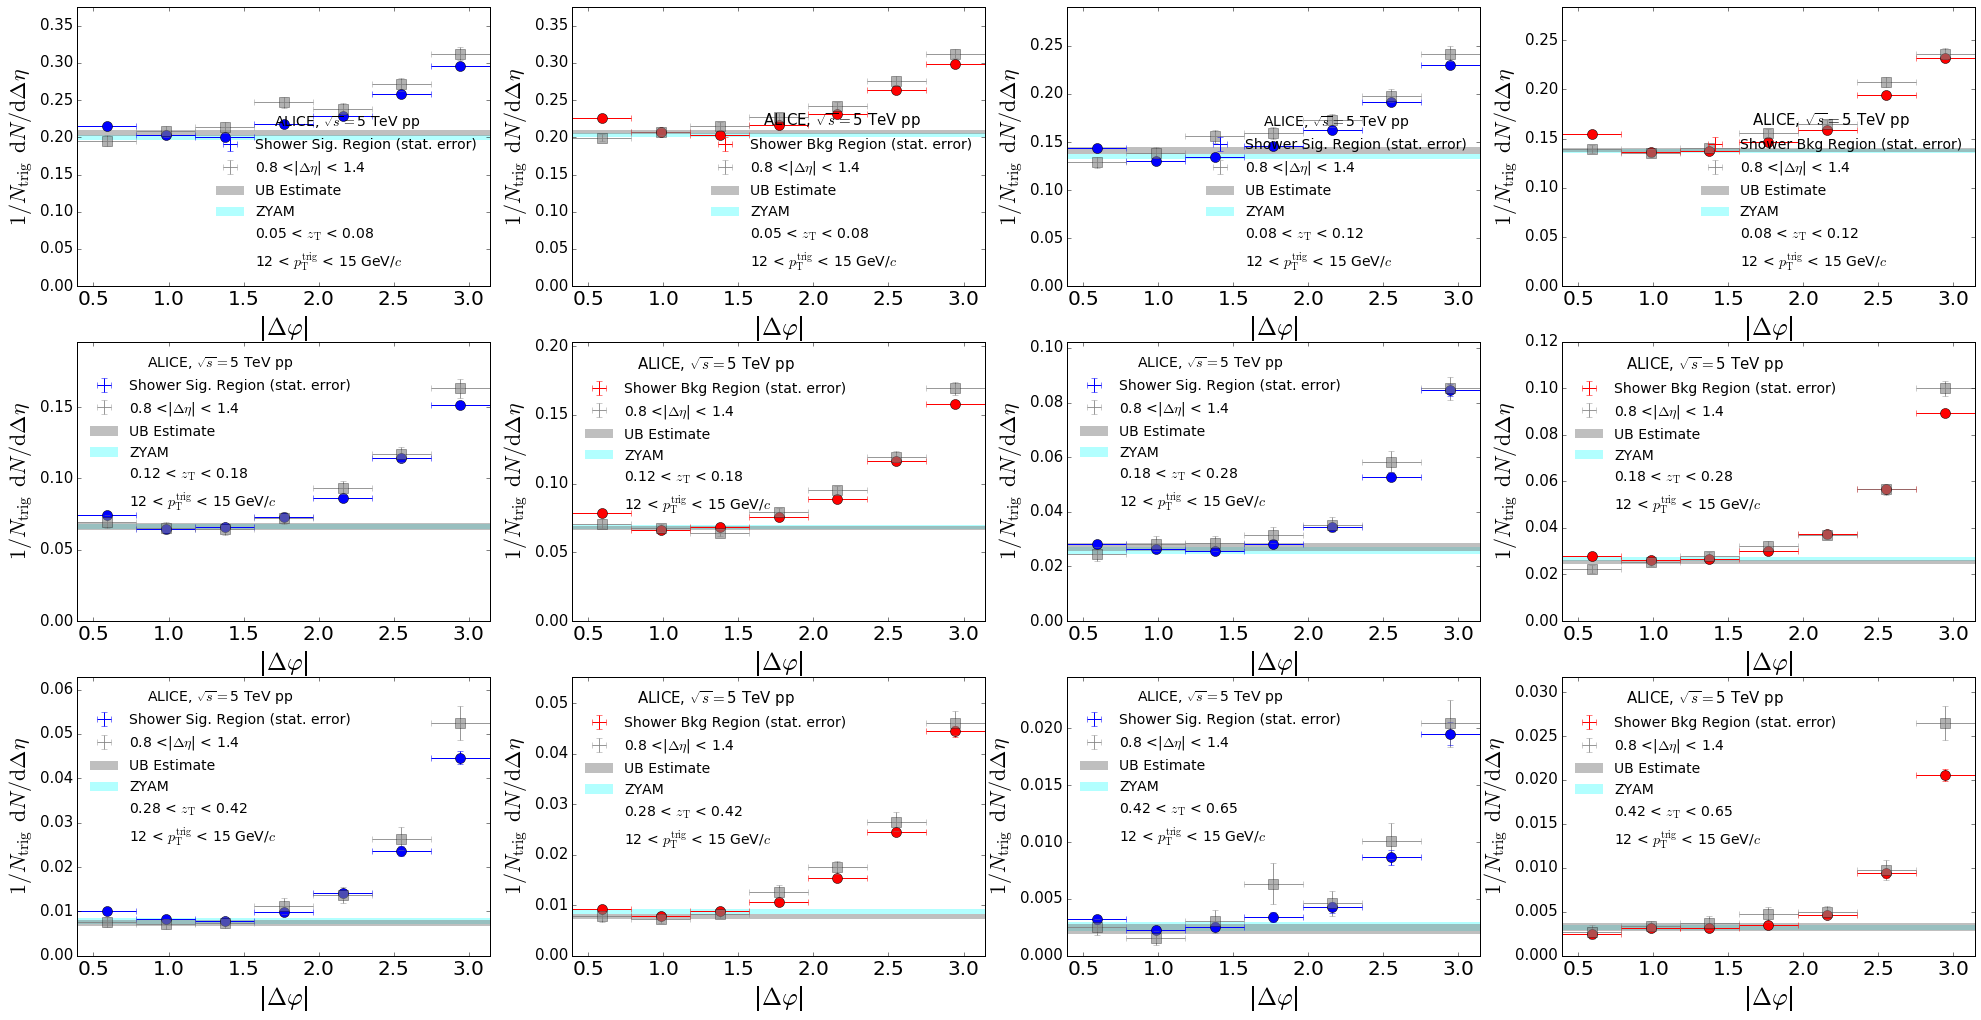

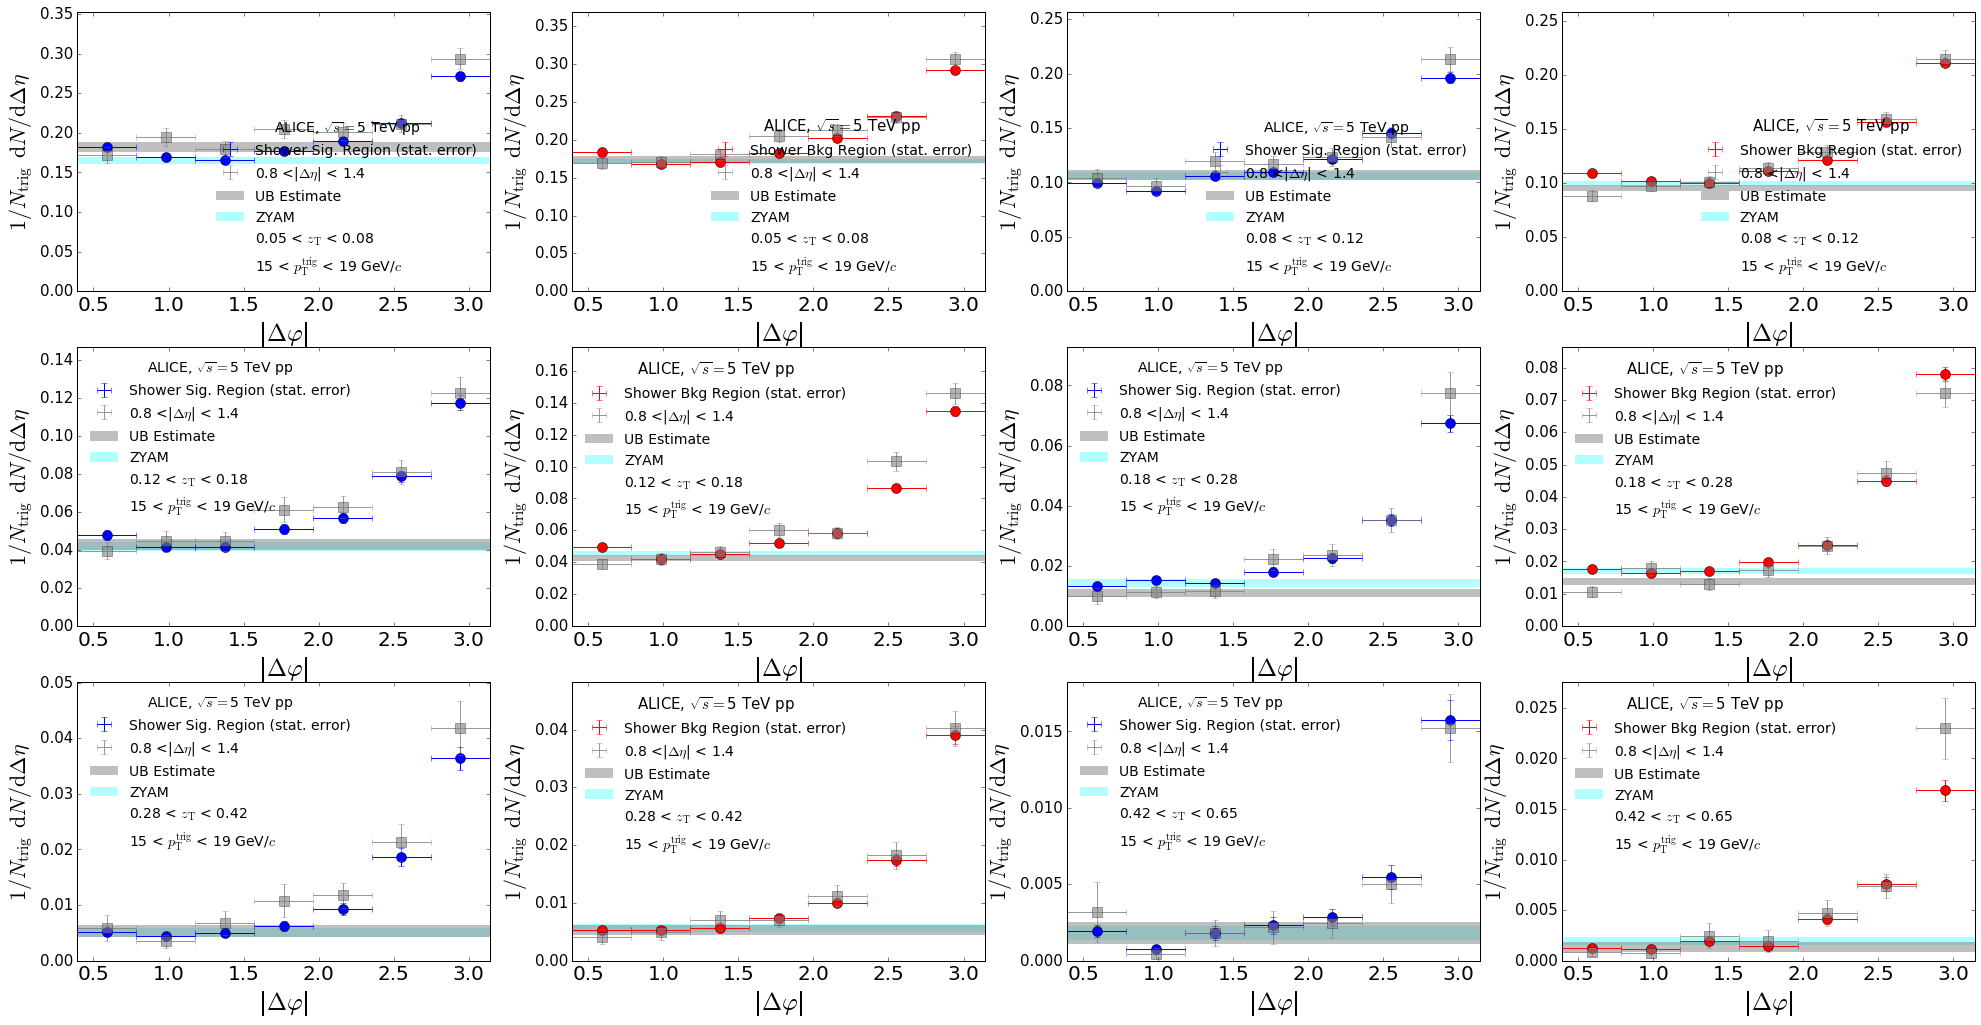

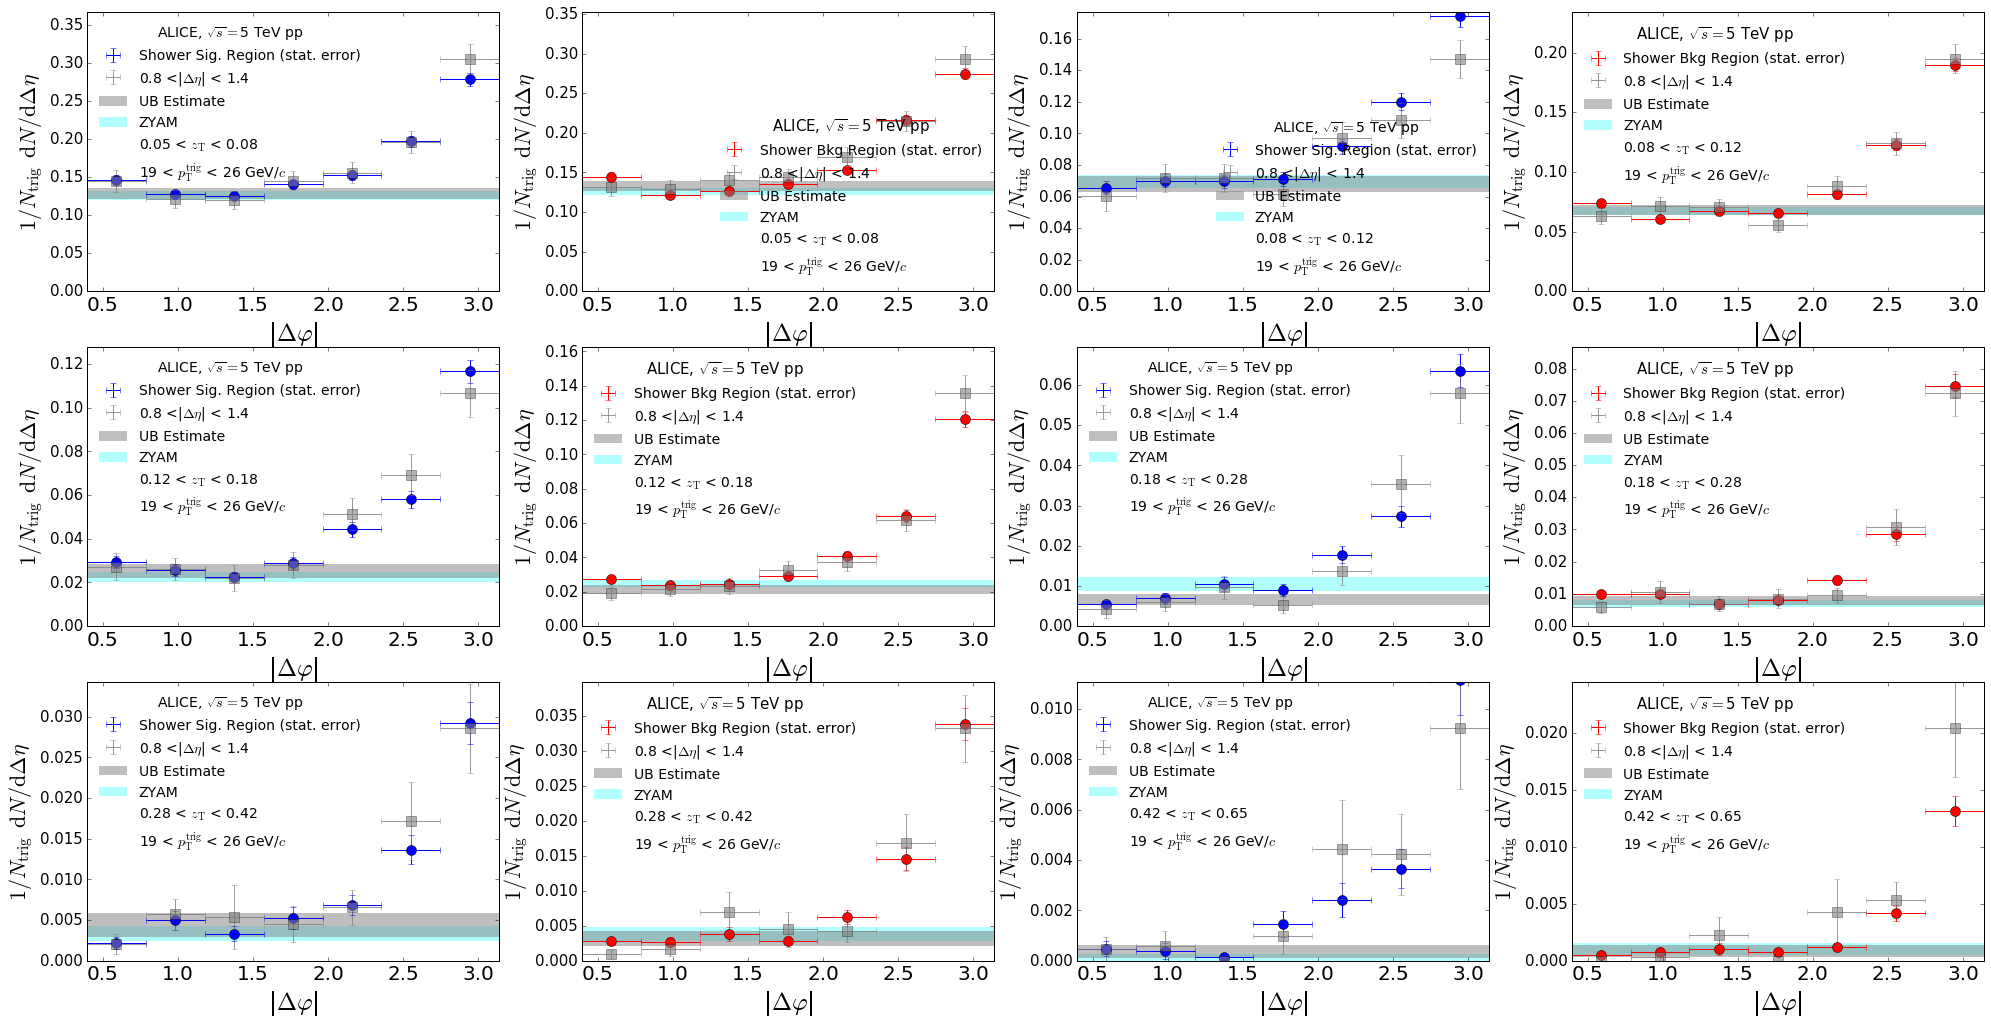

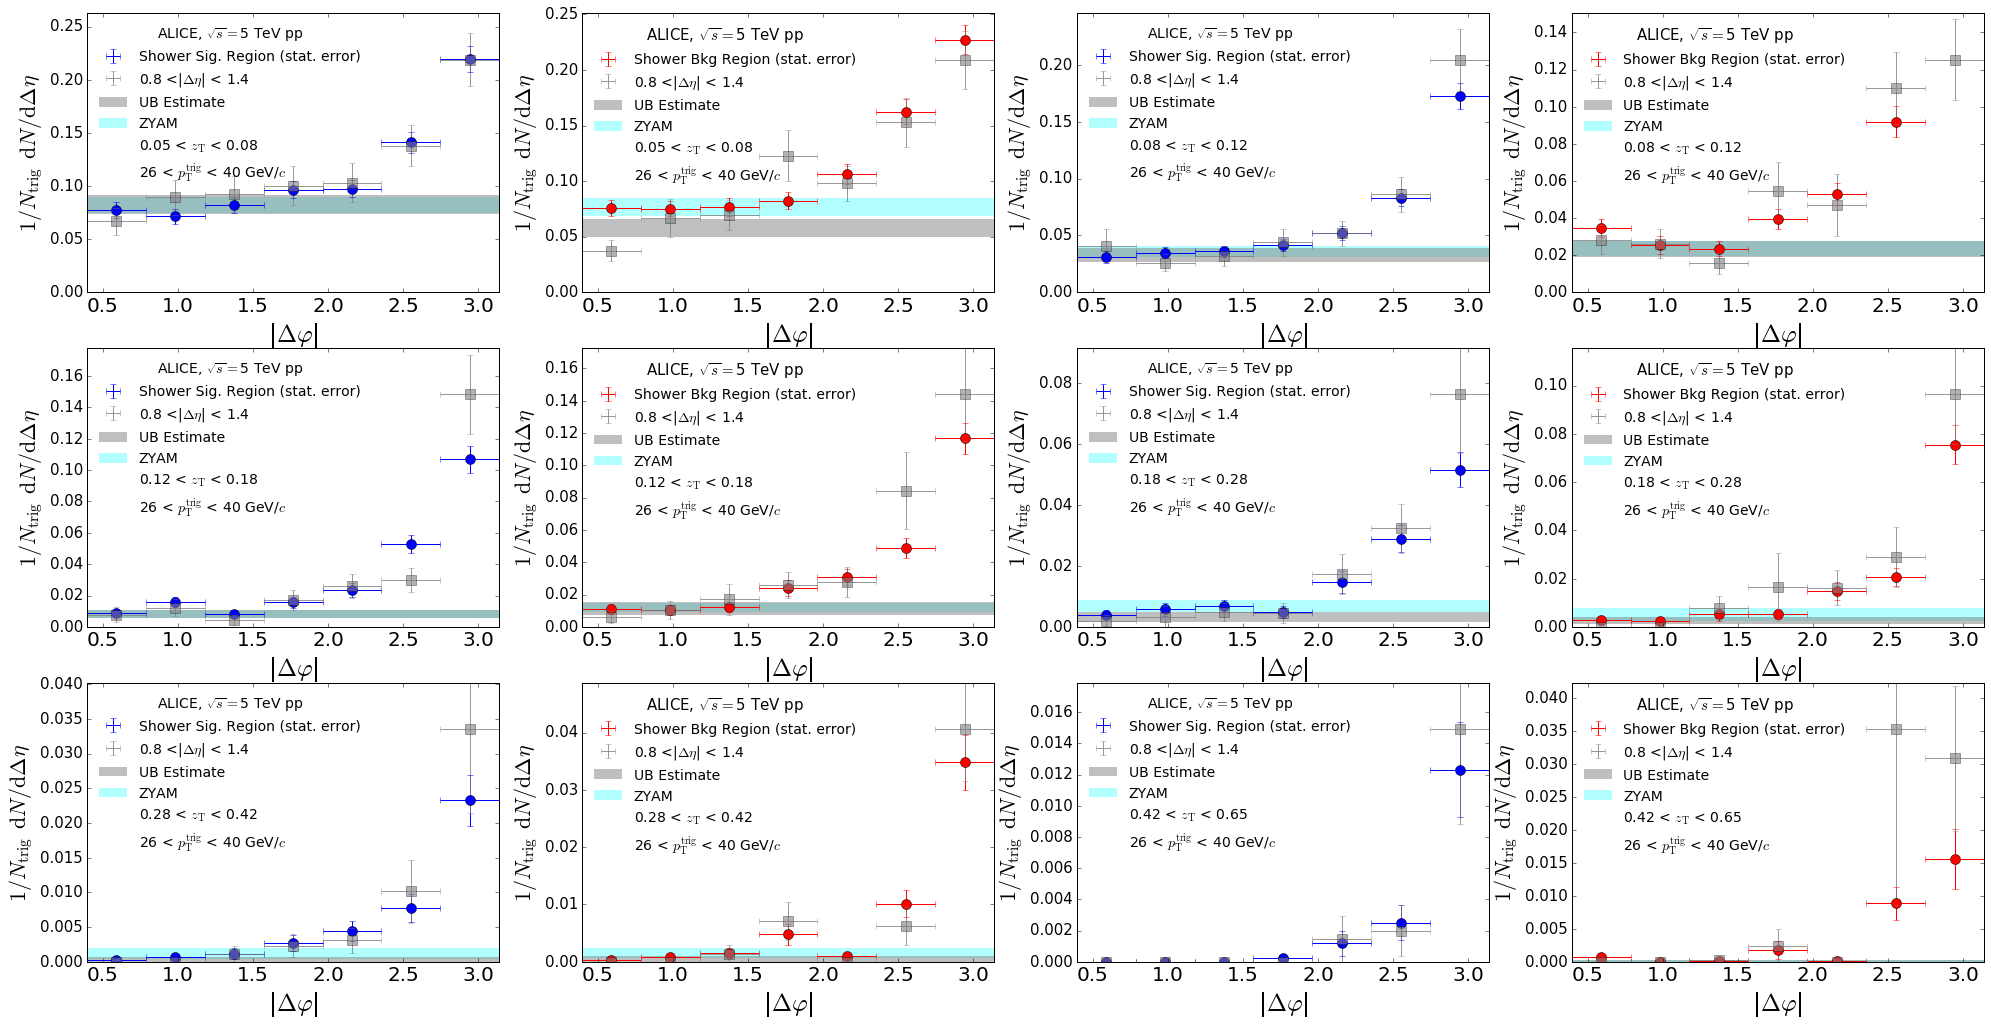

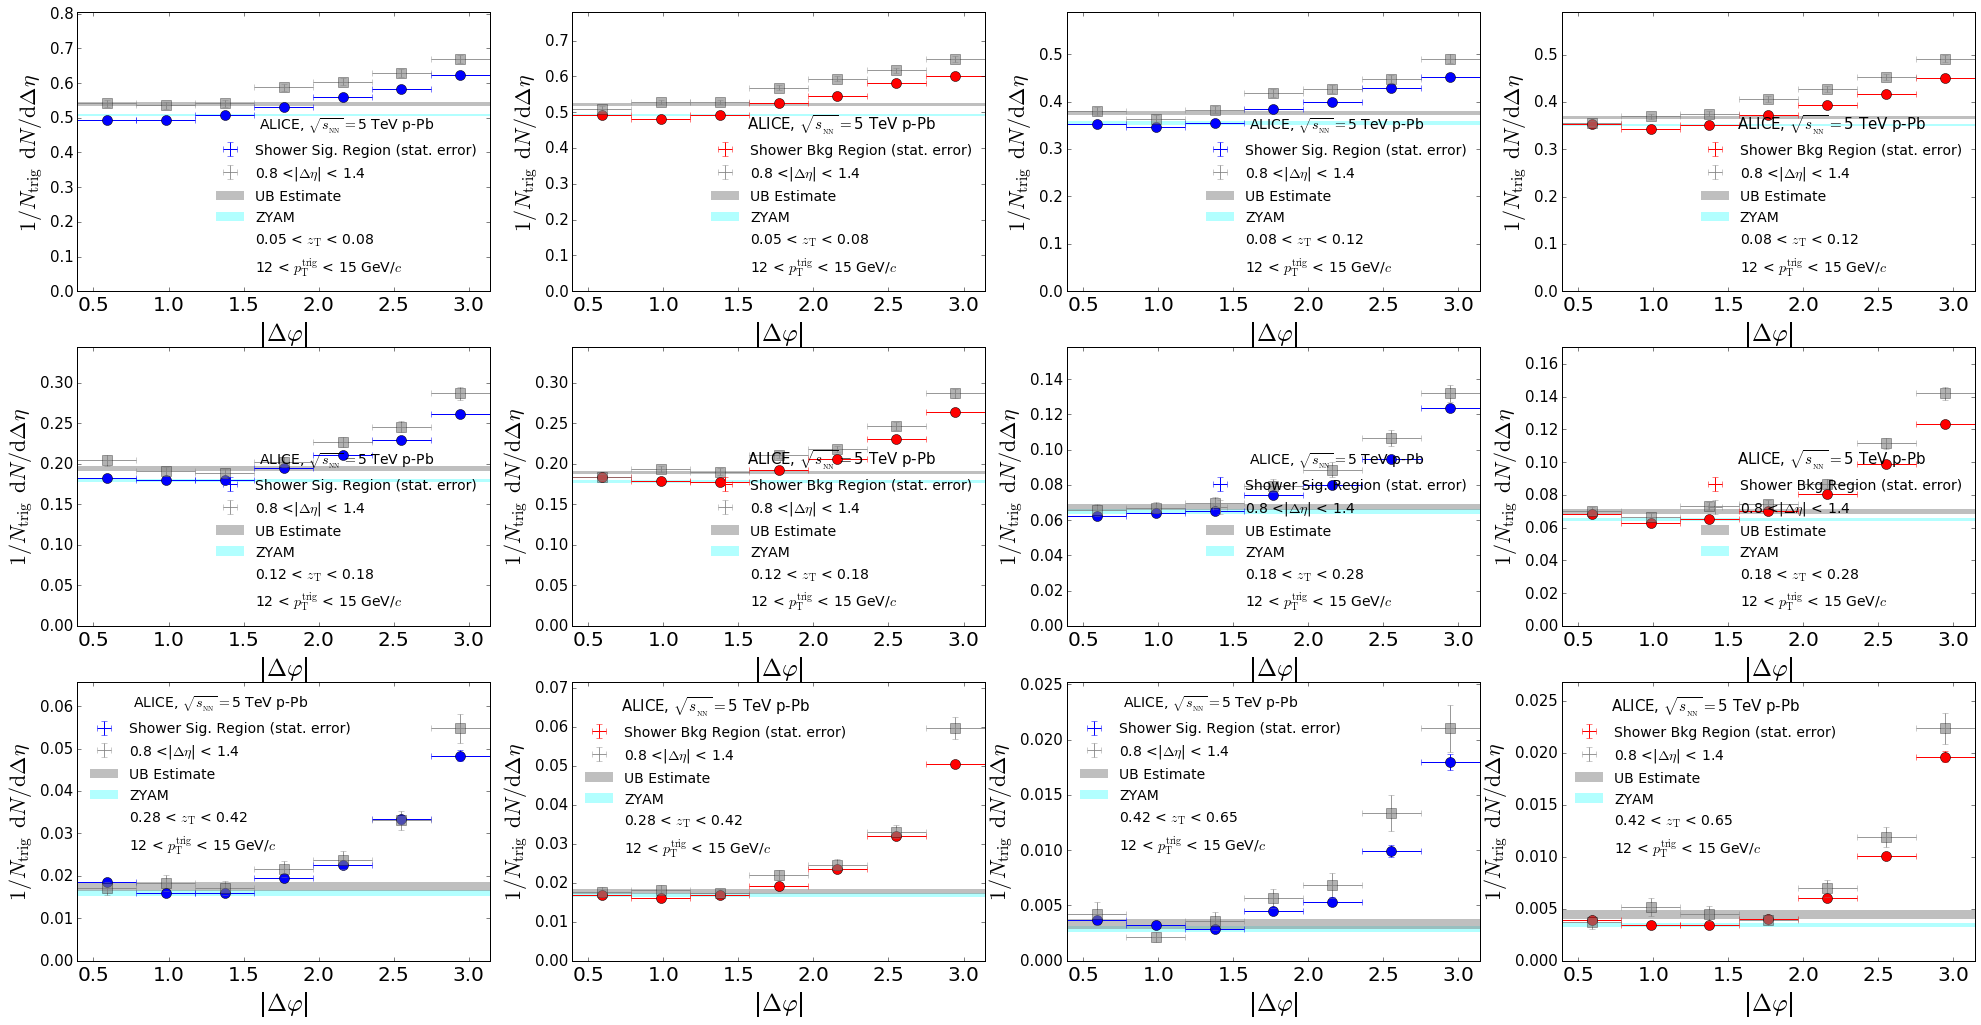

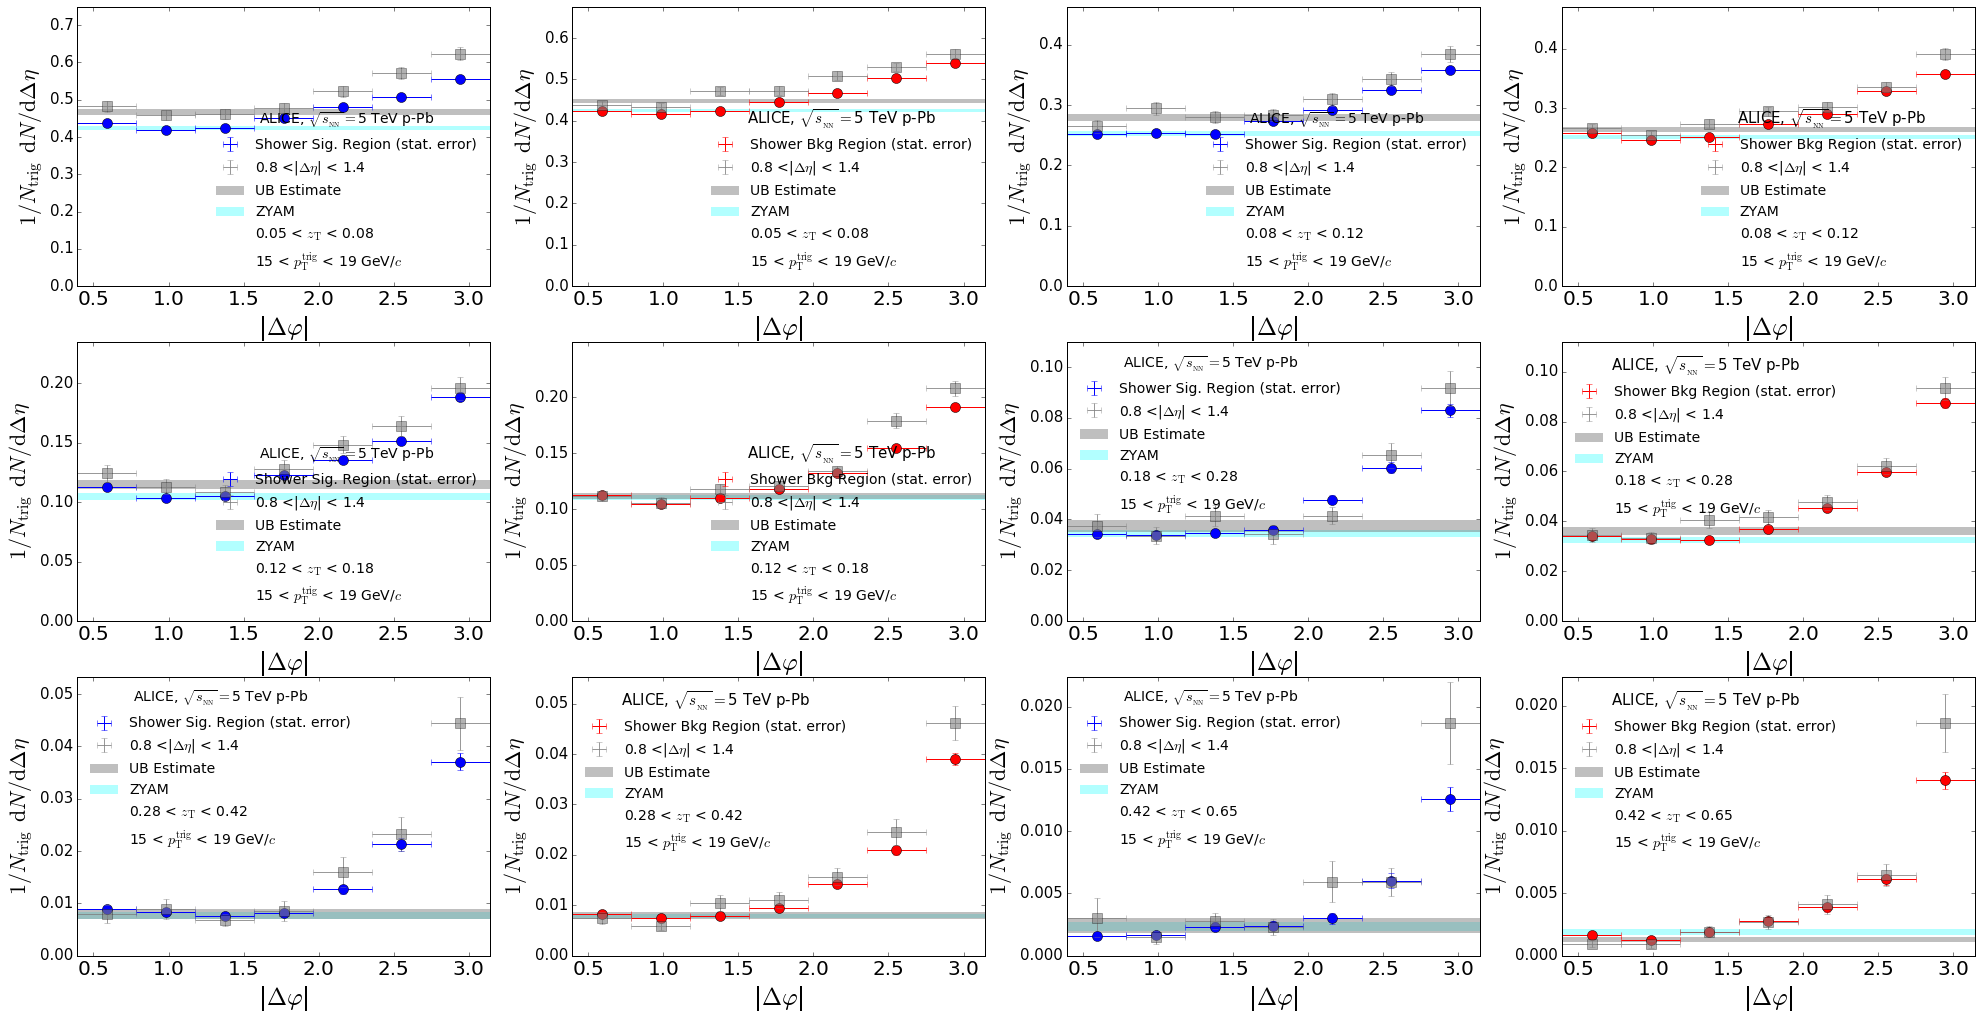

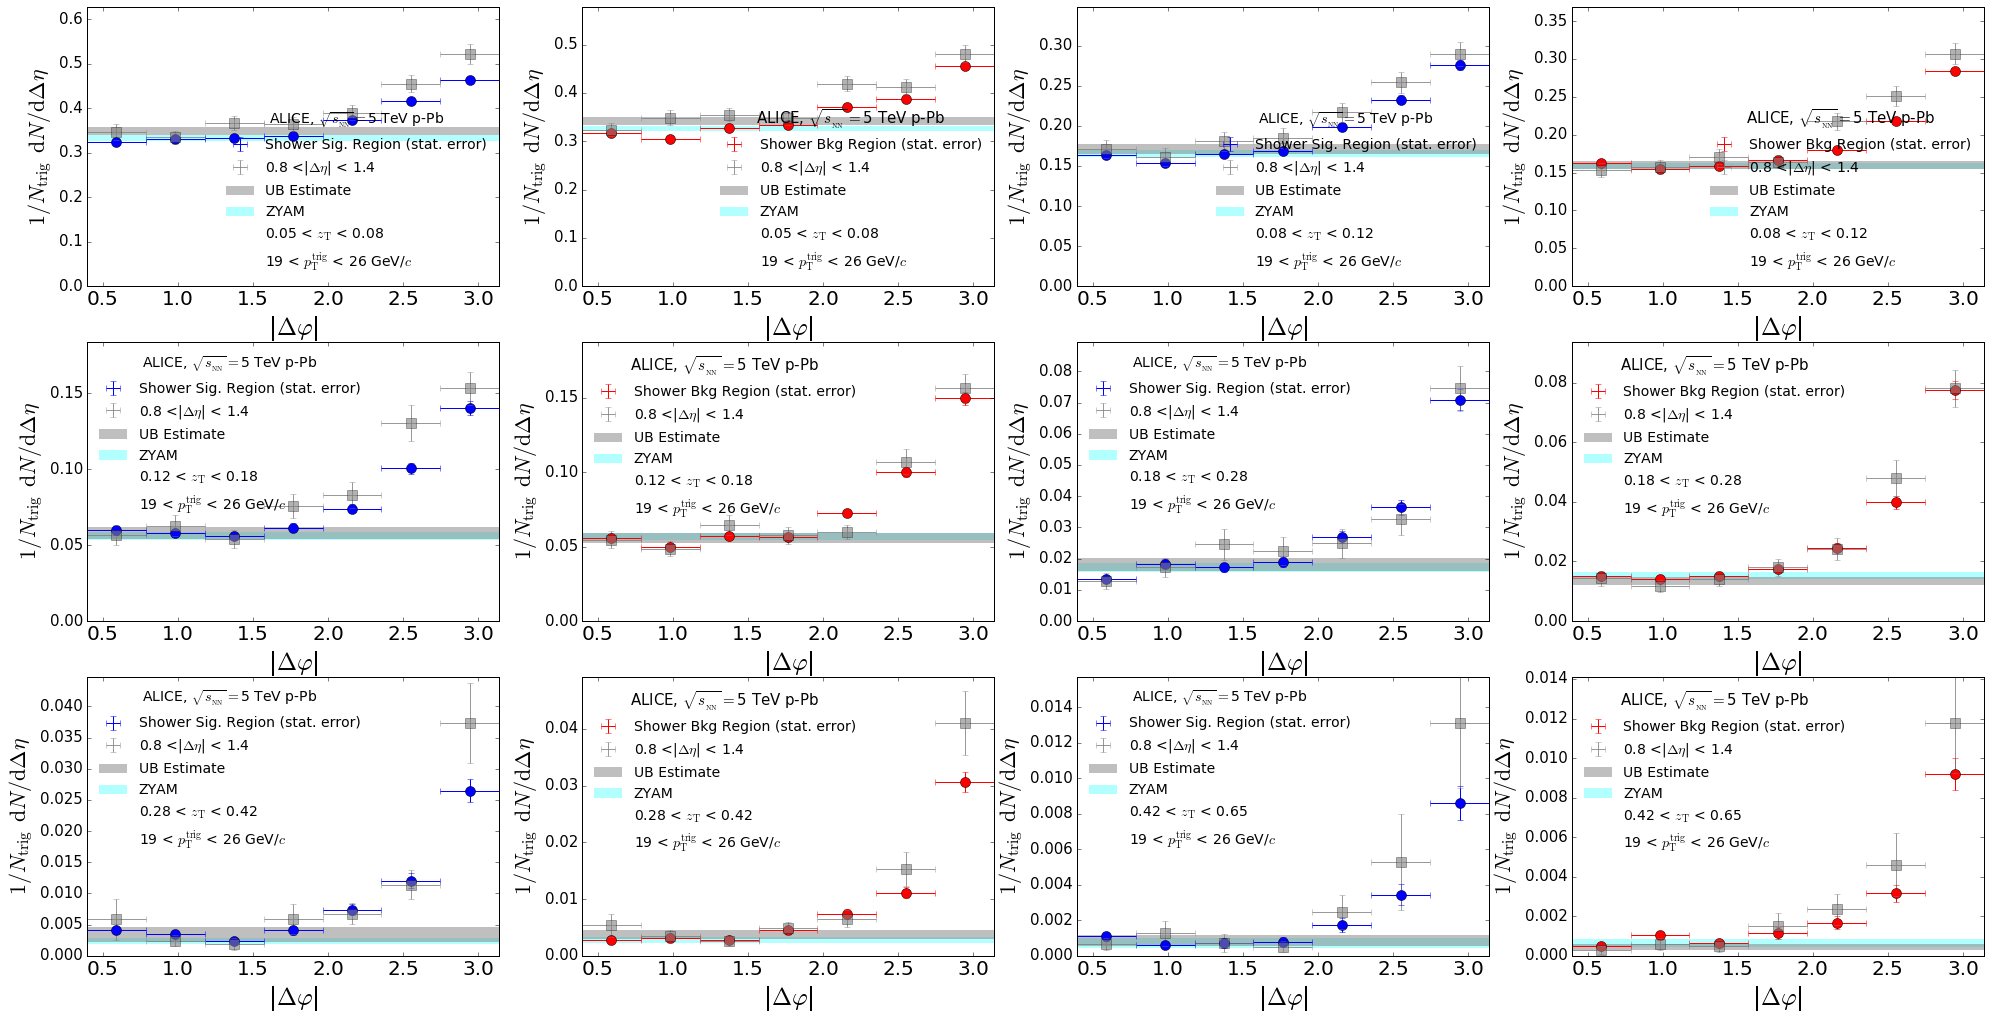

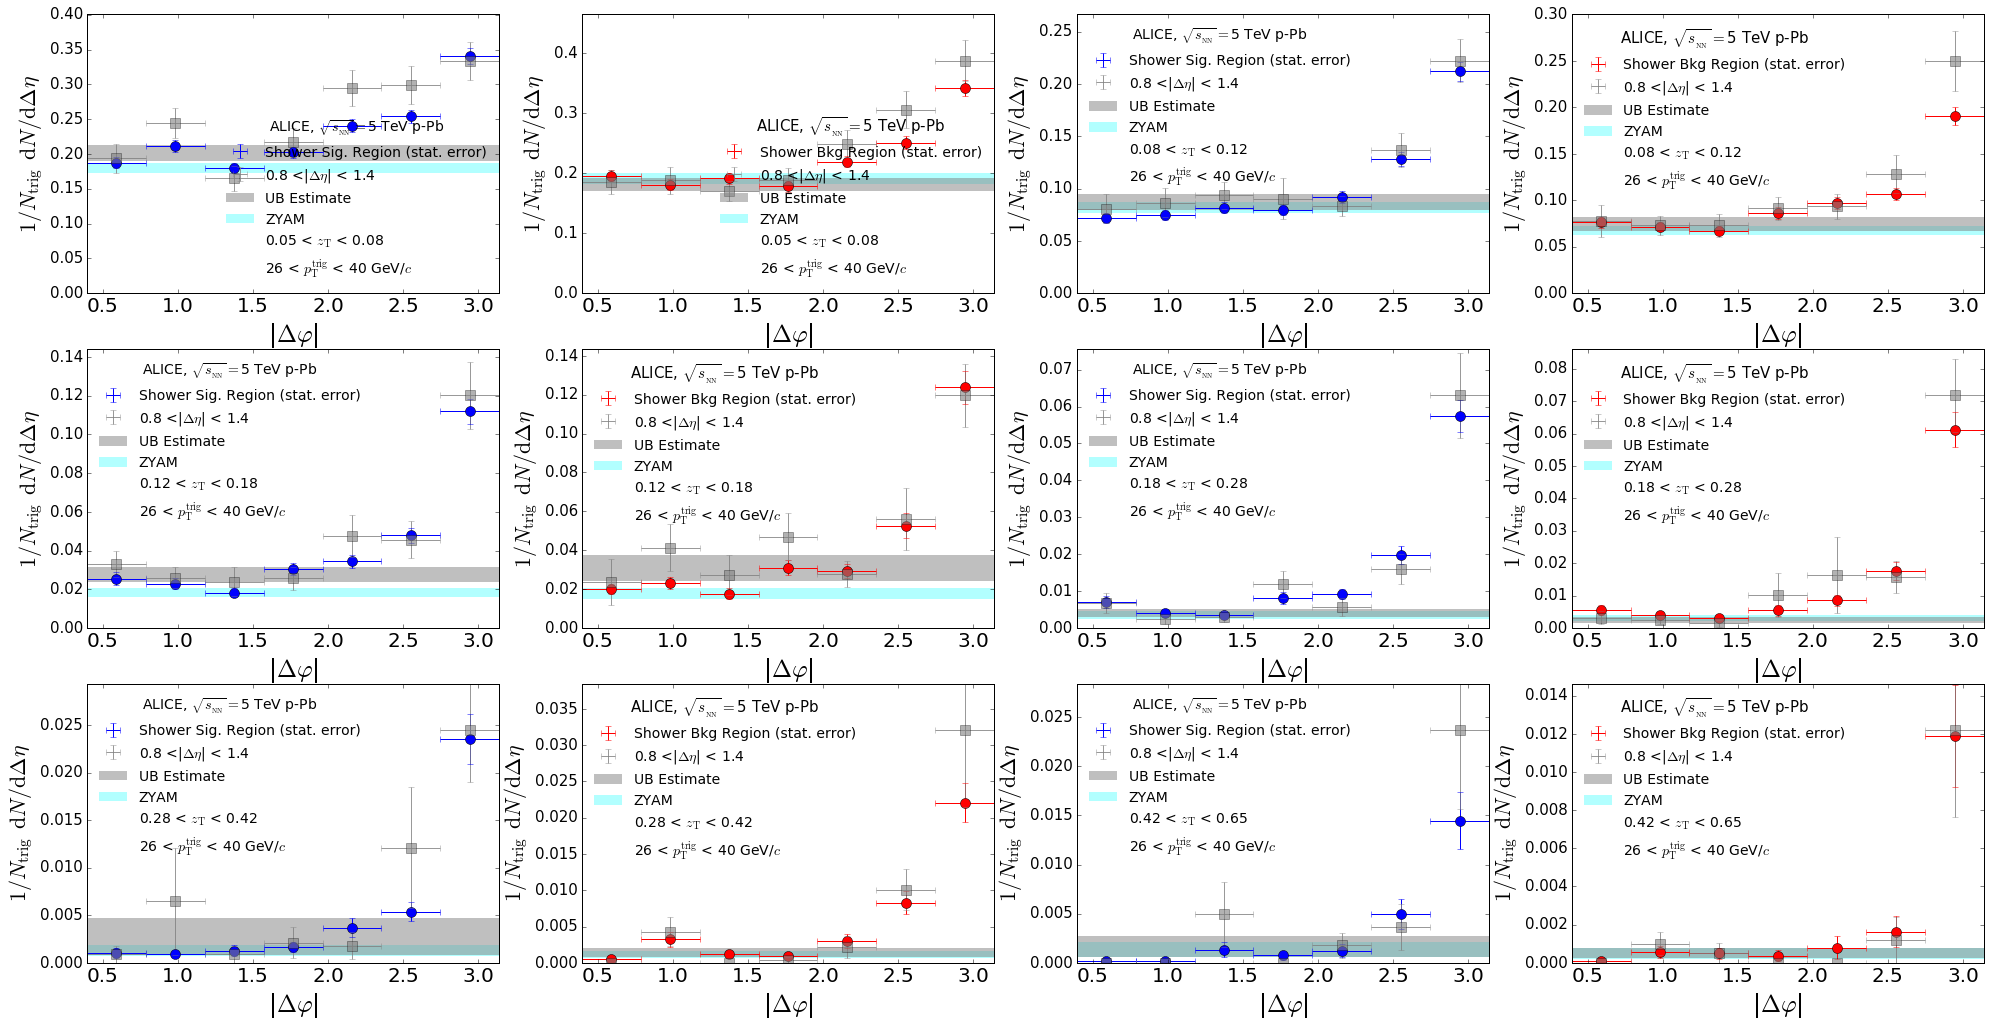

In [188]:
for sys,ifile in zip(Systems,Files):
    print(" $z_T$ interval   & LE Signal Region & LE Background Region & ZYAM Signal Region & ZYAM Background Region")
    for ipt in range (N_pT_Bins):
        fig = plt.figure(figsize=(34,17))
        #if (ipt > 0): continue
        #ipt = ipt+2
        for izt in range (zT_offset,NzT+zT_offset):
            
            ztb = izt-zT_offset
            
            Sig_LE_Phi_Array, Sig_LE_Error_Array = GetLEProj(ifile, ipt, izt, True,False)#2 Bools: Signal_Region, LE Region Averegaing
            Bkg_LE_Phi_Array, Bkg_LE_Error_Array = GetLEProj(ifile, ipt, izt, False,False)

            S_LE, S_LE_Error = GetLE_Val(Sig_LE_Phi_Array, Sig_LE_Error_Array)
            Bkg_LE, Bkg_LE_Error = GetLE_Val(Bkg_LE_Phi_Array, Bkg_LE_Error_Array)


            Sig_Phi_Array, Sig_Phi_Error_Array = GetPhiProj(ifile,sys,ipt,izt,True)
            Bkg_Phi_Array, Bkg_Phi_Error_Array = GetPhiProj(ifile,sys,ipt,izt,False)


            Sig_Z_Value,Sig_Z_Error = ZYAM_Line(Sig_Phi_Array, Sig_Phi_Error_Array)
            Bkg_Z_Value,Bkg_Z_Error = ZYAM_Line(Bkg_Phi_Array, Bkg_Phi_Error_Array)

            print("%1.2f - %1.2f & %1.3f $\pm$ %1.3f & %1.3f $\pm$ %1.3f & %1.3f $\pm$ %1.3f & %1.3f $\pm$ %1.4f \\\\"
                  %(zTbins[izt],zTbins[izt+1],S_LE,S_LE_Error,Bkg_LE,Bkg_LE_Error,Sig_Z_Value,Sig_Z_Error,Bkg_Z_Value,Bkg_Z_Error))

                                            
                                        #--------------plot--------------------#
           
            if (NzT ==4):
                ax = fig.add_subplot(2,4,(2*ztb+1))
            elif (NzT ==6):
                ax = fig.add_subplot(3,4,(2*ztb+1))
                
            fsize = 20

            #sig
            ax.plot(delta_phi_centers,Sig_Phi_Array,'bo',ms=10)
            s_plot = ax.errorbar(delta_phi_centers,Sig_Phi_Array,xerr=phi_width,yerr=Sig_Phi_Error_Array,fmt=None,ecolor='b',label='Signal Region (stat. error)')

            ax.plot(delta_phi_centers,Sig_LE_Phi_Array,'s',color="Grey",alpha=0.6,ms=10)
            s_le_plot = ax.errorbar(delta_phi_centers,Sig_LE_Phi_Array,xerr=phi_width,yerr=Sig_LE_Error_Array,fmt=None,ecolor='Grey',alpha=0.8,label="0.8 <|$\Delta\eta$| < 1.4")

            plt.xlabel(r'|$\Delta \varphi$|',fontsize=fsize+4)
            plt.xticks(fontsize=(fsize))
            plt.xlim((0.39269908169872414,3.14159))
            plt.ylabel(r'$1/N_{\mathrm{trig}} \: \: \mathrm{d}N/\mathrm{d}\Delta\eta$',fontsize=fsize+2)
            plt.ylim((0,1.2*max(Sig_LE_Phi_Array)))
            empt, = ax.plot([], []," ")
            empt2, = ax.plot([],[]," ")
            plt.yticks(fontsize=fsize-5)

            fill_x = [0,3.14159]
            s_z_line = ax.fill_between(fill_x, Sig_Z_Value-Sig_Z_Error,Sig_Z_Value+Sig_Z_Error,interpolate=False,edgecolor='cyan',linewidth=0.0, alpha=0.3,facecolor='cyan')
            s_le_line = ax.fill_between(fill_x, S_LE-S_LE_Error,S_LE+S_LE_Error,interpolate=False,edgecolor='grey',linewidth=0.0, alpha=0.5,facecolor='grey')

            leg = ax.legend([s_plot,s_le_plot,s_le_line,s_z_line,empt,empt2],['Shower Sig. Region (stat. error)','0.8 <|$\Delta\eta$| < 1.4','UB Estimate',
                'ZYAM',r'%1.2f < $z_\mathrm{T}$ < %1.2f'%(zTbins[izt],zTbins[izt+1]),r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c$'%(pTbins[ipt],pTbins[ipt+1])],
                loc='best',title = "Alice %s 5 TeV",fontsize=14,frameon=False,numpoints=1)
            if (sys == 'pp'):
                leg.set_title("ALICE, $\sqrt{s}=$5 TeV %s"%(sys))
            else:
                leg.set_title("ALICE, $\sqrt{s_{\mathrm{_{NN}}}}=$5 TeV %s"%(sys))                
            plt.setp(leg.get_title(),fontsize=14)


            #bkg
            if (NzT ==4):
                ax = fig.add_subplot(2,4,(2*ztb+2))
            elif (NzT ==6):
                ax = fig.add_subplot(3,4,(2*ztb+2))
                
            #ax = fig.add_subplot(1,2,1)
            plt.xlabel(r'|$\Delta \varphi$|',fontsize=fsize+4)
            plt.xticks(fontsize=(fsize))
            plt.xlim((0.39269908169872414,3.14159))
            plt.ylabel(r'$1/N_{\mathrm{trig}} \: \: \mathrm{d}N/\mathrm{d}\Delta\eta$',fontsize=fsize+2)
            plt.ylim((0,1.2*max(Bkg_LE_Phi_Array)))
            plt.yticks(fontsize=fsize-5)

            fill_x = [0,3.14149]
            b_z_line = plt.fill_between(fill_x, Bkg_Z_Value-Bkg_Z_Error,Bkg_Z_Value+Bkg_Z_Error,interpolate=False,edgecolor='cyan',linewidth=0.0, alpha=0.3,facecolor='cyan')
            b_le_line = plt.fill_between(fill_x, Bkg_LE-Bkg_LE_Error,Bkg_LE+Bkg_LE_Error,interpolate=False,edgecolor='grey',linewidth=0.0, alpha=0.5,facecolor='grey')

            ax.plot(delta_phi_centers,Bkg_Phi_Array,'ro',ms=10)
            b_plot = ax.errorbar(delta_phi_centers,Bkg_Phi_Array,xerr=phi_width,yerr=Bkg_Phi_Error_Array,fmt=None,ecolor='r')

            plt.plot(delta_phi_centers,Bkg_LE_Phi_Array,'s',color="Grey",alpha=0.6,ms=10)

            b_le_plot =plt.errorbar(delta_phi_centers,Bkg_LE_Phi_Array,xerr=phi_width,yerr=Bkg_LE_Error_Array,fmt=None,ecolor='Grey',alpha=0.8)
            leg = ax.legend([b_plot,b_le_plot,b_le_line,b_z_line,empt,empt2],['Shower Bkg Region (stat. error)','0.8 <|$\Delta\eta$| < 1.4','UB Estimate',
                'ZYAM',r'%1.2f < $z_\mathrm{T}$ < %1.2f'%(zTbins[izt],zTbins[izt+1]),r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c$'%(pTbins[ipt],pTbins[ipt+1])],
                loc='best',fontsize=14,frameon=False,numpoints=1)
            if (sys == 'pp'):
                leg.set_title("ALICE, $\sqrt{s}=$5 TeV %s"%(sys))
            else:
                leg.set_title("ALICE, $\sqrt{s_{\mathrm{_{NN}}}}=$5 TeV %s"%(sys))
            plt.setp(leg.get_title(),fontsize=15)
        fig.savefig('pics/%s_Gamma_hadron_UE_pT_%i__zT_%i.pdf'%(sys,ipt,izt), bbox_inches='tight')        
        print("")
    print("")
    #return

Made the decision to not declare global np.arrays containing the plot data until after UE subtraction. This way there are only two sets of arrays for each system, background and signal regions with their errors (no LE or ZYAM data structures).

# Subtract UE and Start Using Global Arrays

In [14]:
 #Number of zT bins, subject to change

#Global Arrays
pp_CSR = np.zeros((N_pT_Bins, NzT,len(delta_phi_centers)))
pp_CSR_Errors = np.zeros((N_pT_Bins, NzT,len(delta_phi_centers)))
pp_CBR = np.zeros((N_pT_Bins, NzT,len(delta_phi_centers)))
pp_CBR_Errors = np.zeros((N_pT_Bins, NzT,len(delta_phi_centers)))

pPb_CSR = np.zeros((N_pT_Bins, NzT,len(delta_phi_centers)))
pPb_CSR_Errors = np.zeros((N_pT_Bins, NzT,len(delta_phi_centers)))
pPb_CBR = np.zeros((N_pT_Bins, NzT,len(delta_phi_centers)))
pPb_CBR_Errors = np.zeros((N_pT_Bins, NzT,len(delta_phi_centers)))

MC_CSR = np.zeros((N_pT_Bins, NzT,len(delta_phi_centers)))
MC_CSR_Errors = np.zeros((N_pT_Bins, NzT,len(delta_phi_centers)))
MC_CBR = np.zeros((N_pT_Bins, NzT,len(delta_phi_centers)))
MC_CBR_Errors = np.zeros((N_pT_Bins, NzT,len(delta_phi_centers)))

pp_LE_Error = np.zeros((N_pT_Bins, NzT))
pPb_LE_Error = np.zeros((N_pT_Bins, NzT))

MC_LE_Error = np.zeros((N_pT_Bins, NzT))

for sys,ifile in zip(Systems,Files):
    if (sys == "p-Pb"):
        SYS = "pPb" #can't have '-'
    else:
        SYS=sys
        
    for ipt in range (N_pT_Bins):
        #if (ipt > 0): continue
        #ipt = ipt+2
        for izt in range (zT_offset,NzT+zT_offset):
            ztb = izt-zT_offset
            Sig_LE_Phi_Array, Sig_LE_Error_Array = GetLEProj(ifile, ipt, izt, True,True) # Using AVERAGE LE
            Bkg_LE_Phi_Array, Bkg_LE_Error_Array = GetLEProj(ifile, ipt, izt, False,True) # Using AVERAGE LE

            S_LE, S_LE_Error = GetLE_Val(Sig_LE_Phi_Array, Sig_LE_Error_Array)
            Bkg_LE, Bkg_LE_Error = GetLE_Val(Bkg_LE_Phi_Array, Bkg_LE_Error_Array)


            Sig_Phi_Array, Sig_Phi_Error_Array = GetPhiProj(ifile,sys,ipt,izt,True)
            Bkg_Phi_Array, Bkg_Phi_Error_Array = GetPhiProj(ifile,sys,ipt,izt,False)

            Sig_Phi_Array -= S_LE
            Bkg_Phi_Array -= Bkg_LE
            vars()["%s_CSR"%(SYS)][ipt][ztb] = Sig_Phi_Array
            vars()["%s_CSR_Errors"%(SYS)][ipt][ztb] = Sig_Phi_Error_Array
            
            vars()["%s_CBR"%(SYS)][ipt][ztb] = Bkg_Phi_Array
            vars()["%s_CBR_Errors"%(SYS)][ipt][ztb] = Bkg_Phi_Error_Array
            
            vars()["%s_LE_Error"%(SYS)][ipt][ztb] = S_LE_Error

[[[ -3.78959449e-02  -4.89003654e-02  -3.84039634e-02  -5.73915062e-03
     1.30089311e-02   4.94179390e-02   7.11172332e-02]
  [ -1.70500599e-02  -2.91236274e-02  -1.92988946e-02   2.04654107e-03
     2.22306947e-02   4.62494400e-02   7.91101151e-02]
  [ -8.12675426e-03  -1.31461918e-02  -1.36656882e-02   7.96535435e-04
     1.39130952e-02   3.86823103e-02   7.16158635e-02]
  [ -1.68135166e-04  -5.93218203e-03  -3.55502277e-03   1.75434187e-03
     1.20113162e-02   3.02871385e-02   5.46901060e-02]
  [ -7.10566650e-04  -1.50147149e-03  -7.02621413e-04   1.64065437e-03
     5.78358663e-03   1.42598431e-02   3.28893631e-02]
  [ -9.58139097e-06  -4.87025588e-04  -4.56522915e-04   1.43858084e-04
     2.09634674e-03   6.15904745e-03   1.57478680e-02]]

 [[ -3.36973512e-02  -4.19593575e-02  -3.28416542e-02  -1.31600717e-02
     1.07129163e-02   4.56895868e-02   8.25825679e-02]
  [ -1.34224230e-02  -2.55839876e-02  -2.06436118e-02   1.33846192e-03
     1.81101503e-02   5.67613198e-02   8.5789

# Plot UE Sub. with Uncertainties

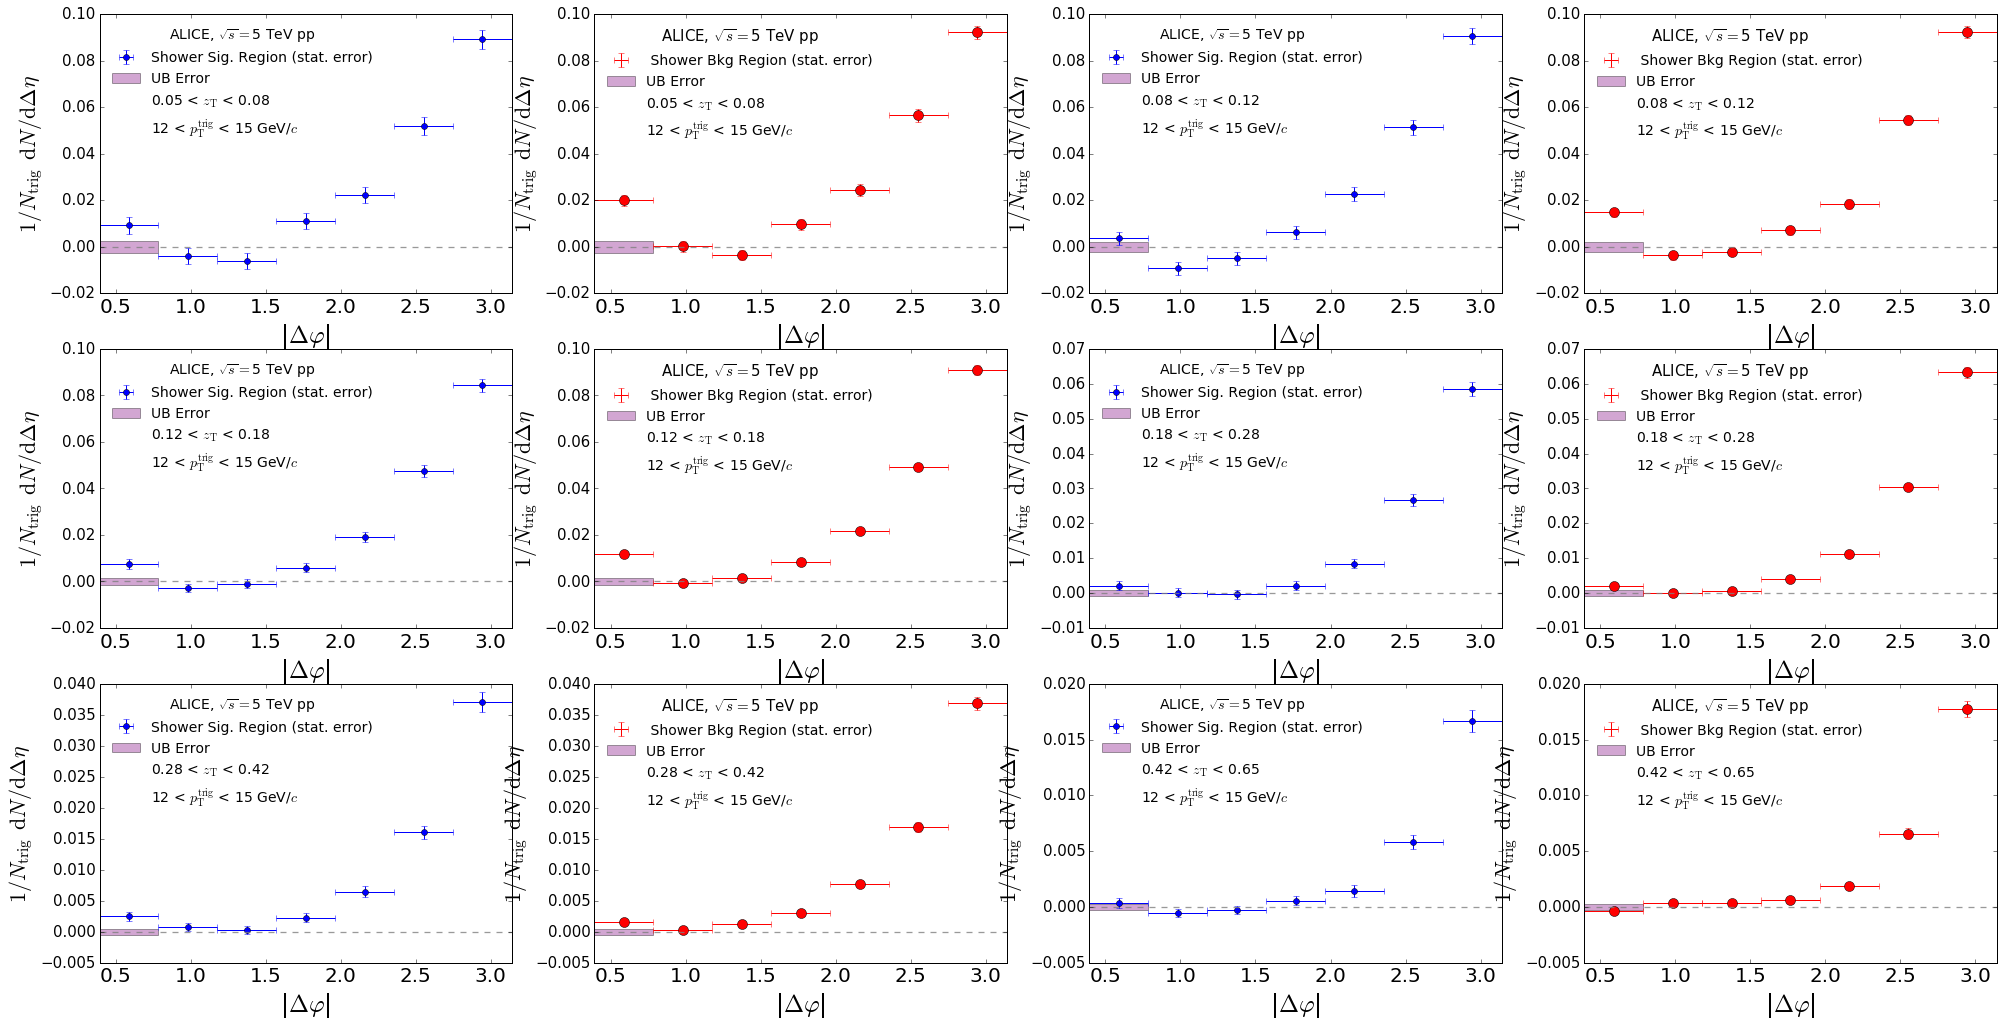

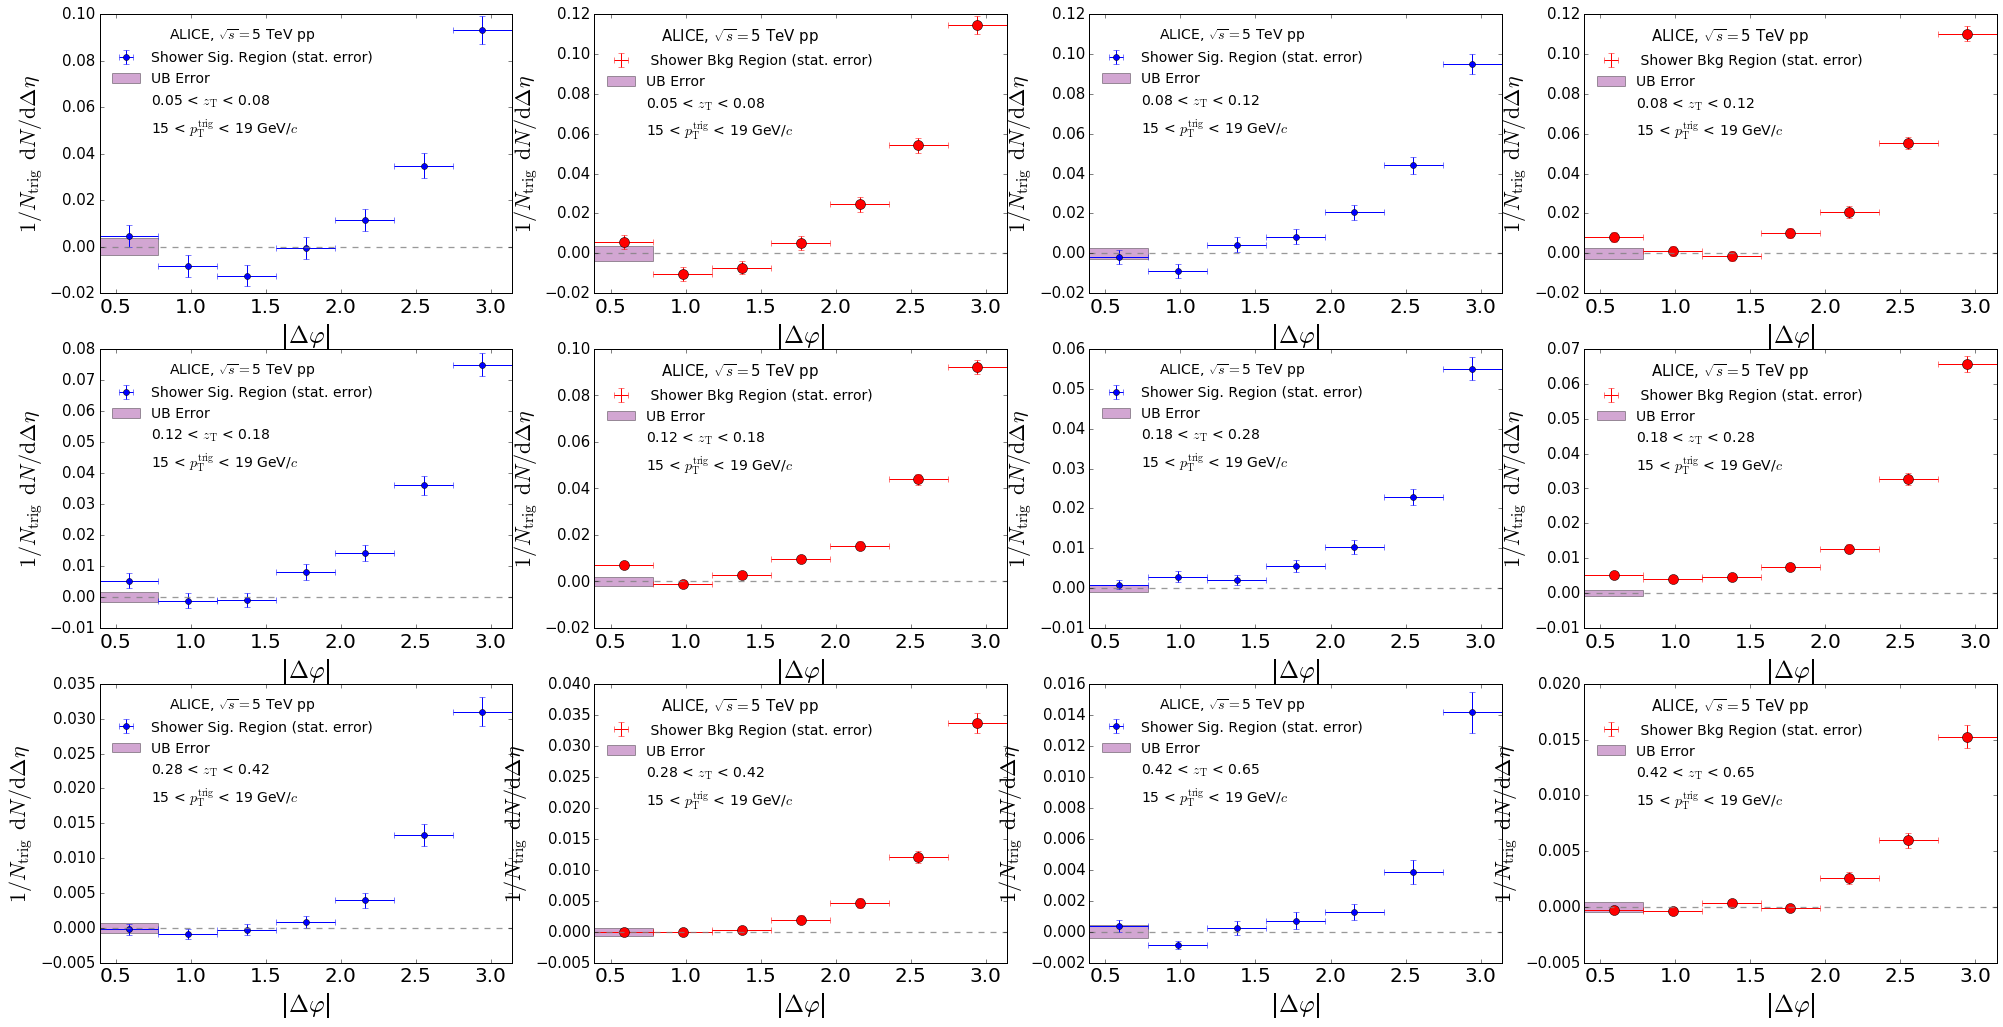

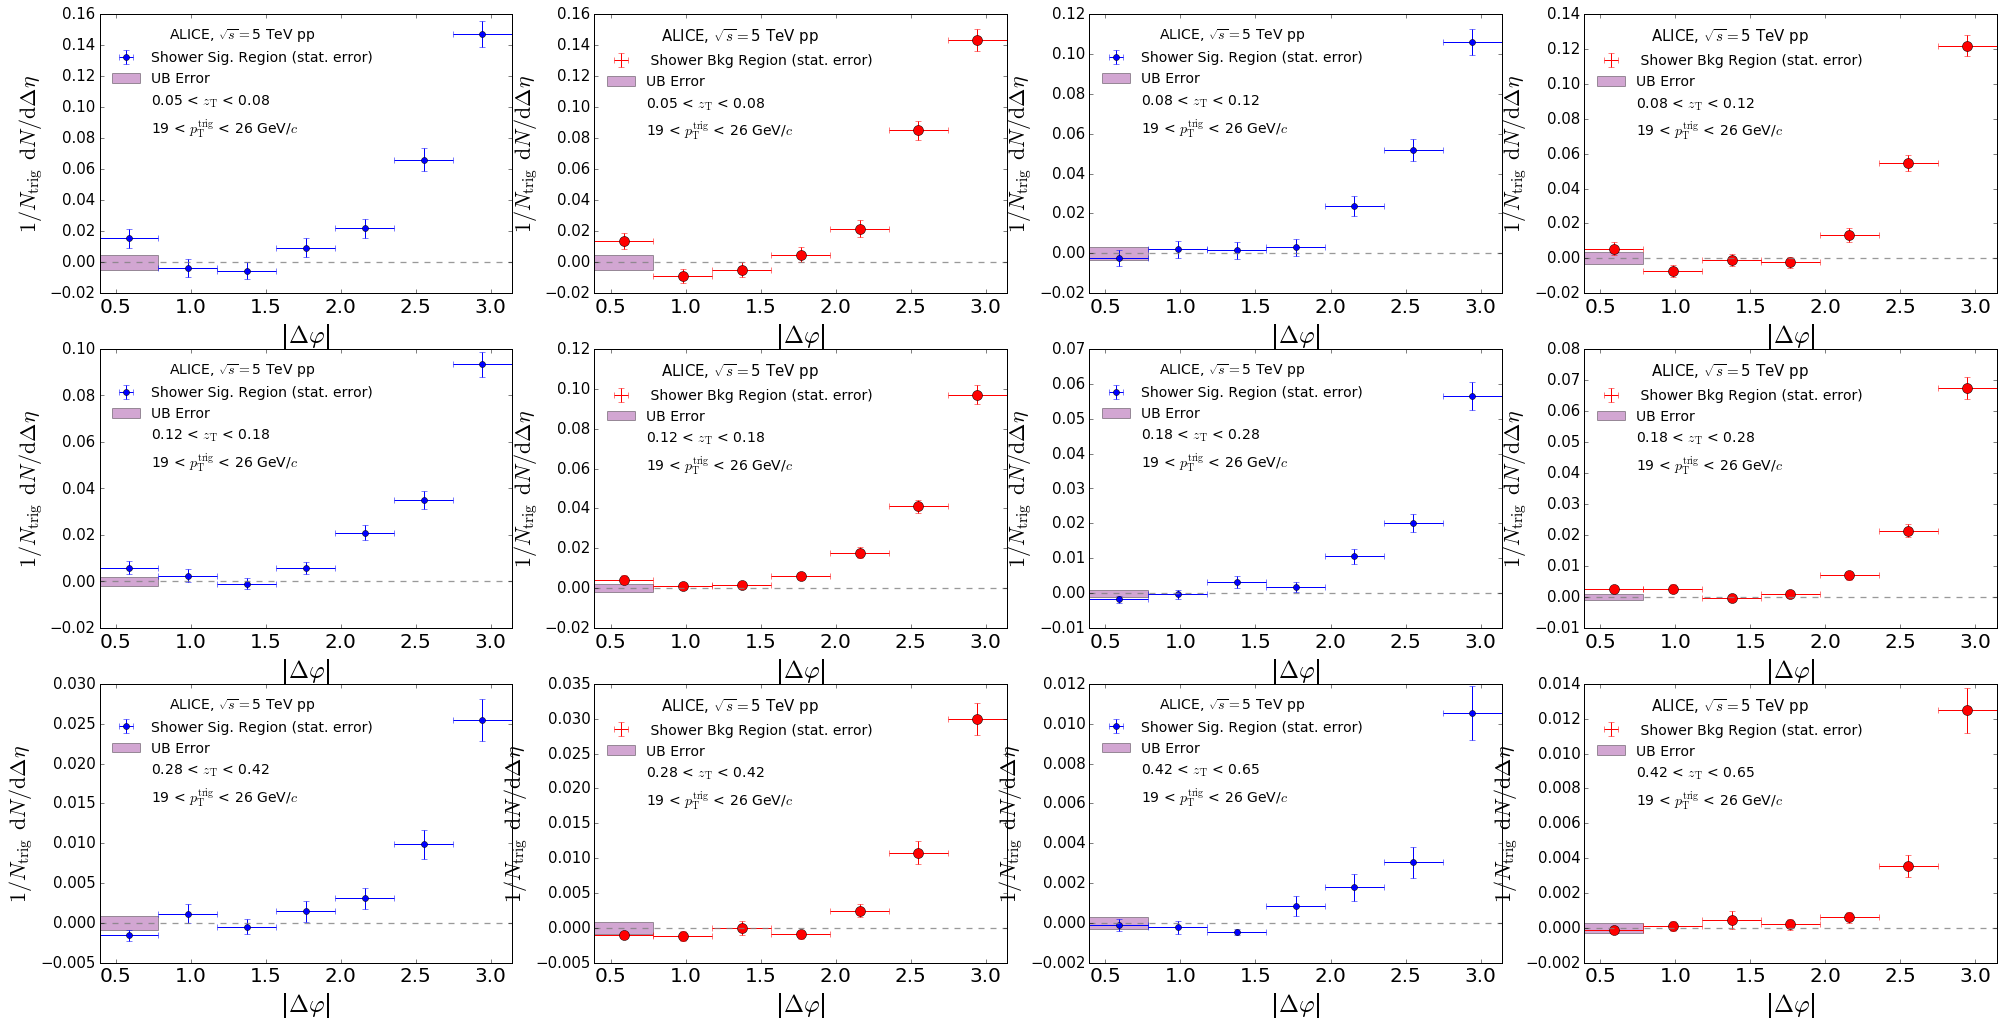

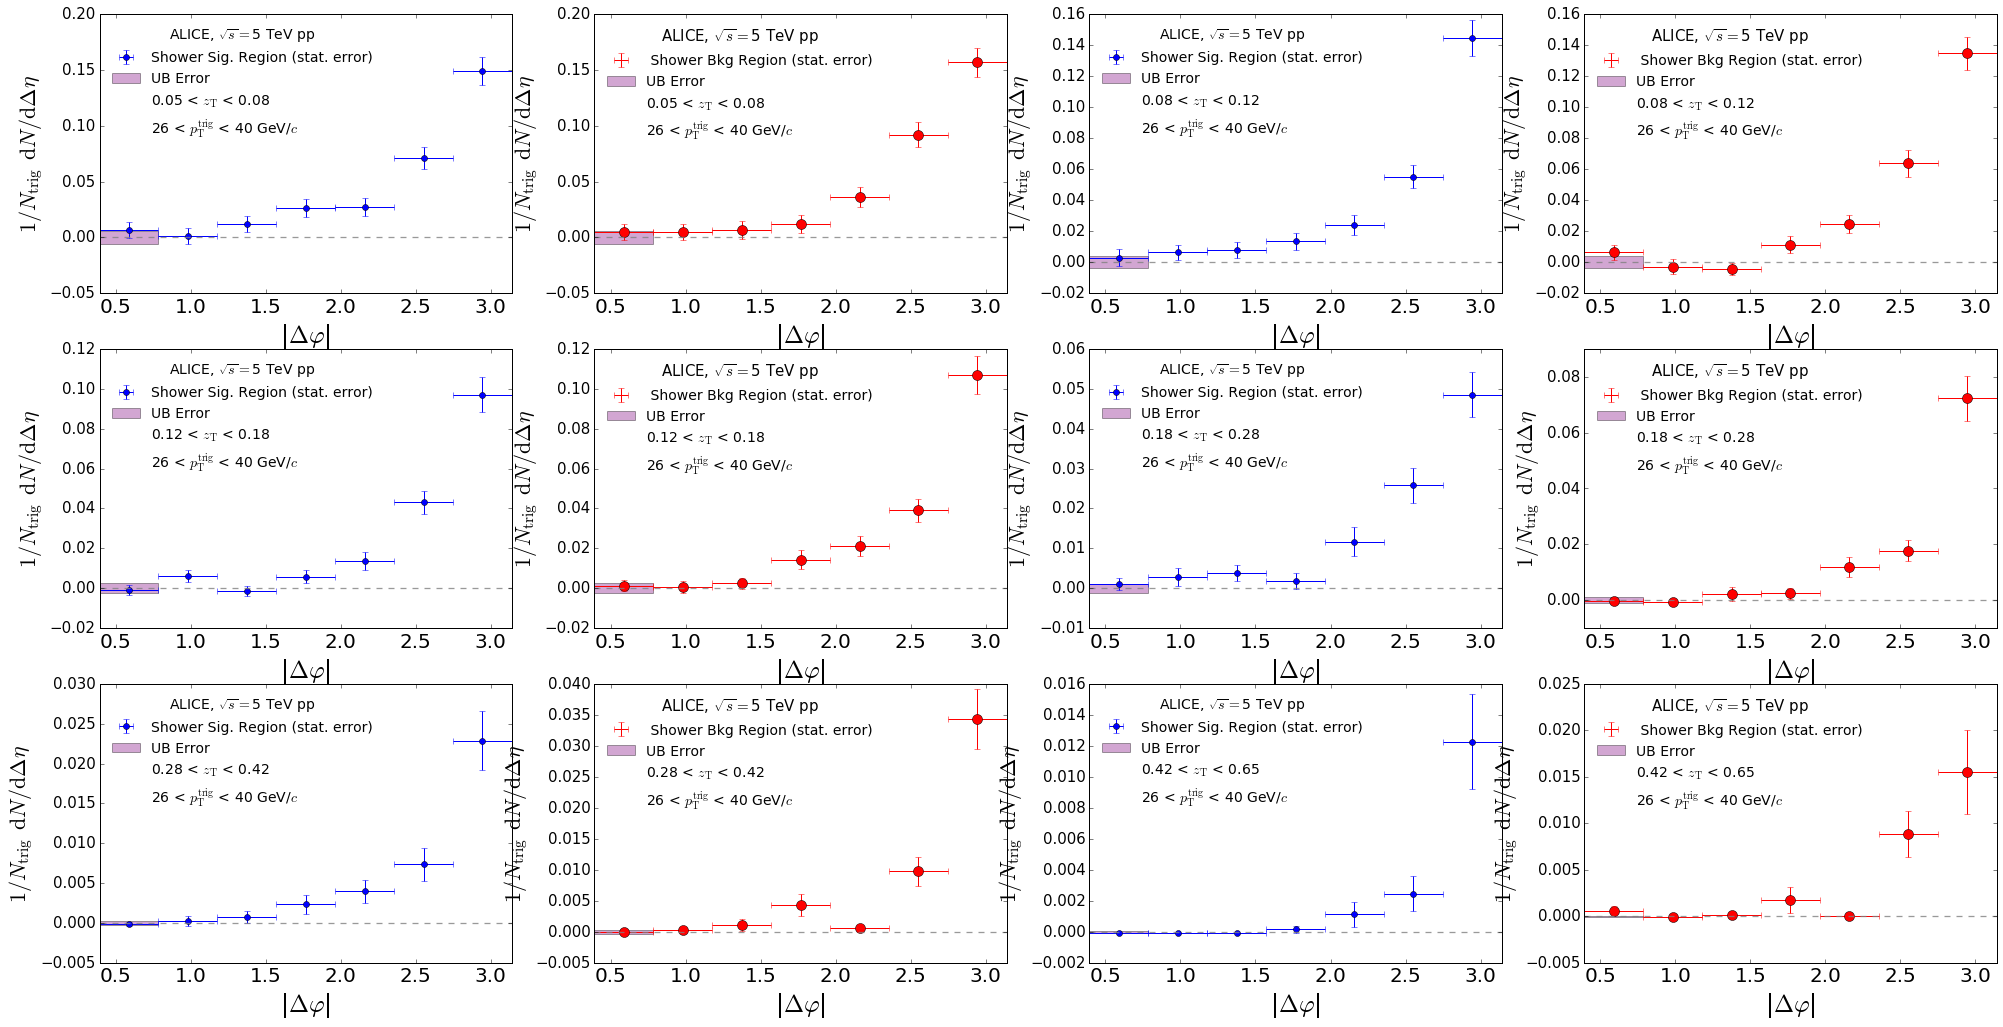

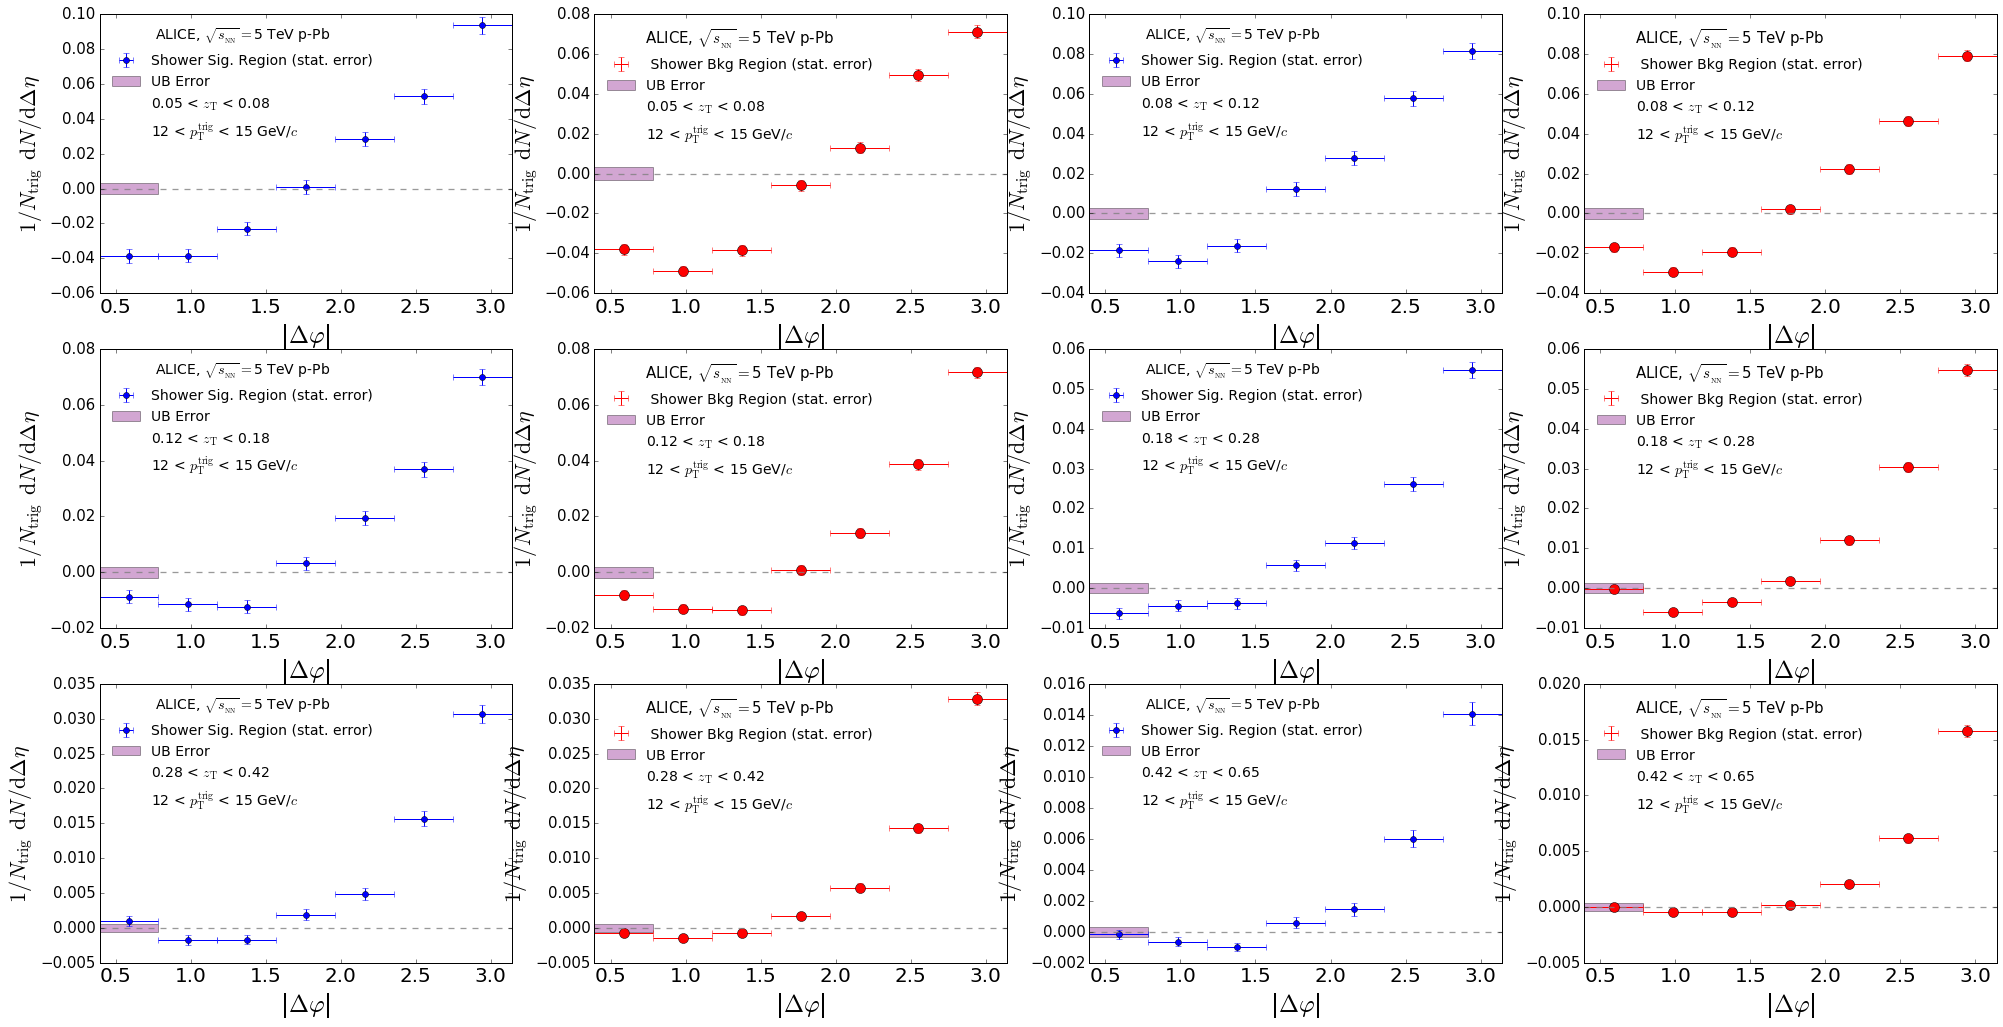

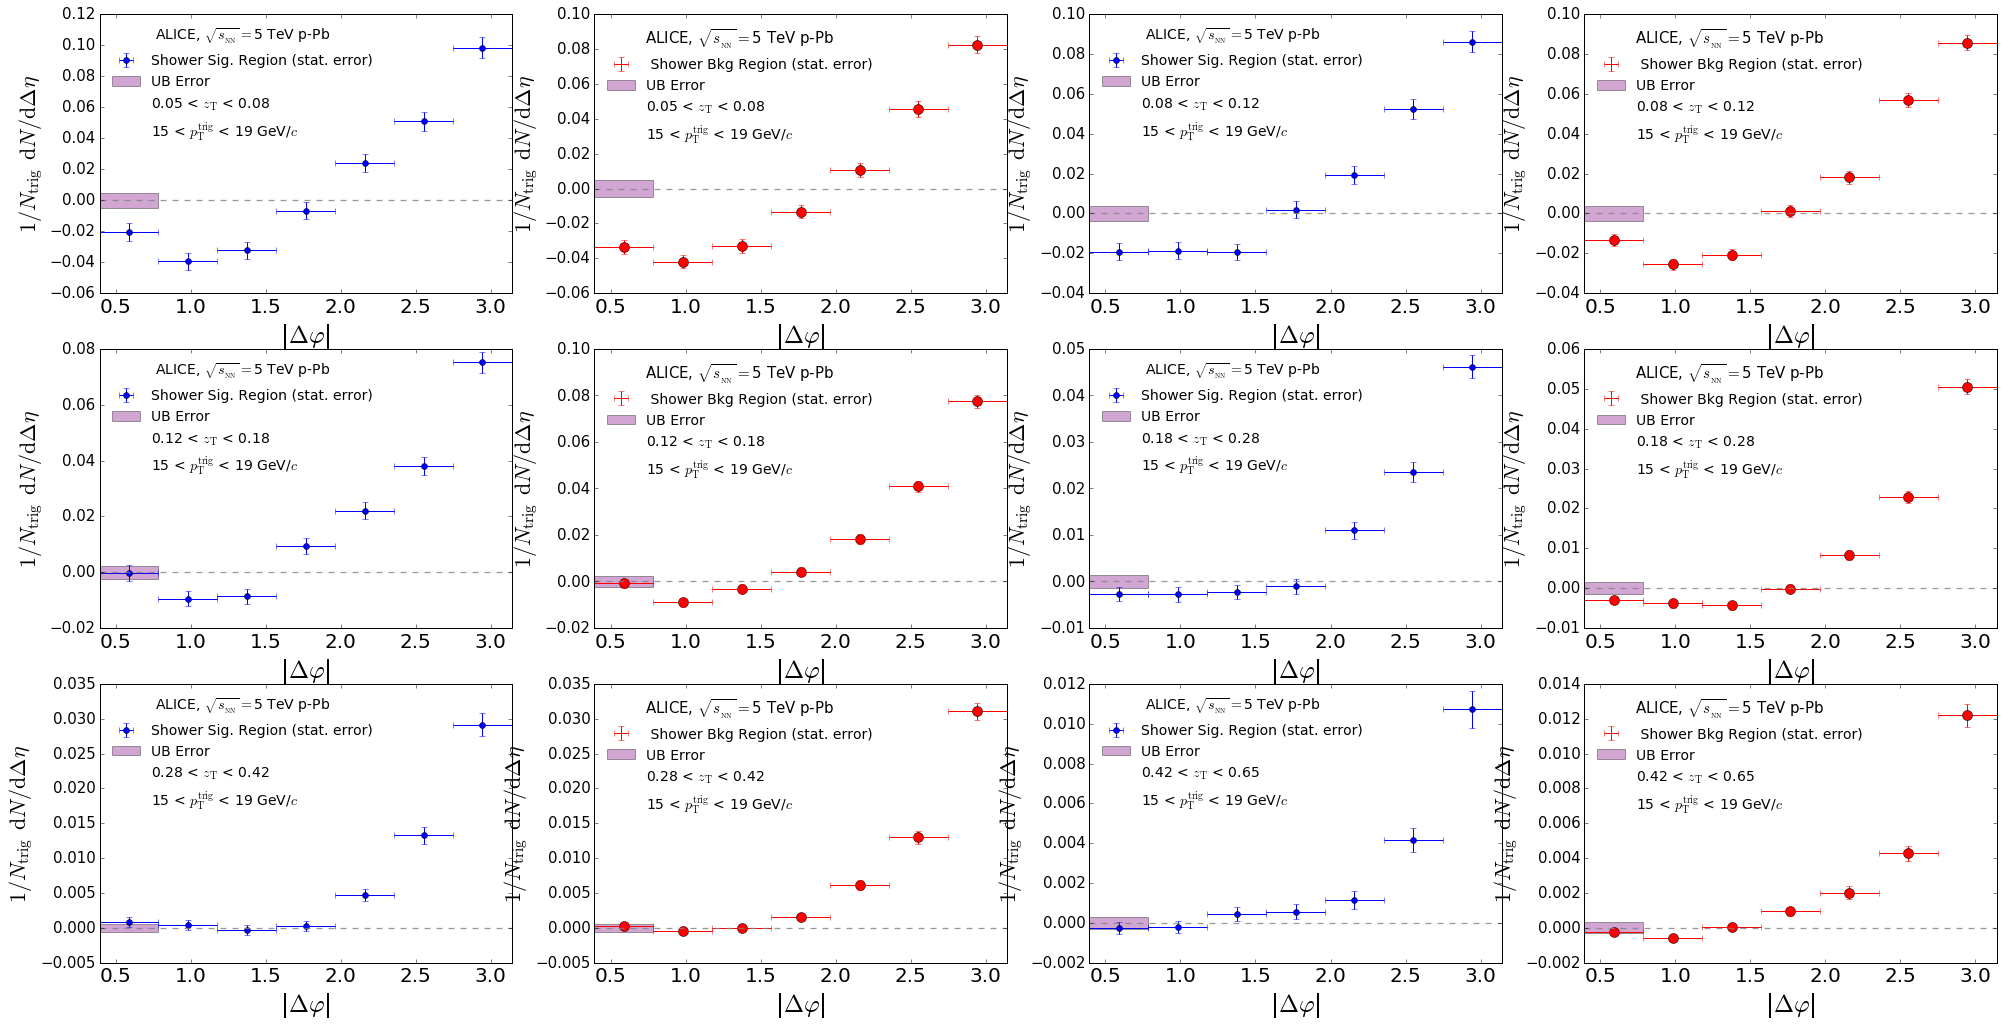

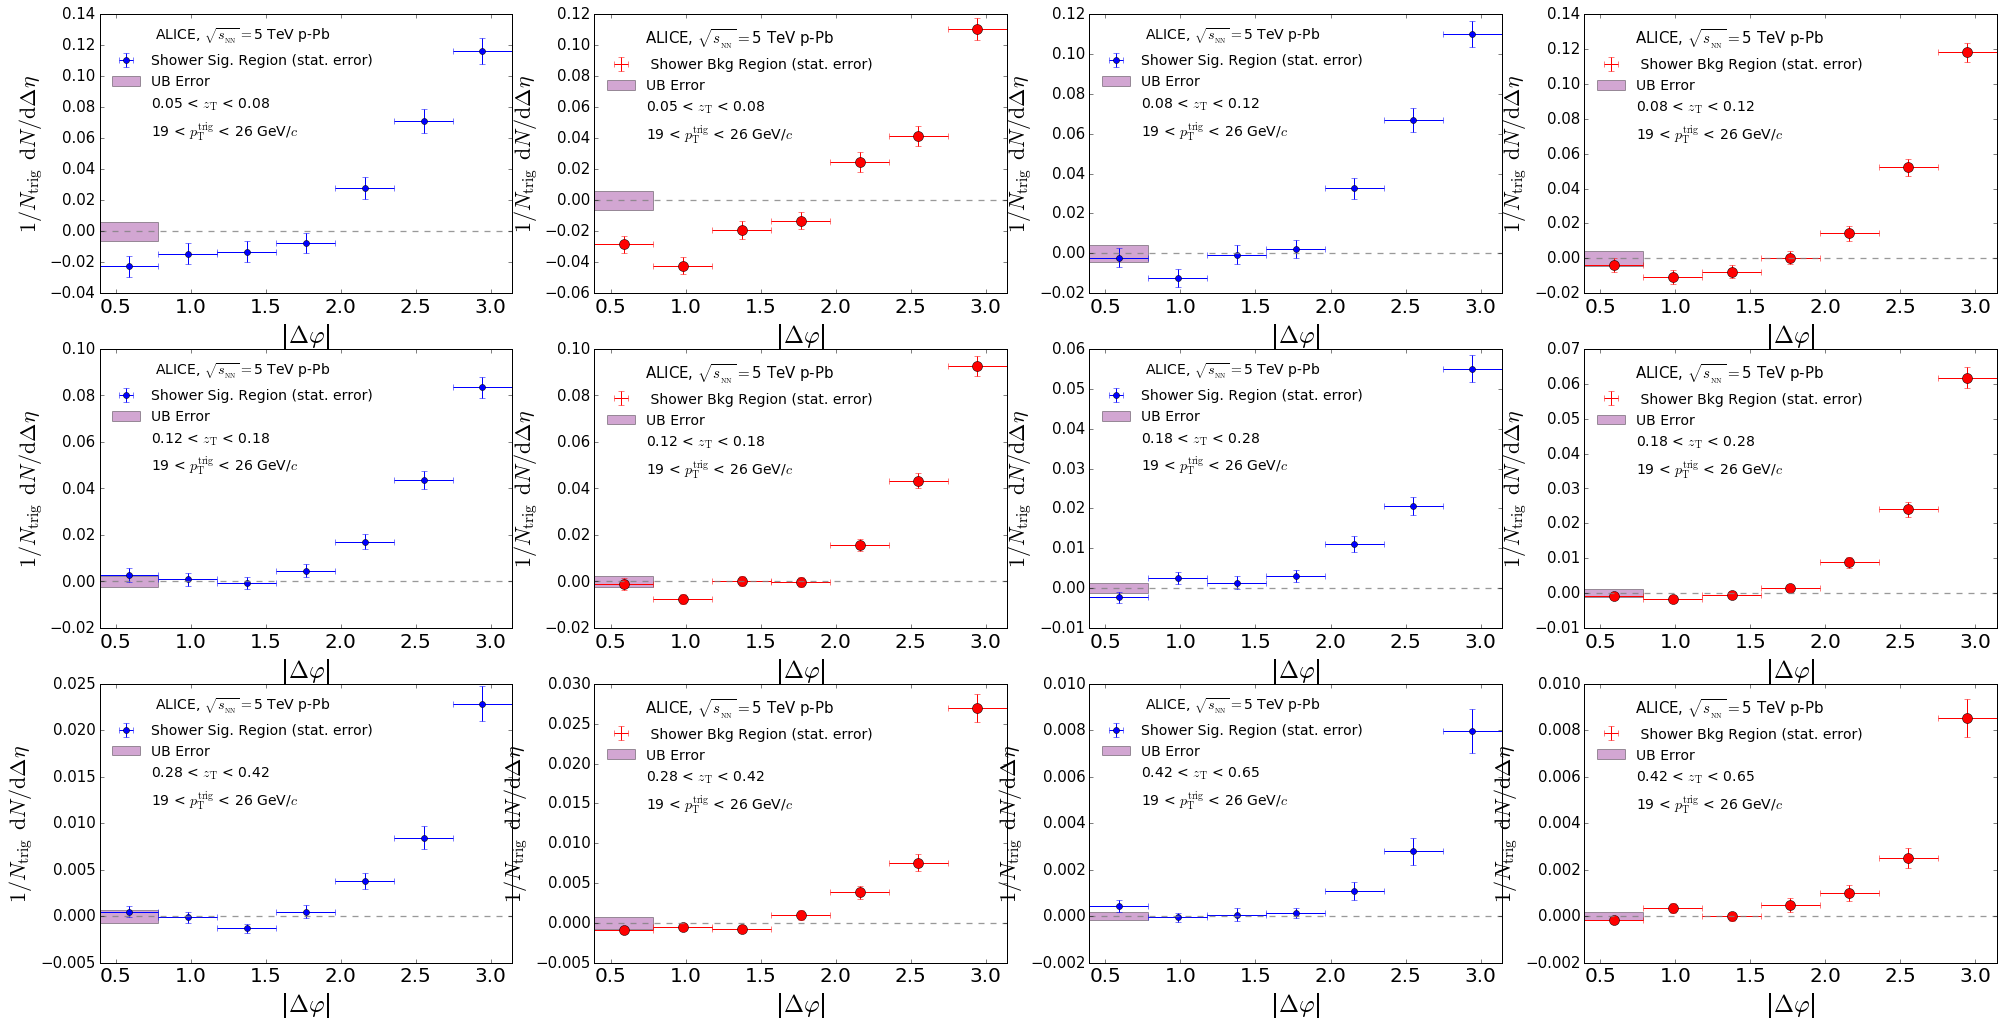

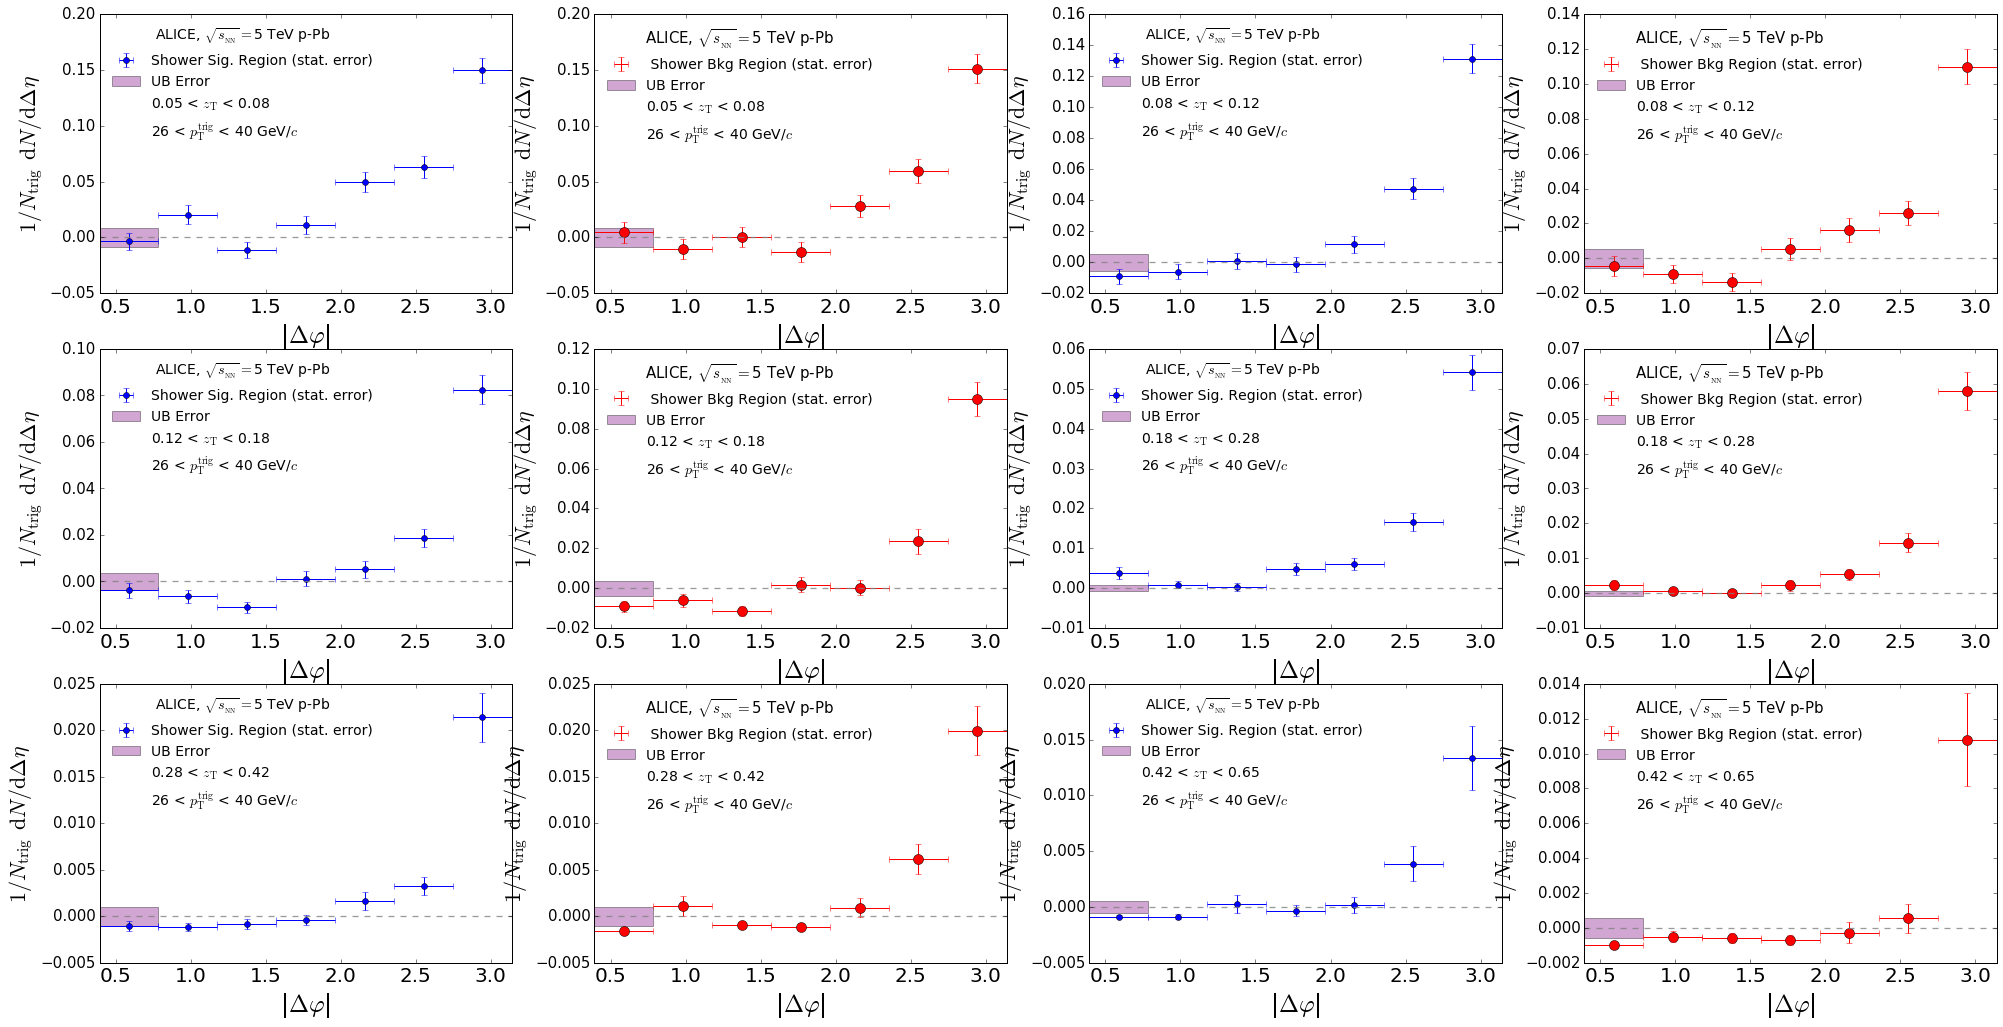

In [15]:
fsize = 20
for sys,ifile in zip(Systems,Files):
    
    if (sys == "p-Pb"):
        SYS = "pPb" #can't have -
    else:
        SYS=sys
        

    for ipt in range (N_pT_Bins):
        fig = plt.figure(figsize=(34,17))
        #if (ipt > 0): continue
        #ipt = ipt+2
        for izt in range (zT_offset,NzT+zT_offset):
            ztb = izt-zT_offset
            
            #sig
            if (NzT ==4):
                ax = fig.add_subplot(2,4,(2*ztb+1))
            elif (NzT ==6):
                ax = fig.add_subplot(3,4,(2*ztb+1))
            #ax.plot(delta_phi_centers,vars()["%s_CSR"%(SYS)][ipt][ztb],'bo',ms=10)
            s_plot = ax.errorbar(delta_phi_centers,vars()["%s_CSR"%(SYS)][ipt][ztb],xerr=phi_width,
                yerr=vars()["%s_CSR_Errors"%(SYS)][ipt][ztb],fmt='bo',ecolor='b',label='Signal Region (stat. error)')
            
            UE_Band = ax.fill_between(ue_error_bar,-vars()["%s_LE_Error"%(SYS)][ipt][ztb],
                vars()["%s_LE_Error"%(SYS)][ipt][ztb],facecolor='purple',alpha=0.35) 
            
            plt.axhline(y=0,color='gray',linestyle='--',linewidth=1.3,alpha=0.8)

            
            plt.xlabel(r'|$\Delta \varphi$|',fontsize=fsize+4)
            plt.xticks(fontsize=(fsize))
            plt.xlim((0.39269908169872414,3.14159))
            plt.ylabel(r'$1/N_{\mathrm{trig}} \: \: \mathrm{d}N/\mathrm{d}\Delta\eta$',fontsize=fsize+2)
            empt, = ax.plot([], [], ' ')
            empt2, = ax.plot([],[],' ')
            plt.yticks(fontsize=fsize-5)

            leg = ax.legend([s_plot,UE_Band,empt,empt2],['Shower Sig. Region (stat. error)',"UB Error",r'%1.2f < $z_\mathrm{T}$ < %1.2f'
                %(zTbins[izt],zTbins[izt+1]),r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c$'%(pTbins[ipt],pTbins[ipt+1])],
                loc='best',title = "Alice %s 5 TeV",fontsize=14,frameon=False,numpoints=1)
            
            if (sys == 'pp'):
                leg.set_title("ALICE, $\sqrt{s}=$5 TeV %s"%(sys))
            else:
                leg.set_title("ALICE, $\sqrt{s_{\mathrm{_{NN}}}}=$5 TeV %s"%(sys))                
            plt.setp(leg.get_title(),fontsize=14)


            #bkg
            if (NzT ==4):
                ax = fig.add_subplot(2,4,(2*ztb+2))
            elif (NzT ==6):
                ax = fig.add_subplot(3,4,(2*ztb+2))
                
            plt.xlabel(r'|$\Delta \varphi$|',fontsize=fsize+4)
            plt.xticks(fontsize=(fsize))
            plt.xlim((0.39269908169872414,3.14159))
            plt.ylabel(r'$1/N_{\mathrm{trig}} \: \: \mathrm{d}N/\mathrm{d}\Delta\eta$',fontsize=fsize+2)
            plt.yticks(fontsize=fsize-5)

            ax.plot(delta_phi_centers,vars()["%s_CBR"%(SYS)][ipt][ztb],'ro',ms=10)
            b_plot = ax.errorbar(delta_phi_centers,vars()["%s_CBR"%(SYS)][ipt][ztb],xerr=phi_width,yerr=vars()["%s_CBR_Errors"%(SYS)][ipt][ztb],fmt=None,ecolor='r')
            UE_Band = ax.fill_between(ue_error_bar,-vars()["%s_LE_Error"%(SYS)][ipt][ztb],vars()["%s_LE_Error"%(SYS)][ipt][ztb],facecolor='purple',alpha=0.35) 
            plt.axhline(y=0,color='gray',linestyle='--',linewidth=1.3,alpha=0.8)
            
            
            leg = ax.legend([b_plot,UE_Band,empt,empt2],[' Shower Bkg Region (stat. error)',"UB Error",r'%1.2f < $z_\mathrm{T}$ < %1.2f'
                %(zTbins[izt],zTbins[izt+1]),r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c$'%(pTbins[ipt],pTbins[ipt+1])],
                loc='best',fontsize=14,frameon=False,numpoints=1)
            if (sys == 'pp'):
                leg.set_title("ALICE, $\sqrt{s}=$5 TeV %s"%(sys))
            else:
                leg.set_title("ALICE, $\sqrt{s_{\mathrm{_{NN}}}}=$5 TeV %s"%(sys))
            plt.setp(leg.get_title(),fontsize=15)
            fig.savefig('pics/%s/%s_%s_Gamma_hadron_UE_sub_zT_%i.pdf'%(Shower,Shower_sys,izt), bbox_inches='tight')

NameError: name 'shower' is not defined

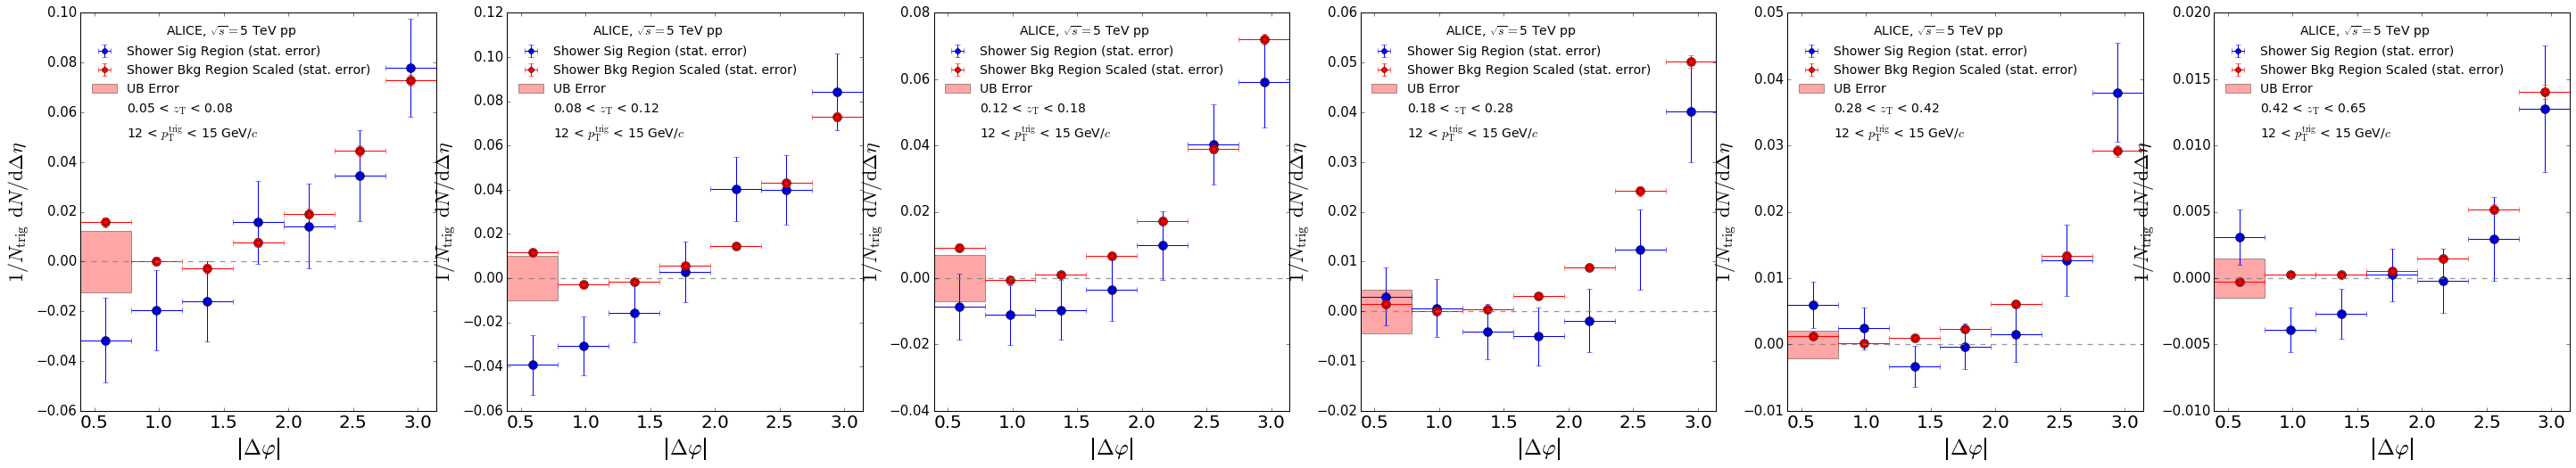

In [192]:
for sys,ifile in zip(Systems,Files):
    
    SYS=sys
    
    if (sys == "p-Pb"):
        SYS = "pPb" #can't have -
        sys_color = 'blue'
    elif(sys == "pp"):
        sys_color = 'red'
    elif(sys == "MC"):
         sys_color = 'green'
        
    
    for ipt in range (N_pT_Bins):
        fig = plt.figure(figsize=(50,8))
        #if (ipt > 0): continue
        #ipt = ipt+2
        for izt in range (zT_offset,NzT+zT_offset):
            ztb = izt-zT_offset
            
            if (NzT == 4):
                ax = fig.add_subplot(1,4,(ztb+1))
            elif (NzT == 6):
                ax = fig.add_subplot(1,6,(ztb+1))
            
            ax.plot(delta_phi_centers,vars()["%s_CSR"%(SYS)][ipt][ztb],'bo',color="blue",ms=10)
            s_plot = ax.errorbar(delta_phi_centers,vars()["%s_CSR"%(SYS)][ipt][ztb],xerr=phi_width,
                yerr=vars()["%s_CSR_Errors"%(SYS)][ipt][ztb],fmt='bo',ecolor="blue",label='Signal Region (stat. error)')
            
            ax.plot(delta_phi_centers,vars()["%s_CBR"%(SYS)][ipt][ztb]*(1-purity[ipt]),'ro',color="red",ms=10) #Scale UE Error by purity!
            b_plot = ax.errorbar(delta_phi_centers,vars()["%s_CBR"%(SYS)][ipt][ztb]*(1-purity[ipt]),xerr=phi_width,
                yerr=vars()["%s_CBR_Errors"%(SYS)][ipt][ztb]*(1-purity[ipt]),fmt='ro',ecolor="red",label='Background Region (stat. error)')
            
            UE_Band = ax.fill_between(ue_error_bar,-vars()["%s_LE_Error"%(SYS)][ipt][ztb],vars()["%s_LE_Error"%(SYS)][ipt][ztb],facecolor=sys_color,alpha=0.35) 
            plt.axhline(y=0,color='gray',linestyle='--',linewidth=1.3,alpha=0.8)


            plt.xlabel(r'|$\Delta \varphi$|',fontsize=fsize+4)
            plt.xticks(fontsize=(fsize))
            plt.xlim((0.39269908169872414,3.14159))
            plt.ylabel(r'$1/N_{\mathrm{trig}} \: \: \mathrm{d}N/\mathrm{d}\Delta\eta$',fontsize=fsize+2)
            #plt.ylim((0,1.2*max(Sig_LE_Phi_Array)))
            empt, = ax.plot([], [], ' ')
            empt2, = ax.plot([],[],' ')
            plt.yticks(fontsize=fsize-5)

            leg = ax.legend([s_plot,b_plot,UE_Band,empt,empt2],['Shower Sig Region (stat. error)','Shower Bkg Region Scaled (stat. error)',
                "UB Error",r'%1.2f < $z_\mathrm{T}$ < %1.2f'%(zTbins[izt],zTbins[izt+1]),r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c$'%(pTbins[ipt],pTbins[ipt+1])],
                loc='best',title = "Alice %s 5 TeV",fontsize=14,frameon=False,numpoints=1)
            if (sys == 'pp'):
                leg.set_title("ALICE, $\sqrt{s}=$5 TeV %s"%(sys))
            else:
                leg.set_title("ALICE, $\sqrt{s_{\mathrm{_{NN}}}}=$5 TeV %s"%(sys))                
            plt.setp(leg.get_title(),fontsize=14)
        fig.savefig('pics/%s_%s_Region_Overlays_UE_sub_pT_%i.pdf'%(shower,sys,ipt), bbox_inches='tight')

# Purity Scaling + Correlated Subtraction

## Subtraction: $ C_S = \frac{C_{SR} - (1-p) C_{BR}}{p} $

In [17]:
for ipt in range (N_pT_Bins):
    #if (ipt > 0): continue
    pp_CSR[ipt] = (pp_CSR[ipt] - (1-purity[ipt])*pp_CBR[ipt])/purity[ipt]
    pPb_CSR[ipt] = (pPb_CSR[ipt] - (1-purity[ipt])*pPb_CBR[ipt])/purity[ipt]

    pp_CSR_Errors[ipt] = pp_CSR_Errors[ipt]/purity[ipt]
    pPb_CSR_Errors[ipt] = pPb_CSR_Errors[ipt]/purity[ipt]

    pp_LE_Error[ipt] = pp_LE_Error[ipt]/purity[ipt]
    pPb_LE_Error[ipt] = pPb_LE_Error[ipt]/purity[ipt]

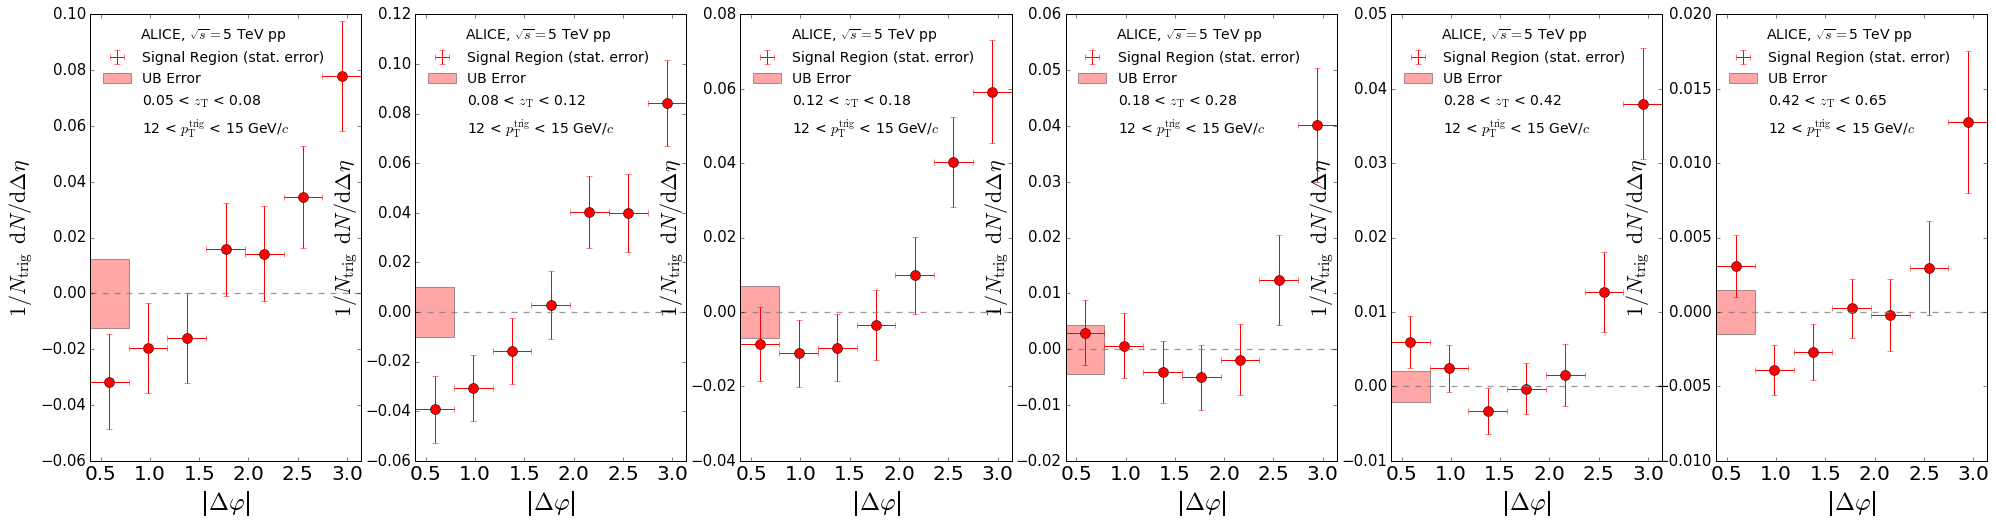

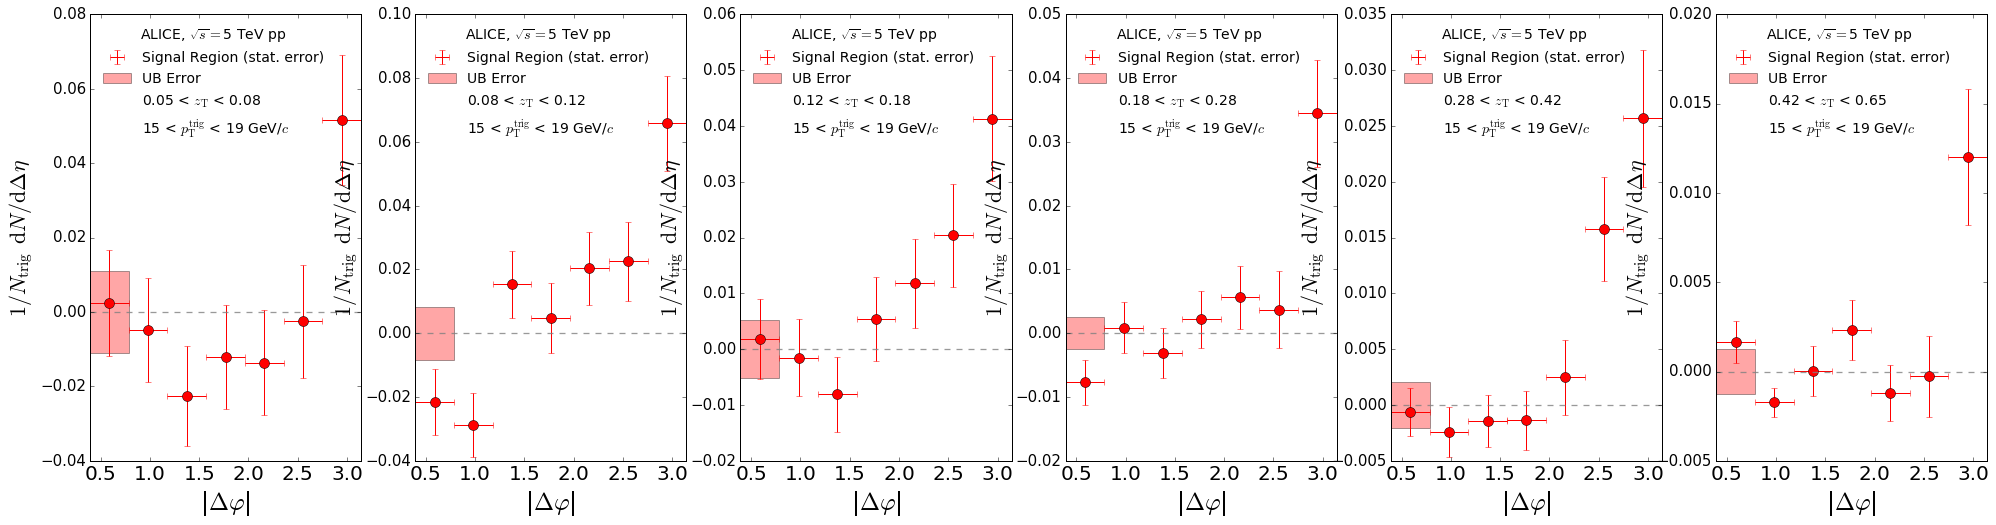

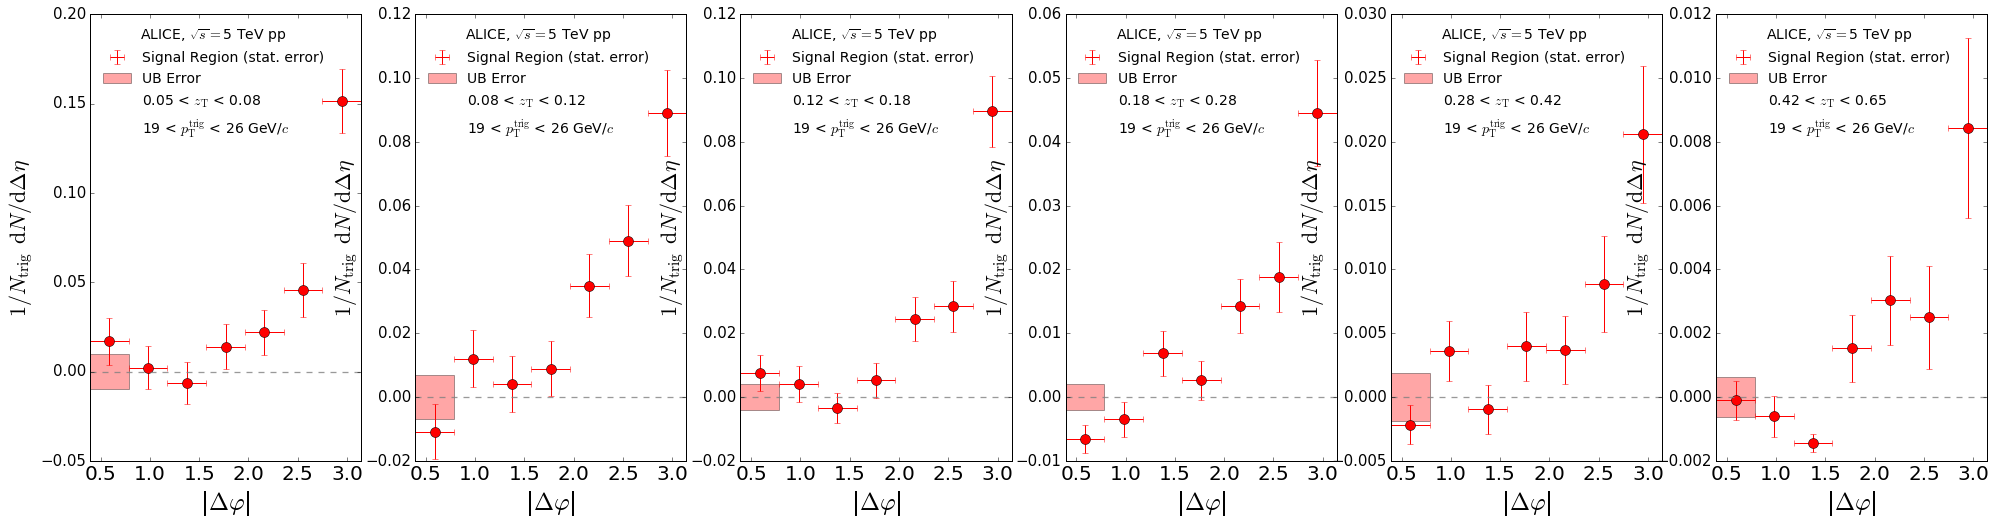

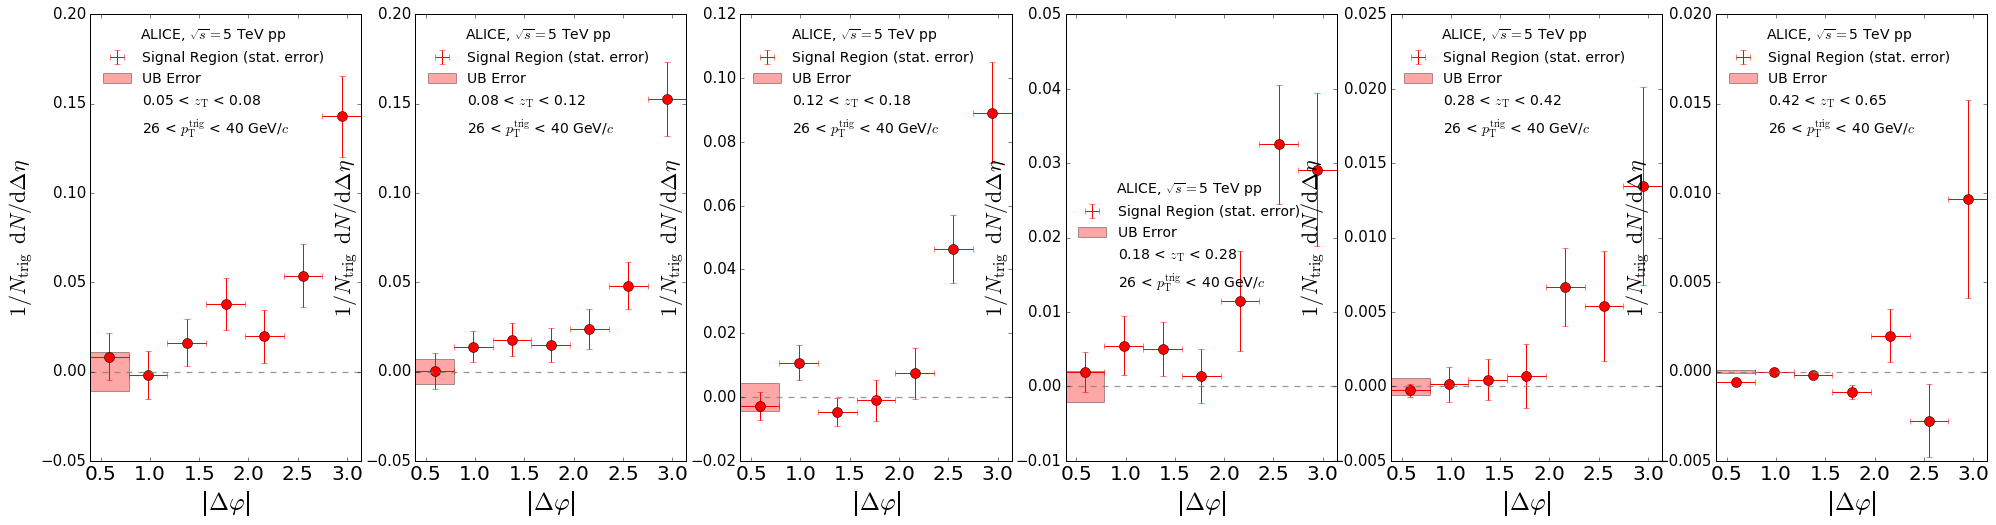

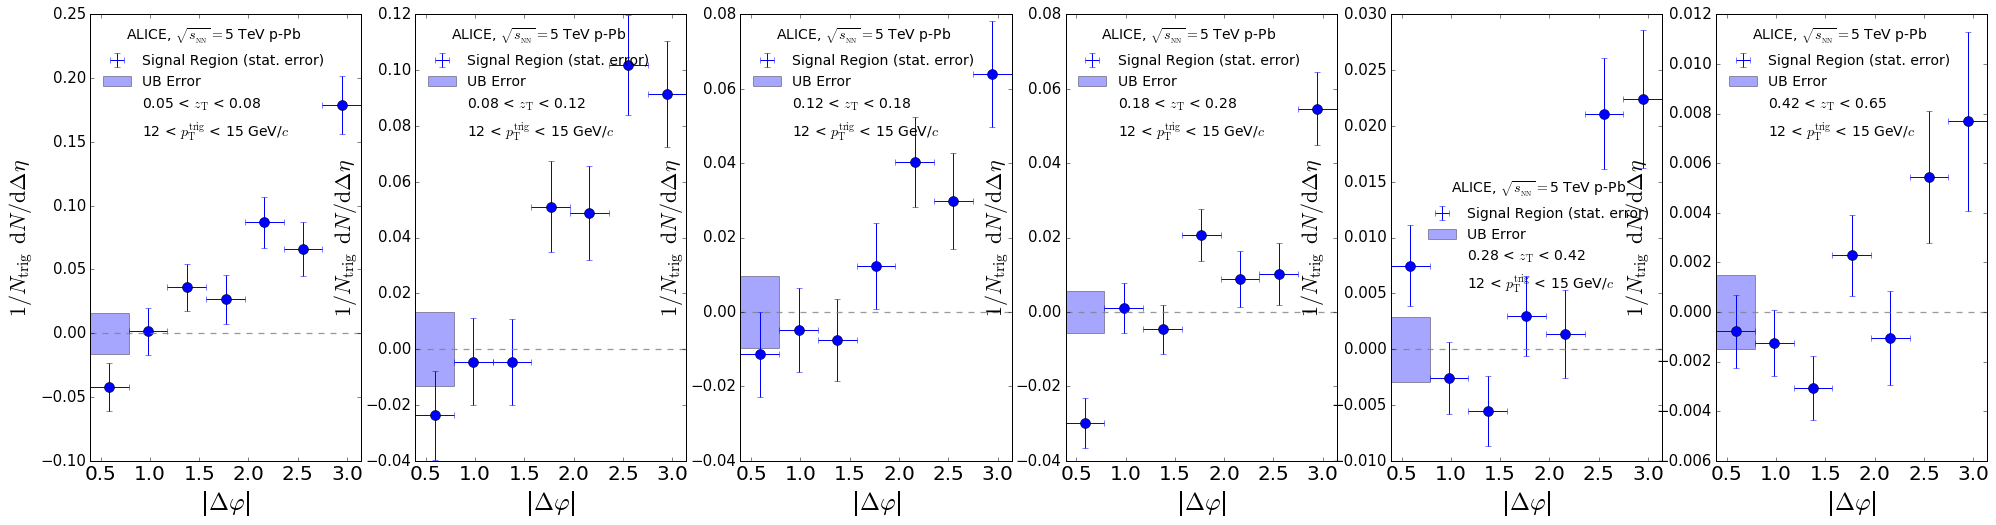

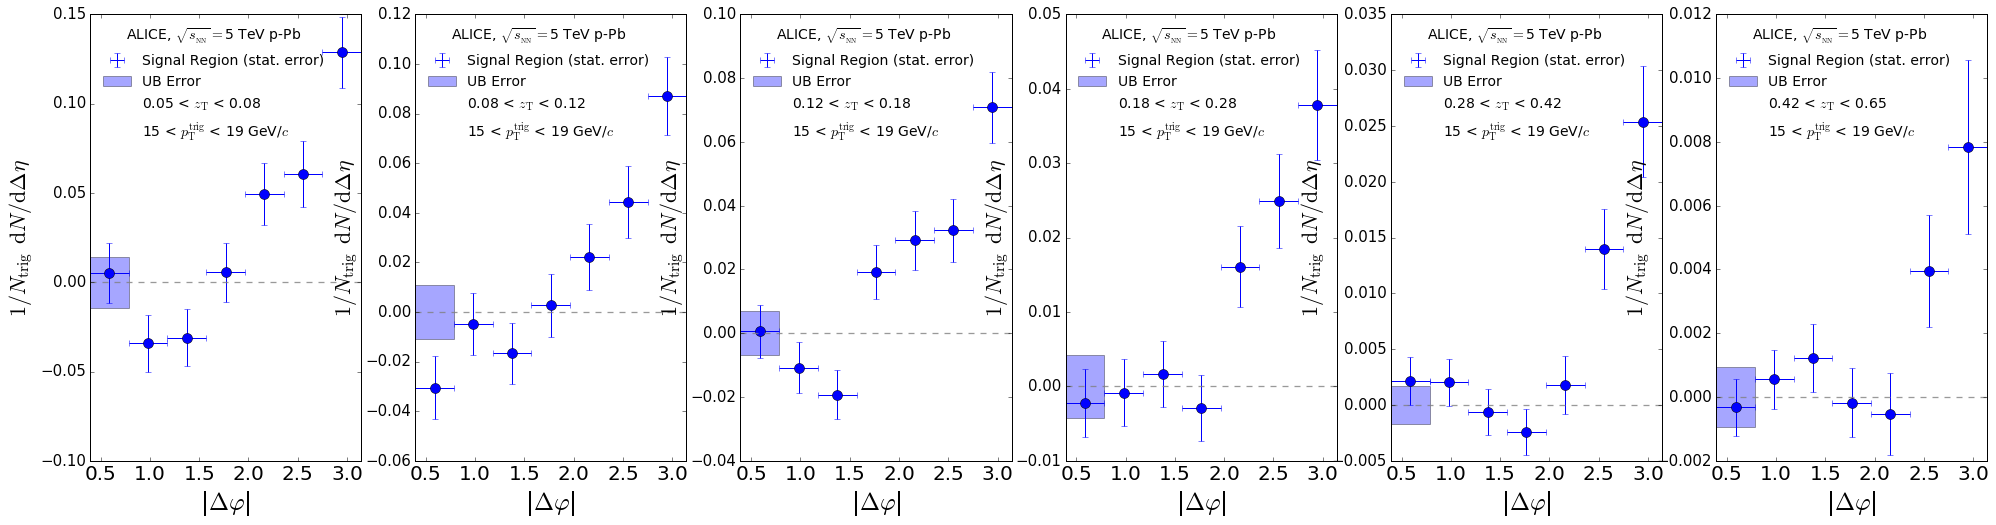

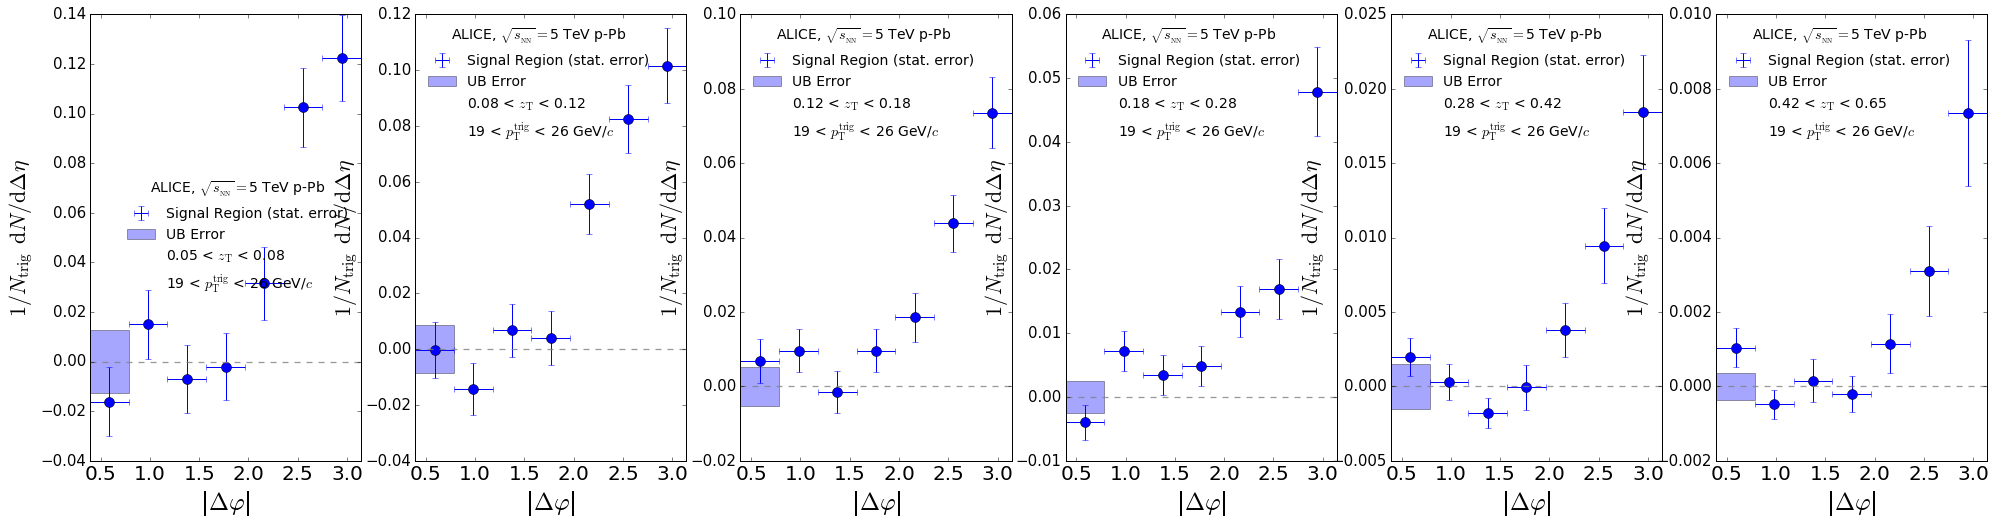

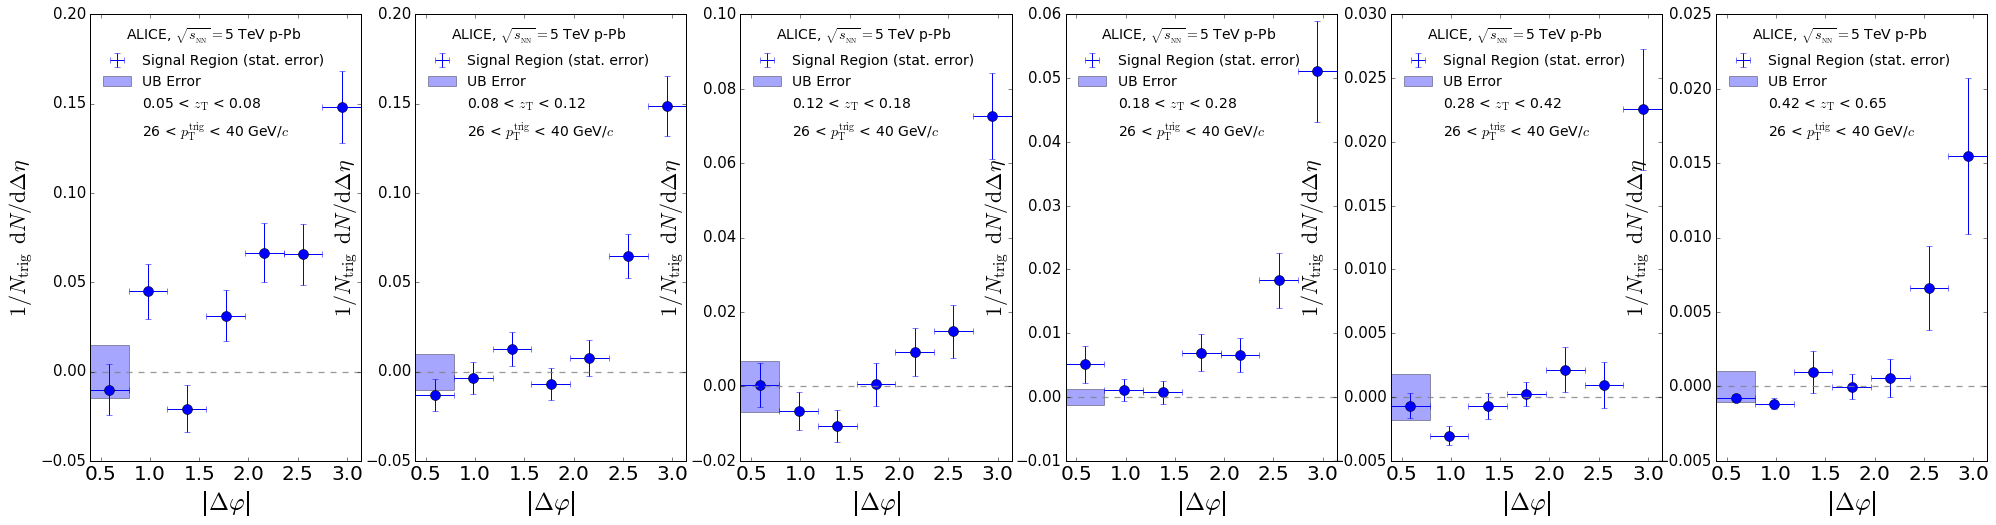

In [191]:
for sys,ifile in zip(Systems,Files):
    
    SYS=sys
    
    if (sys == "p-Pb"):
        SYS = "pPb" #can't have -
        sys_color = 'blue'
    elif(sys == "pp"):
        sys_color = 'red'
    elif(sys == "MC"):
         sys_color = 'green'
         
    for ipt in range (N_pT_Bins):
        fig = plt.figure(figsize=(34,8))
        #if (ipt > 0): continue
        #ipt = ipt+2
        for izt in range (zT_offset,NzT+zT_offset):
            ztb = izt-zT_offset
            
            if (NzT == 4):
                ax = fig.add_subplot(1,4,(ztb+1))
            elif (NzT == 6):
                ax = fig.add_subplot(1,6,(ztb+1))
            
            ax.plot(delta_phi_centers,vars()["%s_CSR"%(SYS)][ipt][ztb],'bo',color=sys_color,ms=10)
            s_plot = ax.errorbar(delta_phi_centers,vars()["%s_CSR"%(SYS)][ipt][ztb],xerr=phi_width,
                yerr=vars()["%s_CSR_Errors"%(SYS)][ipt][ztb],fmt=None,ecolor=sys_color,label='Signal Region (stat. error)')
            UE_Band = ax.fill_between(ue_error_bar,-vars()["%s_LE_Error"%(SYS)][ipt][ztb],vars()["%s_LE_Error"%(SYS)][ipt][ztb],facecolor=sys_color,alpha=0.35) 
            plt.axhline(y=0,color='gray',linestyle='--',linewidth=1.3,alpha=0.8)


            plt.xlabel(r'|$\Delta \varphi$|',fontsize=fsize+4)
            plt.xticks(fontsize=(fsize))
            plt.xlim((0.39269908169872414,3.14159))
            plt.ylabel(r'$1/N_{\mathrm{trig}} \: \: \mathrm{d}N/\mathrm{d}\Delta\eta$',fontsize=fsize+2)
            #plt.ylim((0,1.2*max(Sig_LE_Phi_Array)))
            empt, = ax.plot([], [], ' ')
            empt2, = ax.plot([],[],' ')
            plt.yticks(fontsize=fsize-5)

            leg = ax.legend([s_plot,UE_Band,empt,empt2],['Signal Region (stat. error)',"UB Error",r'%1.2f < $z_\mathrm{T}$ < %1.2f'
                %(zTbins[izt],zTbins[izt+1]),r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c$'%(pTbins[ipt],pTbins[ipt+1])],
                loc='best',title = "Alice %s 5 TeV",fontsize=14,frameon=False,numpoints=1)
            if (sys == 'pp'):
                leg.set_title("ALICE, $\sqrt{s}=$5 TeV %s"%(sys))
            else:
                leg.set_title("ALICE, $\sqrt{s_{\mathrm{_{NN}}}}=$5 TeV %s"%(sys))                
            plt.setp(leg.get_title(),fontsize=14)
        fig.savefig('pics/%s_%s_CSR_pT_%i.pdf'%(Shower,sys,ipt), bbox_inches='tight')

# Overlay pp and p-Pb

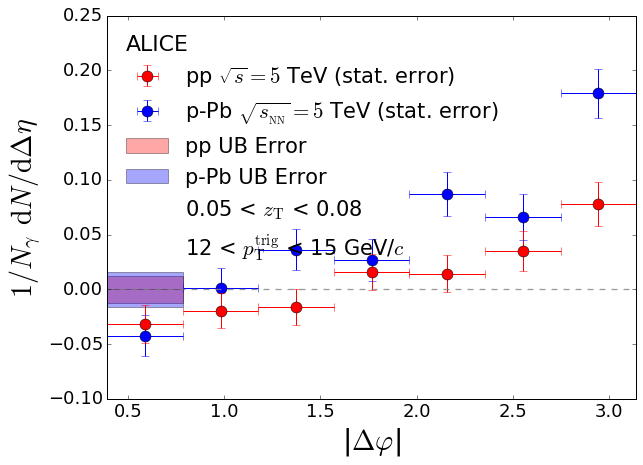

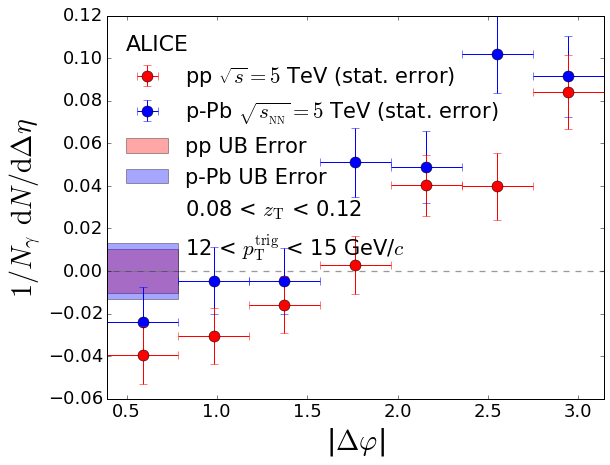

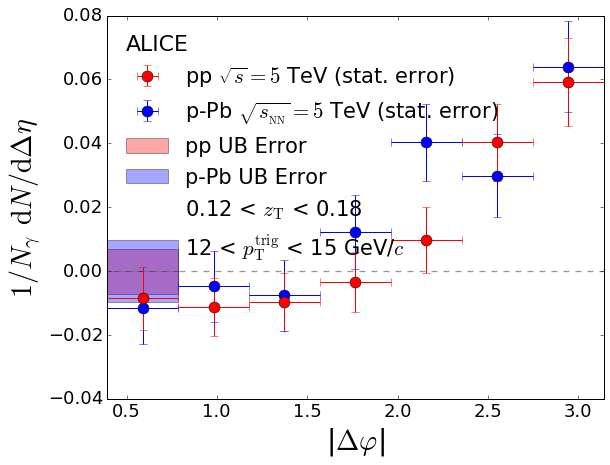

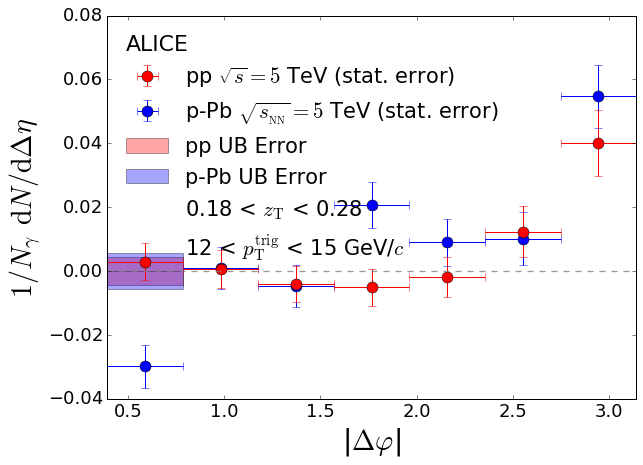

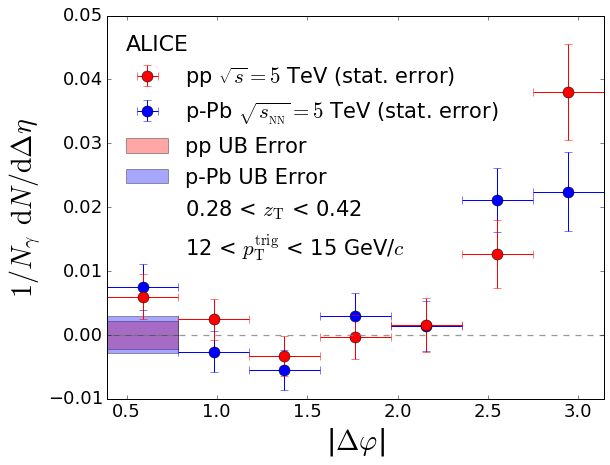

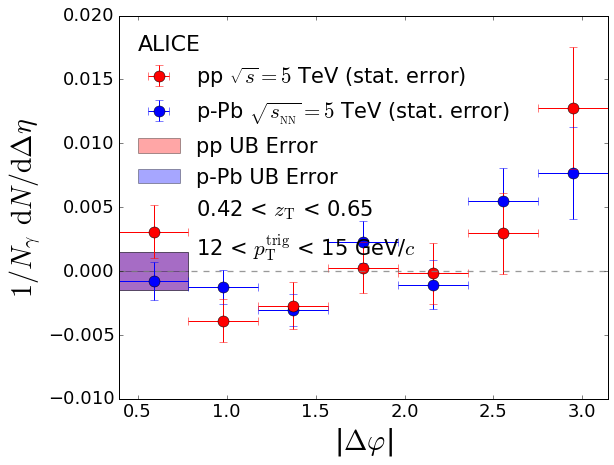

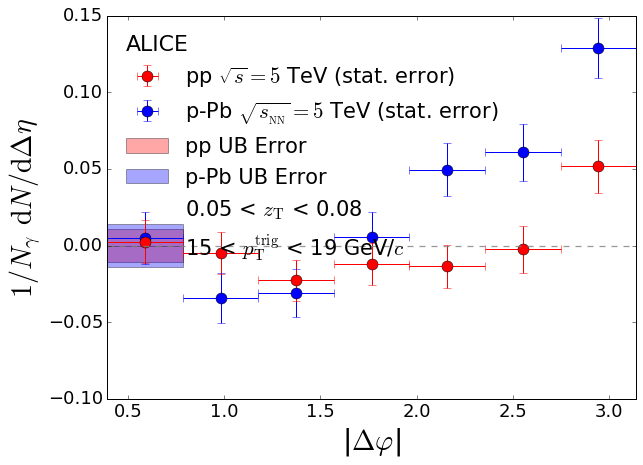

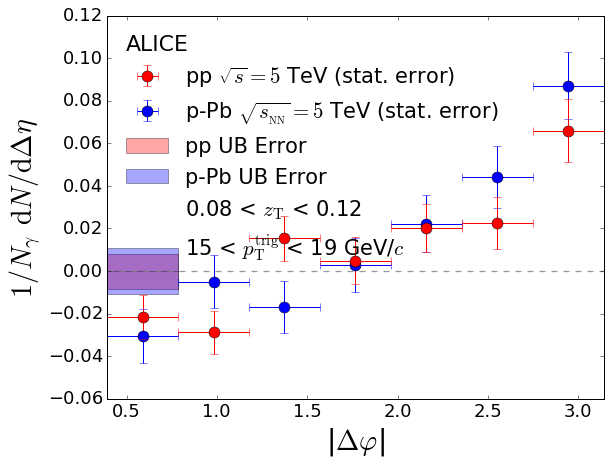

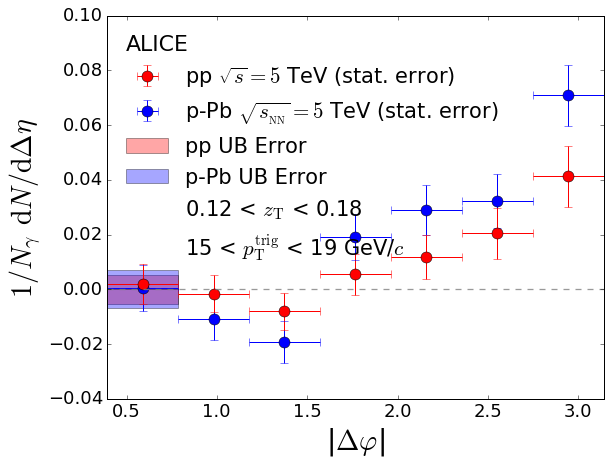

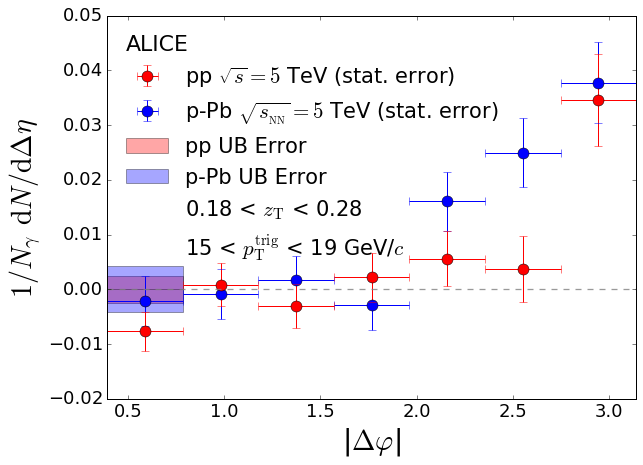

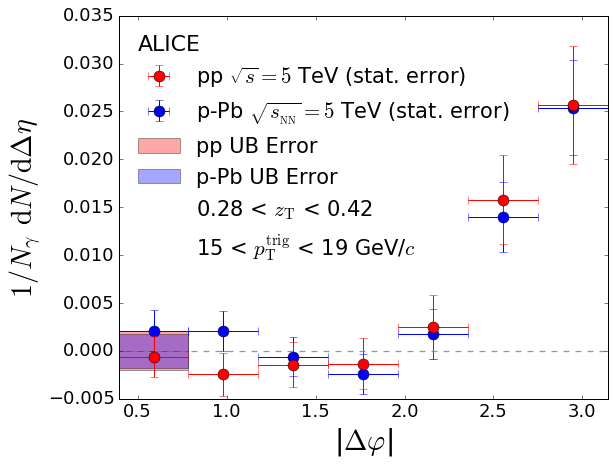

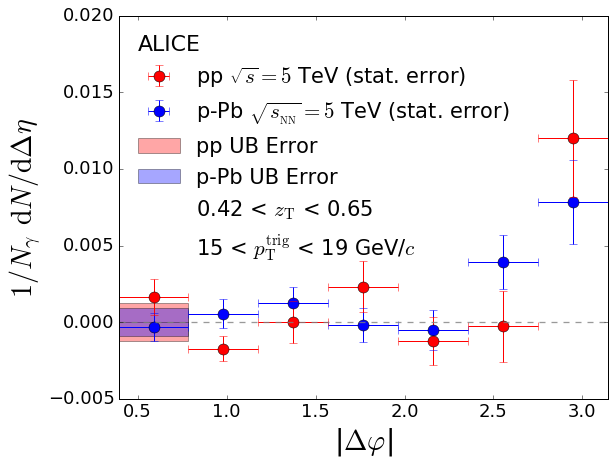

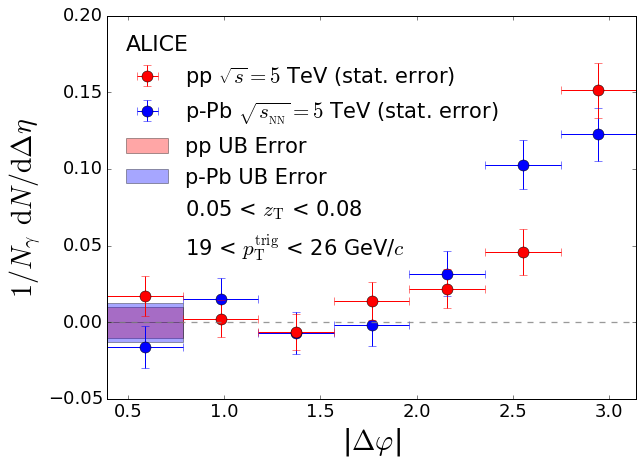

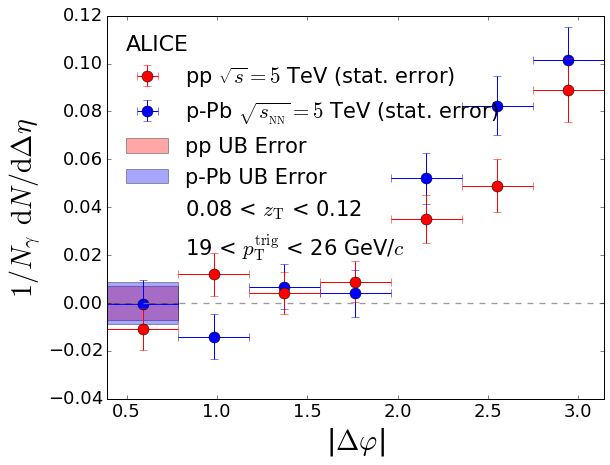

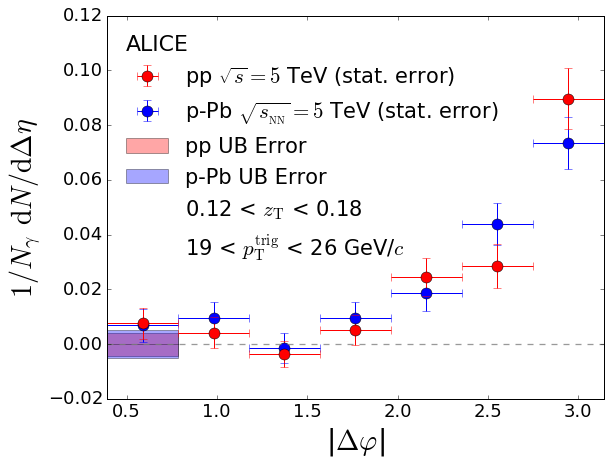

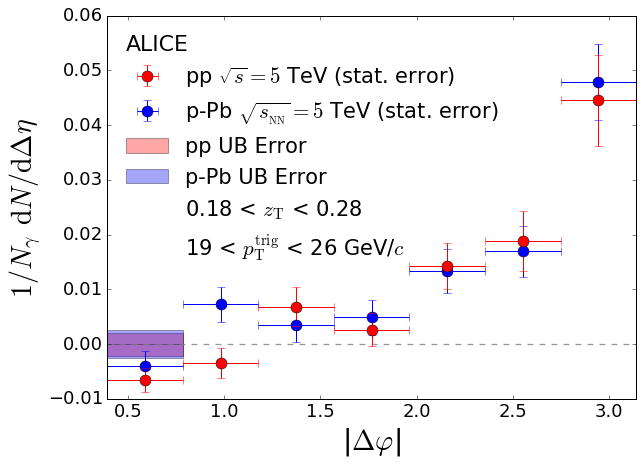

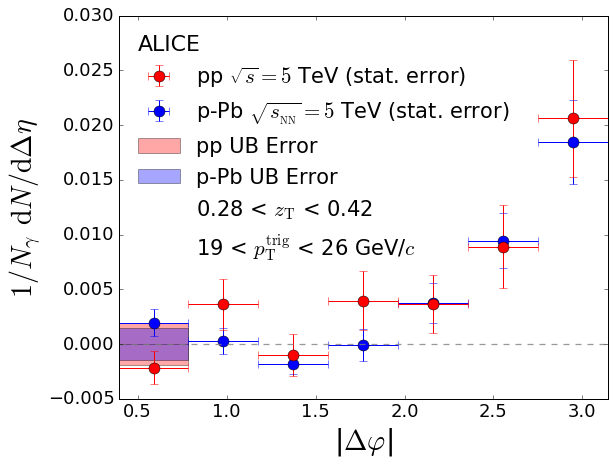

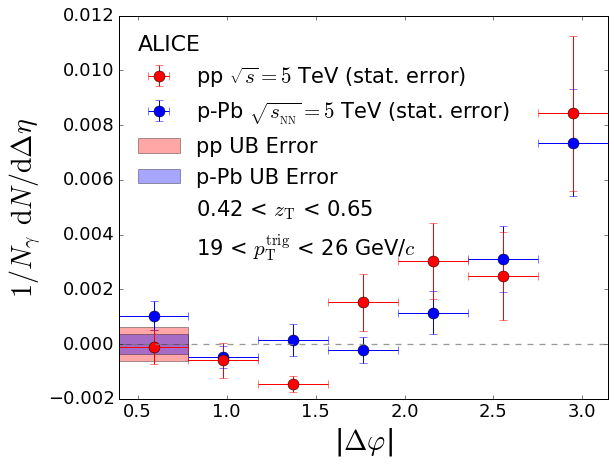

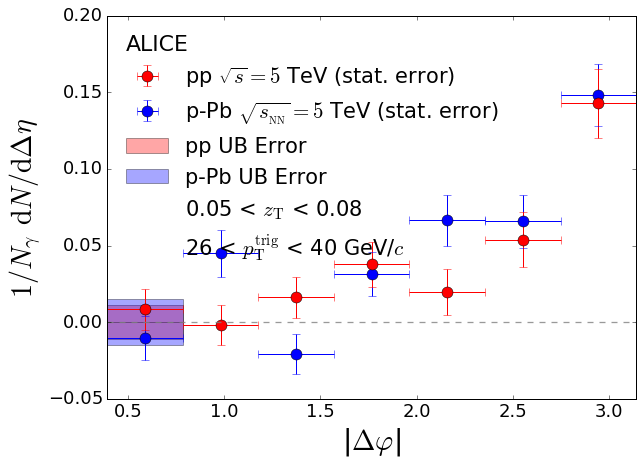

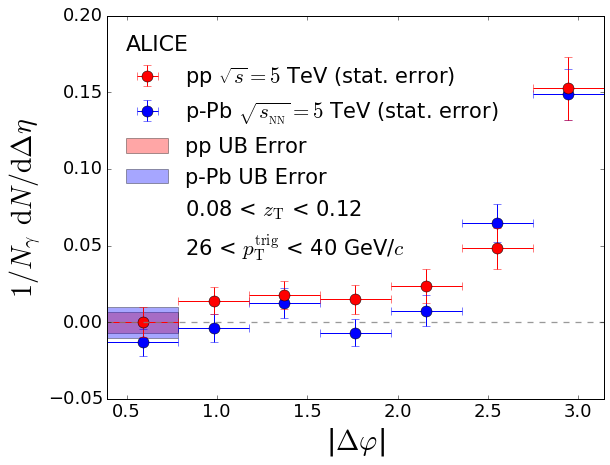

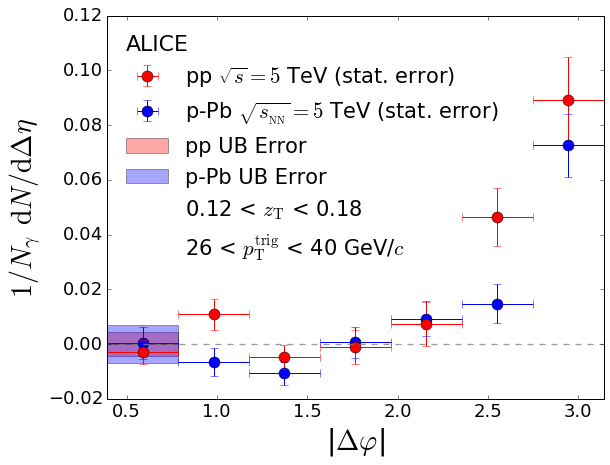

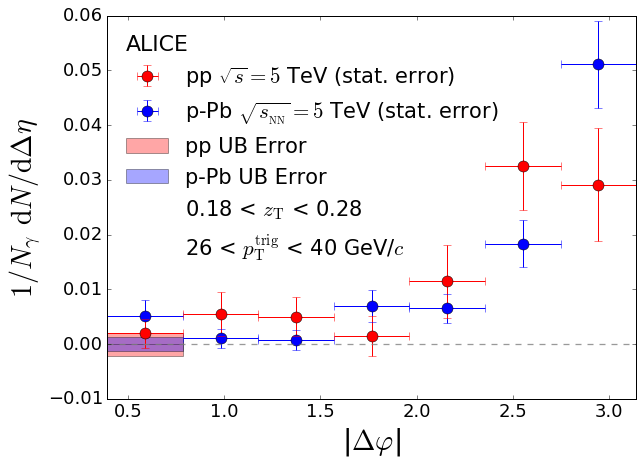

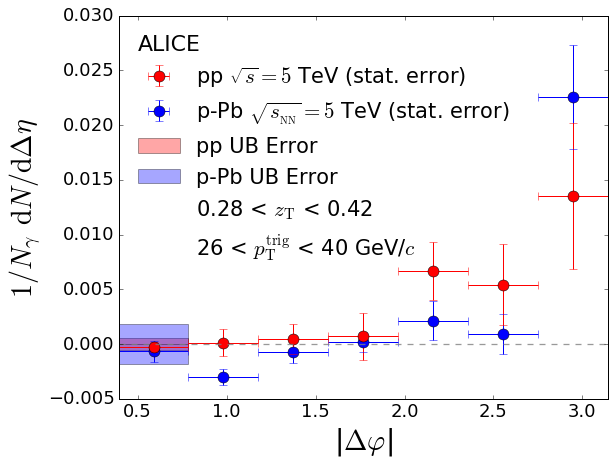

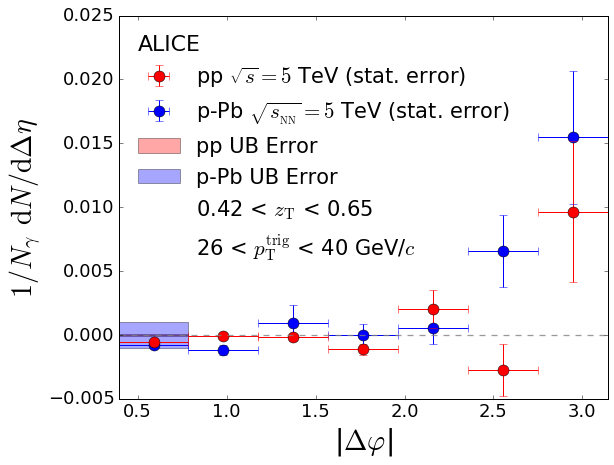

In [19]:
for ipt in range (N_pT_Bins):
    #if (ipt > 0): continue
    #ipt = ipt+2
    #plt.figure(figsize=(10,7))
    for izt in range (zT_offset,NzT+zT_offset):
        fig = plt.figure(figsize=(24,12))
        ztb = izt-zT_offset

        if (NzT ==4):
            ax = fig.add_subplot(2,2,ztb+1)
        elif (NzT ==6):
            ax = fig.add_subplot(2,3,ztb+1)

        pPb = plt.errorbar(delta_phi_centers,pPb_CSR[ipt][ztb],xerr=phi_width,yerr=pPb_CSR_Errors[ipt][ztb],fmt='bo',capsize=4,markersize=11)
        pp = plt.errorbar(delta_phi_centers,pp_CSR[ipt][ztb],xerr=phi_width,yerr=pp_CSR_Errors[ipt][ztb],fmt='ro',capsize=4,markersize=11)
        
        if(Use_MC):
            MC = plt.errorbar(delta_phi_centers,MC_CSR[ipt][ztb],xerr=phi_width,yerr=MC_CSR_Errors[ipt][ztb],fmt='go',capsize=4,markersize=11)



        plt.xlabel(r'|$\Delta \varphi$|',fontsize=28)
        plt.xticks(fontsize=18)
        plt.xlim((0.39269908169872414,3.14159))
        plt.ylabel(r'$1/N_{\gamma} \: \: \mathrm{d}N/\mathrm{d}\Delta \eta$',fontsize=28)
        plt.yticks(fontsize=18)
        plt.axhline(y=0,color='gray',linestyle='--',linewidth=1.3,alpha=0.8)        
        
        pp_UE = ax.fill_between(ue_error_bar,-pp_LE_Error[ipt][ztb],pp_LE_Error[ipt][ztb],facecolor='red',alpha=0.35) #Other for pp
        pPb_UE = ax.fill_between(ue_error_bar,-pPb_LE_Error[ipt][ztb],pPb_LE_Error[ipt][ztb],facecolor='blue',alpha=0.35)#One for p-Pb
        MC_UE = ax.fill_between(ue_error_bar,-MC_LE_Error[ipt][ztb],MC_LE_Error[ipt][ztb],facecolor='green',alpha=0.35)#One for p-Pb
        
        empt, = ax.plot([], [],' ')
        empt2, = ax.plot([],[],' ')
        
        if(Use_MC):
            leg = plt.legend([pp,pPb,MC,pp_UE,pPb_UE,MC_UE,empt,empt2],['pp $\sqrt{s}= 5$ TeV (stat. error)',
                'p-Pb $\sqrt{s_{\mathrm{_{NN}}}}=5$ TeV (stat. error)','pythia GJ $\sqrt{s}=5$ TeV (stat. error)', 
                'pp UE Error', 'p-Pb UE Error','pythia UE Error', r'%1.2f < $z_\mathrm{T}$ < %1.2f'%(zTbins[izt],zTbins[izt+1]),
                r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c$'%(pTbins[ipt],pTbins[ipt+1])],loc = "upper left",fontsize=21,frameon=False,numpoints=1)
        else:    
            leg = plt.legend([pp,pPb,pp_UE,pPb_UE,empt,empt2],['pp $\sqrt{s}= 5$ TeV (stat. error)',
                'p-Pb $\sqrt{s_{\mathrm{_{NN}}}}=5$ TeV (stat. error)', 'pp UB Error', 'p-Pb UB Error',
                r'%1.2f < $z_\mathrm{T}$ < %1.2f'%(zTbins[izt],zTbins[izt+1]),
                r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c$'%(pTbins[ipt],pTbins[ipt+1])],loc = "upper left",fontsize=21,frameon=False,numpoints=1)
       
        leg.set_title("ALICE")
        leg._legend_box.align = "left"
        plt.setp(leg.get_title(),fontsize=22)
        fig.tight_layout()
        
    plt.show()
    #fig.savefig('pics/Gamma_hadron_corr_zT_%i.pdf'%(ztb))
    fig.savefig('pics/Gamma_hadron_corr.pdf')

### Systamitic Errors (Boxes = Type B)

# Fragmentation Function

In [118]:
def Integrate_Away_Side(Phi_array,Phi_Errors,LE_Error):
    
    Use_LE_Error = True
    Low_Phi_Bin = 3 #Corresponds to ∆phi > 2.1
    FF_zt = np.zeros((N_pT_Bins, NzT))
    FF_zt_Errors = np.zeros((N_pT_Bins, NzT))
    if Use_LE_Error:
        LE_Error = LE_Error*(delta_phi_edges[len(delta_phi_edges)-1]-delta_phi_edges[len(delta_phi_edges)-1-Low_Phi_Bin])
    for ipt in range(N_pT_Bins):
        for izt in range(zT_offset, NzT+zT_offset):
            ztb = izt-zT_offset
            zT_width = zTbins[izt+1]-zTbins[izt]

            temp_phi = Phi_array[ipt][ztb][(len(Phi_Errors[ipt][ztb])-Low_Phi_Bin):len(Phi_array[ipt][ztb])]
            FF_zt[ipt][ztb] = temp_phi.sum()/zT_width
            temp_error = (Phi_Errors[ipt][ztb][(len(Phi_Errors[ipt][ztb])-Low_Phi_Bin):len(Phi_Errors[ipt][ztb])])**2
            if (Use_LE_Error):
                FF_zt_Errors[ipt][ztb] = (math.sqrt(temp_error.sum() + (LE_Error[ipt][izt])**2))/zT_width
            else:
                FF_zt_Errors[ipt][ztb] = math.sqrt(temp_error.sum())/zT_width
            
    return FF_zt, FF_zt_Errors 

In [144]:
print(delta_phi_edges[len(delta_phi_edges)-1]-delta_phi_edges[len(delta_phi_edges)-4])

1.1780972451


In [155]:
for ipt in range (N_pT_Bins):
    pp_FF, pp_FF_Errors = Integrate_Away_Side(pp_CSR,pp_CSR_Errors,pp_LE_Error)
    pPb_FF, pPb_FF_Errors = Integrate_Away_Side(pPb_CSR,pPb_CSR_Errors,pPb_LE_Error)
    MC_FF, MC_FF_Errors = Integrate_Away_Side(MC_CSR,MC_CSR_Errors,MC_LE_Error)

### Propagate Uncertianty arising from purity: $ C_s = A/p \rightarrow \Delta C_s = Cs\times\Delta p/p$

In [158]:
pp_Cs_purity_Uncertainty = np.zeros((N_pT_Bins,NzT))
pPb_Cs_purity_Uncertainty = np.zeros((N_pT_Bins,NzT))

for ipt in range (N_pT_Bins):
    pp_Cs_purity_Uncertainty[ipt] = pp_FF[ipt]*(purity_Uncertainty[ipt]/purity[ipt])
    pPb_Cs_purity_Uncertainty[ipt] = pPb_FF[ipt]*(purity_Uncertainty[ipt]/purity[ipt])

## Plot

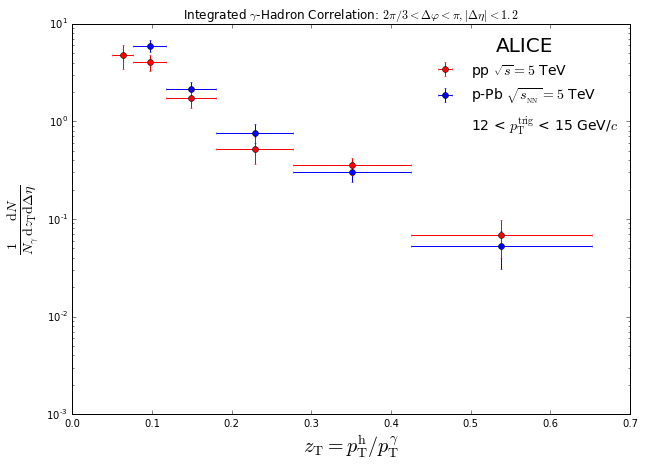

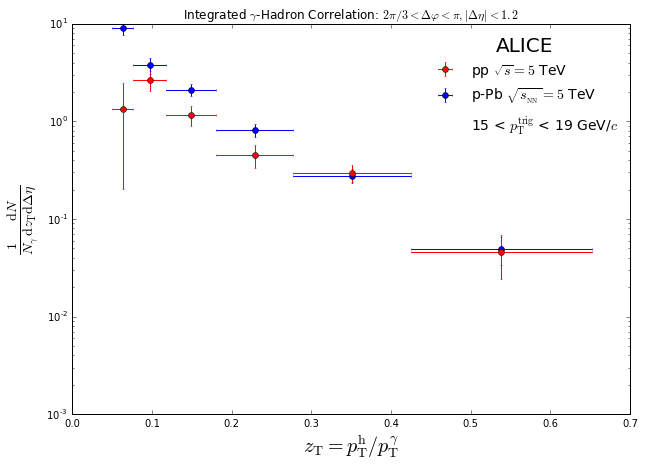

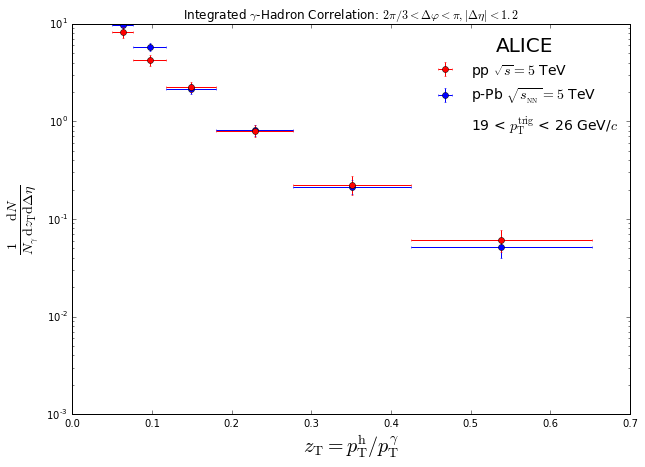

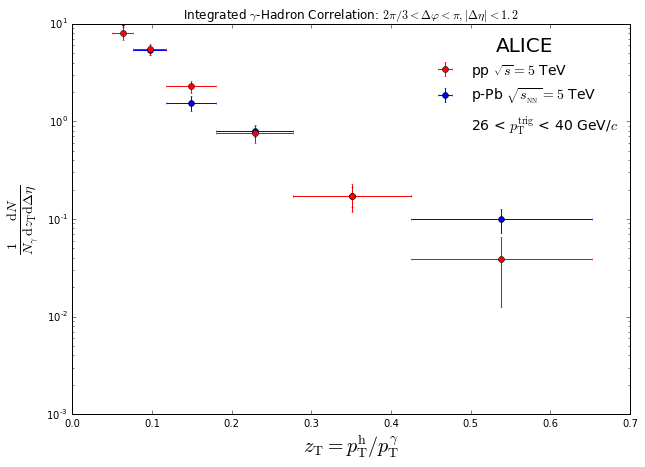

In [121]:
for ipt in range(N_pT_Bins):
    #if (ipt > 0): continue

    plt.figure(figsize=(10,7))

    zt_box = np.ones(NzT) * 0.03

    #pPb_bar = plt.bar(zT_centers, pPb_sys[ipt]+pPb_sys[ipt], bottom=(pPb_FF[ipt])-pPb_sys[ipt], width=zt_box, align='center',edgecolor="blue",color='white',)
    #pp_bar = plt.bar(zT_centers, pp_sys[ipt]+pp_sys[ipt], bottom=pp_FF[ipt]-pp_sys[ipt], width=zt_box, align='center',edgecolor="red",color='white',)

    zT_max = 0
    for izt in range (NzT):
        if (zTbins[izt]*pTbins[ipt] > 15.0):
            zT_max = zTbins[izt]
            break
    
    plt.axvline(x=zT_max, ymin=0.001, ymax=10)
    
    pPb_plot = plt.errorbar(zT_centers, pPb_FF[ipt],xerr=zT_widths,yerr=pPb_FF_Errors[ipt],linewidth=1, fmt='bo',capsize=1,label='p-Pb')
    pp_plot = plt.errorbar(zT_centers, pp_FF[ipt],xerr=zT_widths,yerr=pp_FF_Errors[ipt],linewidth=1,fmt='ro',capsize=1,label='pp')


    if(Use_MC):
        plt.errorbar(zT_centers, MC_FF[ipt],xerr=zT_widths,yerr=MC_FF_Errors[ipt],linewidth=1, fmt='go',capsize=1,label='MC')
        MC_plot = plt.fill_between(zT_centers, MC_FF[ipt]-MC_FF_Errors[ipt], MC_FF[ipt]+MC_FF_Errors[ipt],color='green',alpha=0.6)

    empt, = ax.plot([], [],' ')

    plt.yscale('log')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
    plt.ylabel(r"$\frac{1}{N_{\mathrm{\gamma}}}\frac{\mathrm{d}N}{\mathrm{d}z_{\mathrm{T}} \mathrm{d}\Delta\eta}$",fontsize=20)
    plt.xlabel("${z_\mathrm{T}} = p_\mathrm{T}^\mathrm{h}/p_\mathrm{T}^\mathrm{\gamma}$",fontsize=20)
    #plt.xlim(xmin = 0.1,xmax=0.7)
    plt.ylim(ymin = 0.001,ymax=10)

    if(Use_MC):
        leg = plt.legend([pp_plot,pPb_plot,MC_plot,pp_bar,pPb_bar,empt],["pp $\sqrt{s} = 5$ TeV","p-Pb $\sqrt{s_{\mathrm{_{NN}}}}=5$ TeV","Pythia GJ $\sqrt{s} = 5$ TeV",
            "pp Systematic","p-Pb Systematic","Normalization $\pm 25\%$"],frameon=False,numpoints=1,title=' ',loc="upper right",prop={'size':14})
    else:
        #leg = plt.legend([pp_plot,pPb_plot,pp_bar,pPb_bar,empt],["pp $\sqrt{s} = 5$ TeV","p-Pb $\sqrt{s_{\mathrm{_{NN}}}}=5$ TeV",
        #    "pp Systematic","p-Pb Systematic","Normalization $\pm 25\%$"],frameon=False,numpoints=1,title=' ',loc="upper right",prop={'size':14})
        leg = plt.legend([pp_plot,pPb_plot,empt],["pp $\sqrt{s} = 5$ TeV","p-Pb $\sqrt{s_{\mathrm{_{NN}}}}=5$ TeV",
            r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c$'%(pTbins[ipt],pTbins[ipt+1])],frameon=False,numpoints=1,title=' ',loc="upper right",prop={'size':14})

    leg.set_title("ALICE")
    plt.setp(leg.get_title(),fontsize=20)

    plt.title(r'Integrated $\mathrm{\gamma}$-Hadron Correlation: $2\pi/3 < \Delta\varphi < \pi, |\Delta\eta| < %1.1f$ '%(eta_max))
    plt.gcf()
    plt.savefig("pics/All_FFunction.pdf", bbox_inches='tight')
    plt.show()

## p-Pb/pp Ratio

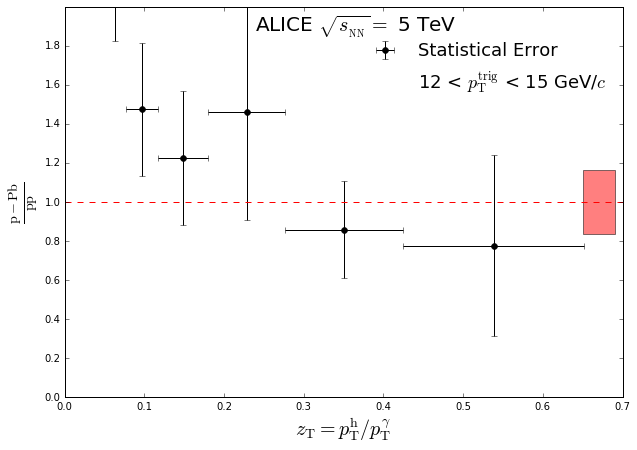

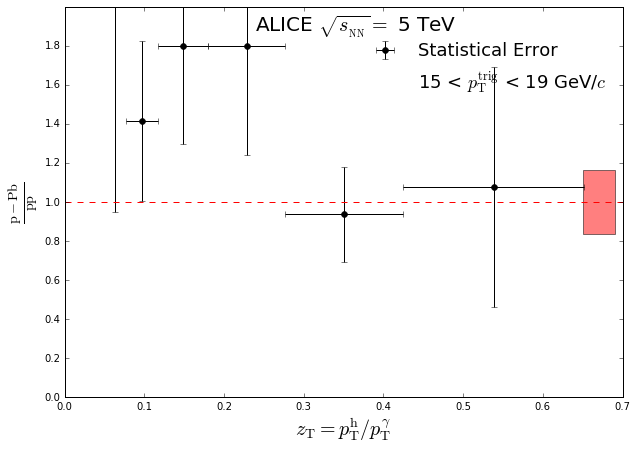

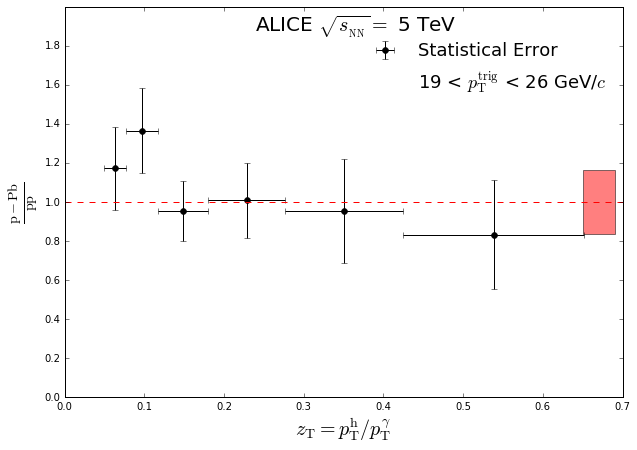

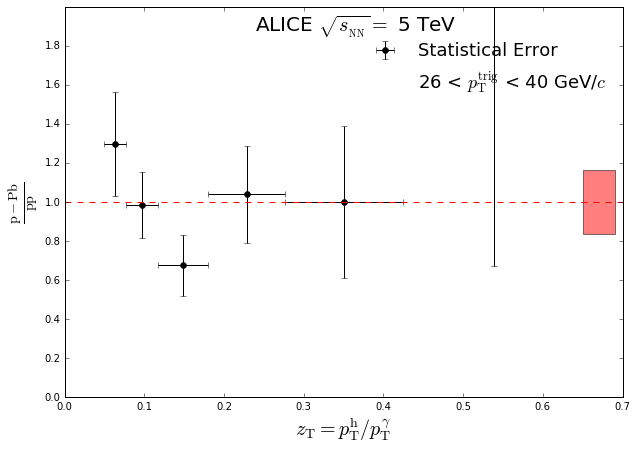

In [128]:
for ipt in range (N_pT_Bins):
    #if (ipt > 0): continue
    
    Ratio = pPb_FF[ipt]/pp_FF[ipt]

    #Stat. Error in ratio
    Ratio_Error = np.sqrt((pPb_FF_Errors[ipt]/pPb_FF[ipt])**2 + (pp_FF_Errors[ipt]/pp_FF[ipt])**2)*Ratio

    if (CorrectedP):
        E_Shower_Ratio = np.array([0.05, 0.05, 0.05,0.04,0.055,0.115])
        Ratio_Systematic = np.sqrt((pp_LE_Error[ipt]/pp_FF[ipt])**2 + (pPb_LE_Error[ipt]/pPb_FF[ipt])**2 + E_Shower_Ratio**2)*Ratio

    else:    
        Ratio_Systematic = np.sqrt((pp_sys/pp_FF)**2 + (pPb_sys/pPb_FF)**2)
        #FIXME: Constant 7.07%. Once purity systematic is finalized, add in quadrature to efficiency!

    plt.figure(figsize=(10,7)) 

    #Sys_Plot = plt.bar(zT_centers, Ratio_Systematic+Ratio_Systematic, bottom=Ratio-Ratio_Systematic, width=zt_box, align='center',edgecolor="black",color='white',)

    empt4, = ax.plot([], [],' ')
    
    Sys_Box = [0.65,0.69]
    xfill = [0.65,0.7]
    Norm_Box = plt.fill_between(Sys_Box, 1-0.166, 1.166, where=xfill,interpolate=False, alpha=0.5,facecolor='red')

    Ratio_Plot = plt.errorbar(zT_centers, Ratio, yerr=Ratio_Error,xerr=zT_widths, fmt='ko',capsize=3, ms=6,lw=1)
    plt.xlabel("${z_\mathrm{T}} = p_\mathrm{T}^{\mathrm{h}}/p_\mathrm{T}^\gamma$",fontsize=20)
    plt.ylabel(r"$\frac{\mathrm{p-Pb}}{\mathrm{pp}}$",fontsize=20)
    plt.ylim((0, 2))
    plt.yticks(np.arange(-0, 2, step=0.2))
    plt.xlim(xmin = 0.0,xmax=0.7)
    plt.axhline(y=1, color='r', linestyle='--')

    plt.legend([Ratio_Plot,empt4],["Statistical Error",r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c$'%(pTbins[ipt],pTbins[ipt+1])],frameon=False,numpoints=1,title=' ',prop={'size':18})
    plt.figtext(0.39,0.85,"ALICE $\sqrt{s_{\mathrm{_{NN}}}} = $ 5 TeV",color='Black', fontsize=20)

    plt.gcf()
    plt.savefig("pics/NN_pp_FFunction.pdf", bbox_inches='tight')
    plt.show()

## Overlay pT bins

### p-Pb

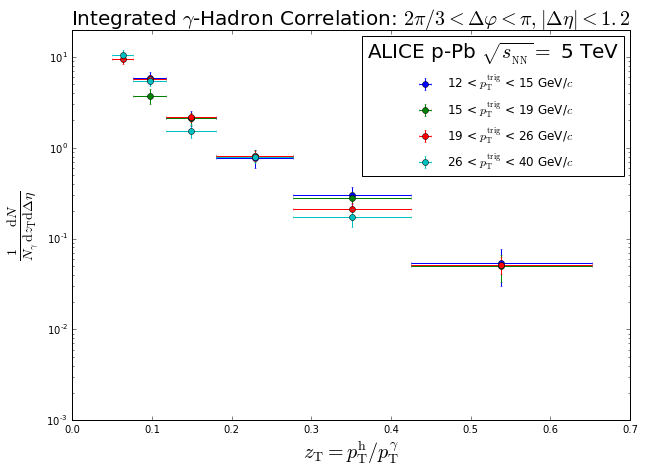

In [129]:
plt.figure(figsize=(10,7))
for ipt in range (N_pT_Bins):
    if(ipt>2):
        plt.errorbar(zT_centers[:5], pPb_FF[ipt][:5],xerr=zT_widths[:5],yerr=pPb_FF_Errors[ipt][:5],linewidth=1, fmt='o',capsize=1,label=r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c$'%(pTbins[ipt],pTbins[ipt+1]))
    elif(ipt<2):
        plt.errorbar(zT_centers[1:], pPb_FF[ipt][1:],xerr=zT_widths[1:],yerr=pPb_FF_Errors[ipt][1:],linewidth=1, fmt='o',capsize=1,label=r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c$'%(pTbins[ipt],pTbins[ipt+1]))
    else:
        plt.errorbar(zT_centers, pPb_FF[ipt],xerr=zT_widths,yerr=pPb_FF_Errors[ipt],linewidth=1, fmt='o',capsize=1,label=r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c$'%(pTbins[ipt],pTbins[ipt+1]))
    #plt.errorbar(zT_centers, pPb_FF[ipt],xerr=zT_widths,yerr=pPb_FF_Errors[ipt],linewidth=1, fmt='o',capsize=1,label=r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c$'%(pTbins[ipt],pTbins[ipt+1]))

    plt.yscale('log')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
    plt.ylabel(r"$\frac{1}{N_{\mathrm{\gamma}}}\frac{\mathrm{d}N}{\mathrm{d}z_{\mathrm{T}} \mathrm{d}\Delta\eta}$",fontsize=20)
    plt.xlabel("${z_\mathrm{T}} = p_\mathrm{T}^\mathrm{h}/p_\mathrm{T}^\mathrm{\gamma}$",fontsize=20)
    #plt.xlim(xmin = 0.1,xmax=0.7)
    plt.ylim(ymin = 0.001,ymax=20)

leg = plt.legend(numpoints=1)
leg.set_title("ALICE p-Pb $\sqrt{s_{\mathrm{_{NN}}}} = $ 5 TeV")
plt.setp(leg.get_title(),fontsize=20)

plt.title(r'Integrated $\mathrm{\gamma}$-Hadron Correlation: $2\pi/3 < \Delta\varphi < \pi, |\Delta\eta| < %1.1f$ '%(eta_max),fontdict = {'fontsize' : 20})
plt.gcf()
plt.savefig("pics/All_pT_FFunction_pPb_%s.pdf"%(Shower), bbox_inches='tight')
plt.show()

### pp

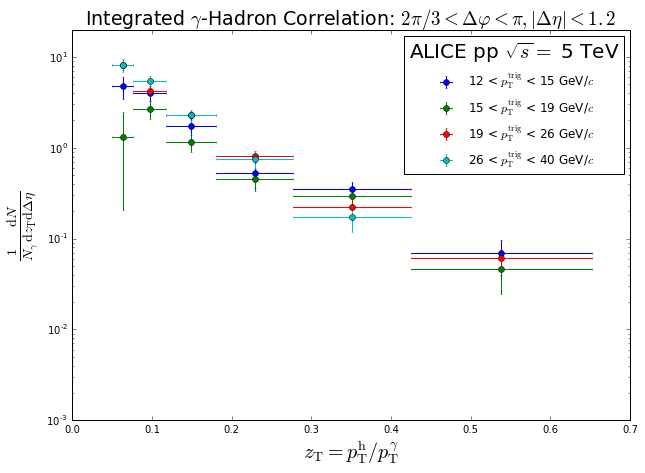

Errors
[[ 1.30915767  0.72946549  0.36095315  0.15951327  0.07038775  0.0284828 ]
 [ 1.12345838  0.5958026   0.28021411  0.12282786  0.05907761  0.02174386]
 [ 1.09044664  0.52936726  0.25693149  0.11529649  0.05004073  0.01596343]
 [ 1.30176073  0.68630782  0.33815773  0.15407701  0.05474218  0.02680243]]
Central Values
[[ 4.74955038  4.00980849  1.74065234  0.52463729  0.35323899  0.06857231]
 [ 1.3276858   2.65387295  1.17020438  0.4545473   0.29719482  0.04621569]
 [ 8.20245769  4.2219495   2.26812172  0.80470549  0.22439617  0.06154711]
 [ 8.09977384  5.47288303  2.27506386  0.75852996  0.17301495  0.03923019]]


In [130]:
plt.figure(figsize=(10,7))
for ipt in range (N_pT_Bins):
    if (ipt>2): #cut at tracking efficiency track pT lim of 15 GeV (cuts zT bins in last pT bin only)
        plt.errorbar(zT_centers[:5], pp_FF[ipt][:5],xerr=zT_widths[:5],yerr=pp_FF_Errors[ipt][:5],linewidth=1, fmt='o',capsize=1,label=r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c$'%(pTbins[ipt],pTbins[ipt+1]))
    #elif(ipt<2):
    #    plt.errorbar(zT_centers[1:], pp_FF[ipt][1:],xerr=zT_widths[1:],yerr=pp_FF_Errors[ipt][1:],linewidth=1, fmt='o',capsize=1,label=r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c $'%(pTbins[ipt],pTbins[ipt+1])) 
    else:
        plt.errorbar(zT_centers, pp_FF[ipt],xerr=zT_widths,yerr=pp_FF_Errors[ipt],linewidth=1, fmt='o',capsize=1,label=r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c$'%(pTbins[ipt],pTbins[ipt+1]))
    #plt.errorbar(zT_centers, pp_FF[ipt],xerr=zT_widths,yerr=pp_FF_Errors[ipt],linewidth=1, fmt='o',capsize=1,label=r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c$'%(pTbins[ipt],pTbins[ipt+1]))
    
    plt.yscale('log')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
    plt.ylabel(r"$\frac{1}{N_{\mathrm{\gamma}}}\frac{\mathrm{d}N}{\mathrm{d}z_{\mathrm{T}} \mathrm{d}\Delta\eta}$",fontsize=20)
    plt.xlabel("${z_\mathrm{T}} = p_\mathrm{T}^\mathrm{h}/p_\mathrm{T}^\mathrm{\gamma}$",fontsize=20)
    #plt.xlim(xmin = 0.1,xmax=0.7)
    plt.ylim(ymin = 0.001,ymax=20)

leg = plt.legend(numpoints=1)
leg.set_title("ALICE pp $\sqrt{s} = $ 5 TeV")
plt.setp(leg.get_title(),fontsize=20)

plt.title(r'Integrated $\mathrm{\gamma}$-Hadron Correlation: $2\pi/3 < \Delta\varphi < \pi, |\Delta\eta| < %1.1f$ '%(eta_max),fontdict = {'fontsize' : 19})
plt.gcf()
plt.savefig("pics/All_pT_FFunction_pp_%s.pdf"%(Shower), bbox_inches='tight')
plt.show()
print("Errors")
print(pp_FF_Errors)
print("Central Values")
print(pp_FF)

### Save FF to .npy files

In [160]:
if (Use_Weights):
    np.save("npy_files/%s_pp_Fragmentation_Functions.npy"%(Shower),pp_FF)
    np.save("npy_files/%s_pp_Fragmentation_Function_Errors.npy"%(Shower),pp_FF_Errors)
    np.save("npy_files/%s_pPb_Fragmentation_Functions.npy"%(Shower),pPb_FF)
    np.save("npy_files/%s_pPb_Fragmentation_Function_Errors.npy"%(Shower),pPb_FF_Errors)
    
    np.save("npy_files/%s_pp_Cs_purity_Uncertainty.npy"%(Shower),pp_Cs_purity_Uncertainty)
    np.save("npy_files/%s_pPb_Cs_purity_Uncertainty.npy"%(Shower),pPb_Cs_purity_Uncertainty)
    
    
else:
    np.save("npy_files/%s_pp_Fragmentation_Functions_Unweight.npy"%(Shower),pp_FF)
    np.save("npy_files/%s_pp_Fragmentation_Function_Errors_Unweight.npy"%(Shower),pp_FF_Errors)
    np.save("npy_files/%s_pPb_Fragmentation_Functions_Unweight.npy"%(Shower),pPb_FF)
    np.save("npy_files/%s_pPb_Fragmentation_Function_Errors_Unweight.npy"%(Shower),pPb_FF_Errors)

In [132]:
print("                           Proton-Proton")
NN_pp_FF = np.load("npy_files/NN_pp_Fragmentation_Functions.npy")
NN_pp_FF_Errors = np.load("npy_files/NN_pp_Fragmentation_Function_Errors.npy")
print("Neural Net")
print(NN_pp_FF_Errors/NN_pp_FF)

L0_pp_FF = np.load("npy_files/LO_pp_Fragmentation_Functions.npy")
L0_pp_FF_Errors = np.load("npy_files/LO_pp_Fragmentation_Function_Errors.npy")
print("Lambda0")
print(L0_pp_FF_Errors/L0_pp_FF)

print("")


print("                           Proton-Lead")
NN_pPb_FF = np.load("npy_files/NN_pPb_Fragmentation_Functions.npy")
NN_pPb_FF_Errors = np.load("npy_files/NN_pPb_Fragmentation_Function_Errors.npy")
print("Neural Net")
print(NN_pPb_FF_Errors/NN_pPb_FF)

L0_pPb_FF = np.load("npy_files/LO_pPb_Fragmentation_Functions.npy")
L0_pPb_FF_Errors = np.load("npy_files/LO_pPb_Fragmentation_Function_Errors.npy")
print("Lambda0")
print(L0_pPb_FF_Errors/L0_pPb_FF)

                           Proton-Proton
Neural Net
[[ 0.26597396  0.19652069  0.26904296  0.30254169  0.26572076  0.71946206]
 [ 0.79953417  0.31816436  0.33417798  0.29722677  0.29352805  1.19604442]
 [ 0.15992763  0.18106226  0.13661725  0.16748826  0.28843929  0.47320437]
 [ 0.19334328  0.1561053   0.27348343  0.28008151  0.36910268  0.80582173]]
Lambda0
[[ 0.27563823  0.18192028  0.20736659  0.30404485  0.19926382  0.41536878]
 [ 0.84617789  0.22450306  0.23945741  0.27022019  0.19878411  0.47048644]
 [ 0.13294145  0.12538455  0.11327941  0.14327788  0.2230017   0.25936931]
 [ 0.16071569  0.12540151  0.14863659  0.2031258   0.31640144  0.68320949]]

                           Proton-Lead
Neural Net
[[ 0.11147663  0.10453764  0.14899769  0.20591219  0.21188957  0.66014271]
 [ 0.16424071  0.22138227  0.15957035  0.17609015  0.17198813  0.46222421]
 [ 0.13051885  0.10327133  0.15749475  0.12190234  0.21708541  0.25527226]
 [ 0.11560543  0.1871475   0.24281362  0.20652543  0.31166041 

## Scaling to demonstrate shape agreement

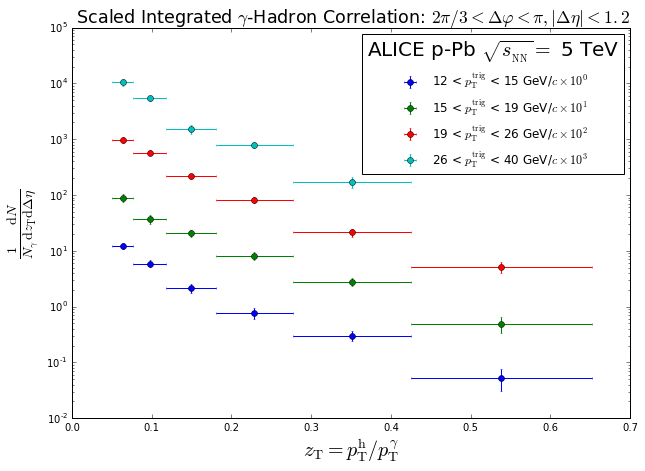

In [133]:
plt.figure(figsize=(10,7))
for ipt in range (N_pT_Bins):
    if(ipt>2):
        plt.errorbar(zT_centers[:5], pPb_FF[ipt][:5]*(10**ipt),xerr=zT_widths[:5],yerr=pPb_FF_Errors[ipt][:5]*(10**ipt),linewidth=1, fmt='o',capsize=1,label=r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c \times 10^{%1.0f}$'%(pTbins[ipt],pTbins[ipt+1],ipt))
    #elif(ipt<2):
    #    plt.errorbar(zT_centers[1:], pPb_FF[ipt][1:]*(10**ipt),xerr=zT_widths[1:],yerr=pPb_FF_Errors[ipt][1:]*(10**ipt),linewidth=1, fmt='o',capsize=1,label=r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c \times 10^{%1.0f}$'%(pTbins[ipt],pTbins[ipt+1],ipt))
    else:
        plt.errorbar(zT_centers, pPb_FF[ipt]*(10**ipt),xerr=zT_widths,yerr=pPb_FF_Errors[ipt]*(10**ipt),linewidth=1, fmt='o',capsize=1,label=r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c \times 10^{%1.0f}$'%(pTbins[ipt],pTbins[ipt+1],ipt))
#    plt.errorbar(zT_centers, pPb_FF[ipt]*(10**ipt),xerr=zT_widths,yerr=pPb_FF_Errors[ipt]*(10**ipt),linewidth=1, fmt='o',capsize=1,label=r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c \times 10^{%1.0f}$'%(pTbins[ipt],pTbins[ipt+1],ipt))
    #pp_plot = plt.errorbar(zT_centers, pp_FF[ipt],xerr=zT_widths,yerr=pp_FF_Errors[ipt],linewidth=1,fmt='ro',capsize=1,label='pp')

    plt.yscale('log')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
    plt.ylabel(r"$\frac{1}{N_{\mathrm{\gamma}}}\frac{\mathrm{d}N}{\mathrm{d}z_{\mathrm{T}} \mathrm{d}\Delta\eta}$",fontsize=20)
    plt.xlabel("${z_\mathrm{T}} = p_\mathrm{T}^\mathrm{h}/p_\mathrm{T}^\mathrm{\gamma}$",fontsize=20)
    #plt.xlim(xmin = 0.1,xmax=0.7)
    #plt.ylim(ymin = 0.00008,ymax=20)

leg = plt.legend(numpoints=1)
leg.set_title("ALICE p-Pb $\sqrt{s_{\mathrm{_{NN}}}} = $ 5 TeV")
plt.setp(leg.get_title(),fontsize=20)

plt.title(r' Scaled Integrated $\mathrm{\gamma}$-Hadron Correlation: $2\pi/3 < \Delta\varphi < \pi, |\Delta\eta| < %1.1f$ '%(eta_max),fontdict = {'fontsize' : 17.5})
plt.gcf()
plt.savefig("pics/Scaled_pT_FFunction_pPb_%s.pdf"%(Shower), bbox_inches='tight')
plt.show()

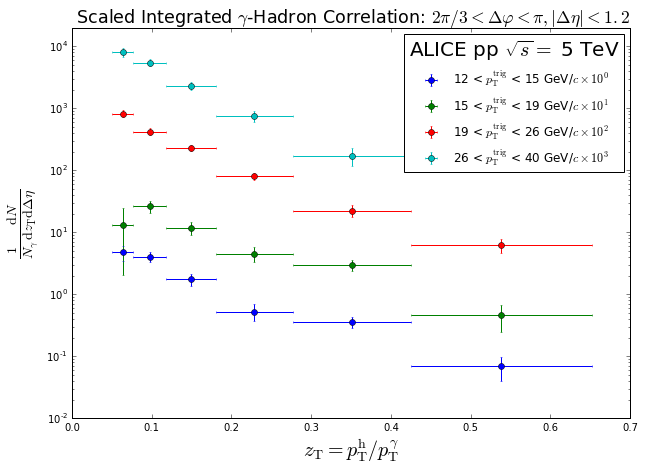

In [134]:
plt.figure(figsize=(10,7))
for ipt in range (N_pT_Bins):
    if(ipt>2):
        plt.errorbar(zT_centers[:5], pp_FF[ipt][:5]*(10**ipt),xerr=zT_widths[:5],yerr=pp_FF_Errors[ipt][:5]*(10**ipt),linewidth=1, fmt='o',capsize=1,label=r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c \times 10^{%1.0f}$'%(pTbins[ipt],pTbins[ipt+1],ipt))
    #elif(ipt<2):
    #    plt.errorbar(zT_centers[1:], pp_FF[ipt][1:]*(10**ipt),xerr=zT_widths[1:],yerr=pp_FF_Errors[ipt][1:]*(10**ipt),linewidth=1, fmt='o',capsize=1,label=r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c \times 10^{%1.0f}$'%(pTbins[ipt],pTbins[ipt+1],ipt)) 
    else:
        plt.errorbar(zT_centers, pp_FF[ipt]*(10**ipt),xerr=zT_widths,yerr=pp_FF_Errors[ipt]*(10**ipt),linewidth=1, fmt='o',capsize=1,label=r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c \times 10^{%1.0f}$'%(pTbins[ipt],pTbins[ipt+1],ipt))
#    plt.errorbar(zT_centers, pp_FF[ipt]*(10**ipt),xerr=zT_widths,yerr=pp_FF_Errors[ipt]*(10**ipt),linewidth=1, fmt='o',capsize=1,label=r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c \times 10^{%1.0f}$'%(pTbins[ipt],pTbins[ipt+1],ipt))
    #pp_plot = plt.errorbar(zT_centers, pp_FF[ipt],xerr=zT_widths,yerr=pp_FF_Errors[ipt],linewidth=1,fmt='ro',capsize=1,label='pp')

    plt.yscale('log')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
    plt.ylabel(r"$\frac{1}{N_{\mathrm{\gamma}}}\frac{\mathrm{d}N}{\mathrm{d}z_{\mathrm{T}} \mathrm{d}\Delta\eta}$",fontsize=20)
    plt.xlabel("${z_\mathrm{T}} = p_\mathrm{T}^\mathrm{h}/p_\mathrm{T}^\mathrm{\gamma}$",fontsize=20)
    #plt.xlim(xmin = 0.1,xmax=0.7)
    plt.ylim(ymin = 0.01,ymax=2*10**4)

leg = plt.legend(numpoints=1)
leg.set_title("ALICE pp $\sqrt{s} = $ 5 TeV")
plt.setp(leg.get_title(),fontsize=20)

plt.title(r' Scaled Integrated $\mathrm{\gamma}$-Hadron Correlation: $2\pi/3 < \Delta\varphi < \pi, |\Delta\eta| < %1.1f$ '%(eta_max),fontdict = {'fontsize' : 17.5})
plt.gcf()
plt.savefig("pics/Scaled_pT_FFunction_pp_%s.pdf"%(Shower), bbox_inches='tight')
plt.show()

## Compare Scaled NN and Lambda

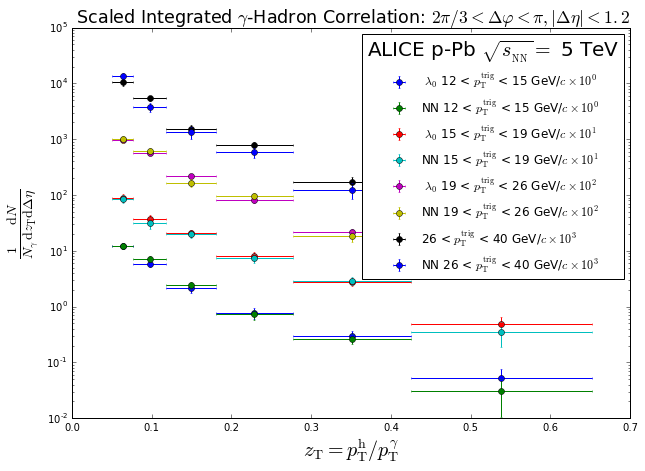

In [135]:
plt.figure(figsize=(10,7))
for ipt in range (N_pT_Bins):
    if(ipt>2):
        plt.errorbar(zT_centers[:5], L0_pPb_FF[ipt][:5]*(10**ipt),xerr=zT_widths[:5],yerr=L0_pPb_FF_Errors[ipt][:5]*(10**ipt),linewidth=1, fmt='o',capsize=1,label=r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c \times 10^{%1.0f}$'%(pTbins[ipt],pTbins[ipt+1],ipt))
        plt.errorbar(zT_centers, NN_pPb_FF[ipt]*(10**ipt),xerr=zT_widths,yerr=NN_pPb_FF_Errors[ipt]*(10**ipt),linewidth=1, fmt='o',capsize=1,label=r'NN %1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c \times 10^{%1.0f}$'%(pTbins[ipt],pTbins[ipt+1],ipt))
    #elif(ipt<2):
    #    plt.errorbar(zT_centers[1:], pPb_FF[ipt][1:]*(10**ipt),xerr=zT_widths[1:],yerr=pPb_FF_Errors[ipt][1:]*(10**ipt),linewidth=1, fmt='o',capsize=1,label=r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c \times 10^{%1.0f}$'%(pTbins[ipt],pTbins[ipt+1],ipt))
    else:
        plt.errorbar(zT_centers, L0_pPb_FF[ipt]*(10**ipt),xerr=zT_widths,yerr=L0_pPb_FF_Errors[ipt]*(10**ipt),linewidth=1, fmt='o',capsize=1,label=r' $\lambda_0 $ %1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c \times 10^{%1.0f}$'%(pTbins[ipt],pTbins[ipt+1],ipt))
        plt.errorbar(zT_centers, NN_pPb_FF[ipt]*(10**ipt),xerr=zT_widths,yerr=NN_pPb_FF_Errors[ipt]*(10**ipt),linewidth=1, fmt='o',capsize=1,label=r'NN %1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c \times 10^{%1.0f}$'%(pTbins[ipt],pTbins[ipt+1],ipt))
        #    plt.errorbar(zT_centers, pPb_FF[ipt]*(10**ipt),xerr=zT_widths,yerr=pPb_FF_Errors[ipt]*(10**ipt),linewidth=1, fmt='o',capsize=1,label=r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c \times 10^{%1.0f}$'%(pTbins[ipt],pTbins[ipt+1],ipt))
    #pp_plot = plt.errorbar(zT_centers, pp_FF[ipt],xerr=zT_widths,yerr=pp_FF_Errors[ipt],linewidth=1,fmt='ro',capsize=1,label='pp')

    plt.yscale('log')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
    plt.ylabel(r"$\frac{1}{N_{\mathrm{\gamma}}}\frac{\mathrm{d}N}{\mathrm{d}z_{\mathrm{T}} \mathrm{d}\Delta\eta}$",fontsize=20)
    plt.xlabel("${z_\mathrm{T}} = p_\mathrm{T}^\mathrm{h}/p_\mathrm{T}^\mathrm{\gamma}$",fontsize=20)
    #plt.xlim(xmin = 0.1,xmax=0.7)
    #plt.ylim(ymin = 0.00008,ymax=20)

leg = plt.legend(numpoints=1)
leg.set_title("ALICE p-Pb $\sqrt{s_{\mathrm{_{NN}}}} = $ 5 TeV")
plt.setp(leg.get_title(),fontsize=20)

plt.title(r' Scaled Integrated $\mathrm{\gamma}$-Hadron Correlation: $2\pi/3 < \Delta\varphi < \pi, |\Delta\eta| < %1.1f$ '%(eta_max),fontdict = {'fontsize' : 17.5})
plt.gcf()
plt.savefig("pics/Scaled_pT_FFunction_pPb_%s.pdf"%(Shower), bbox_inches='tight')
plt.show()

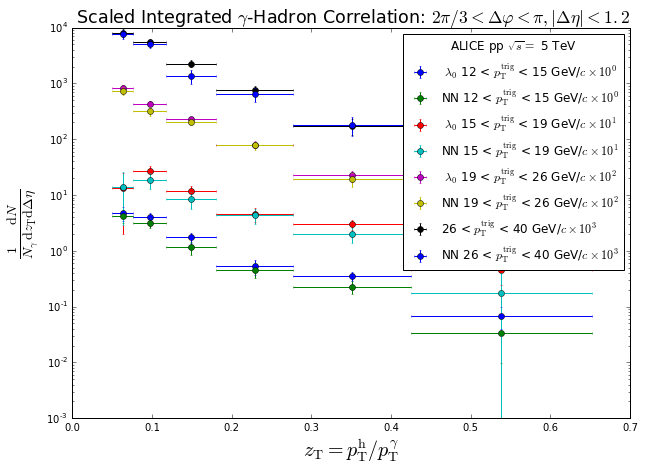

[ 1.11289643  1.25252853  1.50516074  1.1426437   1.55155692  1.99953023]
[ 0.93484642  1.41504529  1.36985863  1.0563094   1.4971653   2.5789067 ]
[ 1.1017643   1.3184147   1.1086358   1.03843539  1.15073385  1.75631033]
[ 1.0579834   1.07022987  1.67436463  1.16696326  0.9466034   1.20818446]


In [175]:
plt.figure(figsize=(10,7))
for ipt in range (N_pT_Bins):
    if(ipt>2):
        plt.errorbar(zT_centers[:5], L0_pp_FF[ipt][:5]*(10**ipt),xerr=zT_widths[:5],yerr=L0_pp_FF_Errors[ipt][:5]*(10**ipt),linewidth=1, fmt='o',capsize=1,label=r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c \times 10^{%1.0f}$'%(pTbins[ipt],pTbins[ipt+1],ipt))
        #L0_pSys_Plot = plt.bar(zT_centers[:5], pp_Cs_purity_Uncertainty[ipt][:5]*(10**ipt)+pp_Cs_purity_Uncertainty[ipt][:5]*(10**ipt), bottom=L0_pp_FF[ipt][:5]*(10**ipt)-pp_Cs_purity_Uncertainty[ipt][:5]*(10**ipt), width=0.025, align='center',edgecolor="black",color='white',)

        plt.errorbar(zT_centers, NN_pp_FF[ipt]*(10**ipt),xerr=zT_widths,yerr=NN_pp_FF_Errors[ipt]*(10**ipt),linewidth=1, fmt='o',capsize=1,label=r'NN %1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c \times 10^{%1.0f}$'%(pTbins[ipt],pTbins[ipt+1],ipt))
    #elif(ipt<2):
    #    plt.errorbar(zT_centers[1:], pPb_FF[ipt][1:]*(10**ipt),xerr=zT_widths[1:],yerr=pPb_FF_Errors[ipt][1:]*(10**ipt),linewidth=1, fmt='o',capsize=1,label=r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c \times 10^{%1.0f}$'%(pTbins[ipt],pTbins[ipt+1],ipt))
    else:
        plt.errorbar(zT_centers, L0_pp_FF[ipt]*(10**ipt),xerr=zT_widths,yerr=L0_pp_FF_Errors[ipt]*(10**ipt),linewidth=1, fmt='o',capsize=1,label=r' $\lambda_0 $ %1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c \times 10^{%1.0f}$'%(pTbins[ipt],pTbins[ipt+1],ipt))
        #L0_pSys_Plot = plt.bar(zT_centers, pp_Cs_purity_Uncertainty[ipt]+pp_Cs_purity_Uncertainty[ipt]*(10**ipt), bottom=L0_pp_FF[ipt]*(10**ipt)-pp_Cs_purity_Uncertainty[ipt]*(10**ipt), width=0.025, align='center',edgecolor="black",color='white',)
        plt.errorbar(zT_centers, NN_pp_FF[ipt]*(10**ipt),xerr=zT_widths,yerr=NN_pp_FF_Errors[ipt]*(10**ipt),linewidth=1, fmt='o',capsize=1,label=r'NN %1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c \times 10^{%1.0f}$'%(pTbins[ipt],pTbins[ipt+1],ipt))
        #    plt.errorbar(zT_centers, pPb_FF[ipt]*(10**ipt),xerr=zT_widths,yerr=pPb_FF_Errors[ipt]*(10**ipt),linewidth=1, fmt='o',capsize=1,label=r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c \times 10^{%1.0f}$'%(pTbins[ipt],pTbins[ipt+1],ipt))
    #pp_plot = plt.errorbar(zT_centers, pp_FF[ipt],xerr=zT_widths,yerr=pp_FF_Errors[ipt],linewidth=1,fmt='ro',capsize=1,label='pp')

    plt.yscale('log')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
    plt.ylabel(r"$\frac{1}{N_{\mathrm{\gamma}}}\frac{\mathrm{d}N}{\mathrm{d}z_{\mathrm{T}} \mathrm{d}\Delta\eta}$",fontsize=20)
    plt.xlabel("${z_\mathrm{T}} = p_\mathrm{T}^\mathrm{h}/p_\mathrm{T}^\mathrm{\gamma}$",fontsize=20)
    #plt.xlim(xmin = 0.1,xmax=0.7)
    #plt.ylim(ymin = 0.001,ymax=10000)

leg = plt.legend(numpoints=1)
leg.set_title("ALICE pp $\sqrt{s} = $ 5 TeV")
plt.setp(leg.get_title(),fontsize=12)

plt.title(r' Scaled Integrated $\mathrm{\gamma}$-Hadron Correlation: $2\pi/3 < \Delta\varphi < \pi, |\Delta\eta| < %1.1f$ '%(eta_max),fontdict = {'fontsize' : 17.5})
plt.gcf()
plt.savefig("pics/Scaled_pT_FFunction_pPb_%s.pdf"%(Shower), bbox_inches='tight')
plt.show()
for ipt in range (N_pT_Bins):
    print(L0_pp_FF[ipt]/NN_pp_FF[ipt])

In [137]:
#calculate the average over pT in each zT bin. Inverse Variance Weighted Average of central values.
def Weighted_Averag(FF,FF_Errors):

    Combined = np.zeros(len(pp_FF[0]))
    Combined_Errors = np.zeros(len(pp_FF_Errors[0]))

    for izt in range (NzT):
        weight_sum = 0

        for ipt in range(N_pT_Bins):

            if (ipt>2 and izt>4): continue #Tracking efficiency limit
            if(ipt<2 and izt<1): continue
            Combined[izt]+= (1/FF_Errors[ipt][izt])**2 * FF[ipt][izt] #Weighting by stat. error**2 = sqrt(N)**2
            weight_sum += (1/FF_Errors[ipt][izt])**2

        Combined[izt] = Combined[izt]/weight_sum

    for ipt in range (N_pT_Bins):
        Combined_Errors += FF_Errors[ipt]**2

    Combined_Errors = np.sqrt(Combined_Errors)
    Combined_Errors = Combined_Errors/N_pT_Bins
    
    return(Combined,Combined_Errors)

In [138]:
NN_pp_Combined,NN_pp_Combined_Errors = Weighted_Averag(NN_pp_FF,NN_pp_FF_Errors)
NN_pPb_Combined,NN_pPb_Combined_Errors = Weighted_Averag(NN_pPb_FF,NN_pPb_FF_Errors)
L0_pp_Combined,L0_pp_Combined_Errors = Weighted_Averag(L0_pp_FF,L0_pp_FF_Errors)
L0_pPb_Combined,L0_pPb_Combined_Errors = Weighted_Averag(L0_pPb_FF,L0_pPb_FF_Errors)
print(L0_pPb_Combined)

[ 10.00318743   5.218675     1.96709348   0.79914024   0.22540595
   0.05103809]


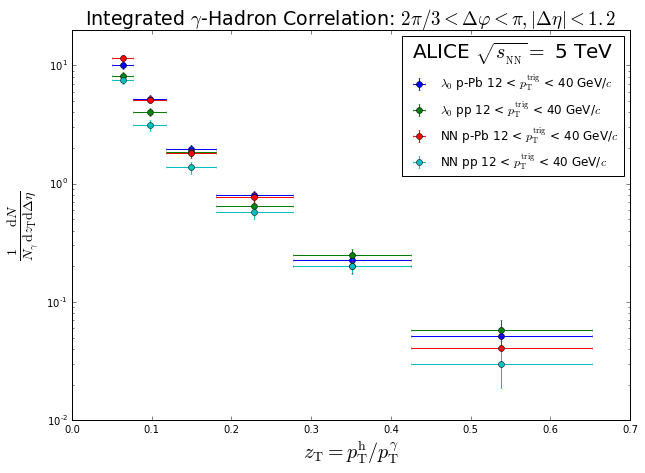

In [139]:
plt.figure(figsize=(10,7))
plt.errorbar(zT_centers, L0_pPb_Combined,xerr=zT_widths,yerr=L0_pPb_Combined_Errors,linewidth=1, fmt='o',capsize=1,label=r'$\lambda_0$ p-Pb %1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c$'%(pTbins[0],pTbins[N_pT_Bins]))
plt.errorbar(zT_centers, L0_pp_Combined,xerr=zT_widths,yerr=L0_pp_Combined_Errors,linewidth=1, fmt='o',capsize=1,label=r'$\lambda_0$ pp %1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c$'%(pTbins[0],pTbins[N_pT_Bins]))
plt.errorbar(zT_centers, NN_pPb_Combined,xerr=zT_widths,yerr=NN_pPb_Combined_Errors,linewidth=1, fmt='o',capsize=1,label=r'NN p-Pb %1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c$'%(pTbins[0],pTbins[N_pT_Bins]))
plt.errorbar(zT_centers, NN_pp_Combined,xerr=zT_widths,yerr=NN_pp_Combined_Errors,linewidth=1, fmt='o',capsize=1,label=r'NN pp %1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c$'%(pTbins[0],pTbins[N_pT_Bins]))
    #pp_plot = plt.errorbar(zT_centers, pp_FF[ipt],xerr=zT_widths,yerr=pp_FF_Errors[ipt],linewidth=1,fmt='ro',capsize=1,label='pp')

plt.yscale('log')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
plt.ylabel(r"$\frac{1}{N_{\mathrm{\gamma}}}\frac{\mathrm{d}N}{\mathrm{d}z_{\mathrm{T}} \mathrm{d}\Delta\eta}$",fontsize=20)
plt.xlabel("${z_\mathrm{T}} = p_\mathrm{T}^\mathrm{h}/p_\mathrm{T}^\mathrm{\gamma}$",fontsize=20)
#plt.xlim(xmin = 0.1,xmax=0.7)
plt.ylim(ymin = 0.01,ymax=20)

leg = plt.legend(numpoints=1)
leg.set_title("ALICE $\sqrt{s_{\mathrm{_{NN}}}} = $ 5 TeV")
plt.setp(leg.get_title(),fontsize=20)

plt.title(r'Integrated $\mathrm{\gamma}$-Hadron Correlation: $2\pi/3 < \Delta\varphi < \pi, |\Delta\eta| < %1.1f$ '%(eta_max),fontdict = {'fontsize' : 19})
plt.gcf()
#plt.savefig("pics/Averaged_pT_FFunction_%s.pdf"%(Shower), bbox_inches='tight')
plt.show()

In [186]:
#L0_pSys_Plot = plt.bar(zT_centers, pp_Cs_purity_Uncertainty[ipt]+pp_Cs_purity_Uncertainty[ipt]*(10**ipt), bottom=L0_pp_FF[ipt]*(10**ipt)-pp_Cs_purity_Uncertainty[ipt]*(10**ipt), width=0.025, align='center',edgecolor="black",color='white',)
pp_temp = pp_Cs_purity_Uncertainty**2
pp_Cs_purity_Uncertainty_Combined = np.sqrt(pp_temp.sum(0))/len(pp_temp)
pPb_temp = pPb_Cs_purity_Uncertainty**2
pPb_Cs_purity_Uncertainty_Combined = np.sqrt(pPb_temp.sum(0))/len(pPb_temp)

SyntaxError: invalid syntax (<ipython-input-186-d3e3fd954672>, line 5)

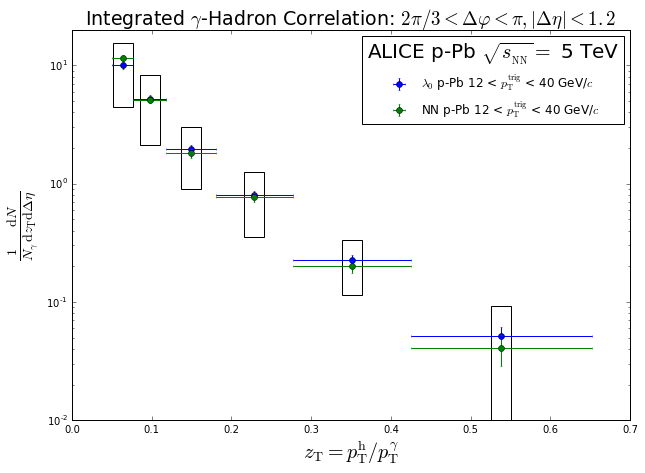


tab completion not implemented for this context

tab completion not implemented for this context

tab completion not implemented for this context

tab completion not implemented for this context

tab completion not implemented for this context

tab completion not implemented for this context


In [184]:
plt.figure(figsize=(10,7))
plt.errorbar(zT_centers, L0_pPb_Combined,xerr=zT_widths,yerr=L0_pPb_Combined_Errors,linewidth=1, fmt='o',capsize=1,label=r'$\lambda_0$ p-Pb %1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c$'%(pTbins[0],pTbins[N_pT_Bins]))
L0_pSys_Plot = plt.bar(zT_centers, pPb_Cs_purity_Uncertainty_Combined*2, bottom=L0_pPb_Combined-pPb_Cs_purity_Uncertainty_Combined, width=0.025, align='center',edgecolor="black",color='white',)

plt.errorbar(zT_centers, NN_pPb_Combined,xerr=zT_widths,yerr=NN_pPb_Combined_Errors,linewidth=1, fmt='o',capsize=1,label=r'NN p-Pb %1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c$'%(pTbins[0],pTbins[N_pT_Bins]))
    #pp_plot = plt.errorbar(zT_centers, pp_FF[ipt],xerr=zT_widths,yerr=pp_FF_Errors[ipt],linewidth=1,fmt='ro',capsize=1,label='pp')

plt.yscale('log')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
plt.ylabel(r"$\frac{1}{N_{\mathrm{\gamma}}}\frac{\mathrm{d}N}{\mathrm{d}z_{\mathrm{T}} \mathrm{d}\Delta\eta}$",fontsize=20)
plt.xlabel("${z_\mathrm{T}} = p_\mathrm{T}^\mathrm{h}/p_\mathrm{T}^\mathrm{\gamma}$",fontsize=20)
#plt.xlim(xmin = 0.1,xmax=0.7)
plt.ylim(ymin = 0.01,ymax=20)

leg = plt.legend(numpoints=1)
leg.set_title("ALICE p-Pb $\sqrt{s_{\mathrm{_{NN}}}} = $ 5 TeV")
plt.setp(leg.get_title(),fontsize=20)

plt.title(r'Integrated $\mathrm{\gamma}$-Hadron Correlation: $2\pi/3 < \Delta\varphi < \pi, |\Delta\eta| < %1.1f$ '%(eta_max),fontdict = {'fontsize' : 19})
plt.gcf()
#plt.savefig("pics/Averaged_pT_FFunction_%s.pdf"%(Shower), bbox_inches='tight')
plt.show()

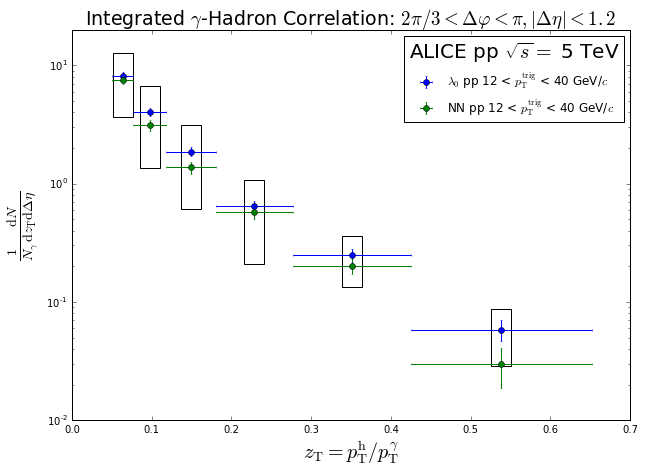

[ 1.08400657  1.28305143  1.35866532  1.12431601  1.233824    1.95045821]



tab completion not implemented for this context

tab completion not implemented for this context

tab completion not implemented for this context


In [185]:
plt.figure(figsize=(10,7))
plt.errorbar(zT_centers, L0_pp_Combined,xerr=zT_widths,yerr=L0_pp_Combined_Errors,linewidth=1, fmt='o',capsize=1,label=r'$\lambda_0$ pp %1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c$'%(pTbins[0],pTbins[N_pT_Bins]))
L0_pSys_Plot = plt.bar(zT_centers, pp_Cs_purity_Uncertainty_Combined*2, bottom=L0_pp_Combined-pp_Cs_purity_Uncertainty_Combined, width=0.025, align='center',edgecolor="black",color='white',)

plt.errorbar(zT_centers, NN_pp_Combined,xerr=zT_widths,yerr=NN_pp_Combined_Errors,linewidth=1, fmt='o',capsize=1,label=r'NN pp %1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c$'%(pTbins[0],pTbins[N_pT_Bins]))
    #pp_plot = plt.errorbar(zT_centers, pp_FF[ipt],xerr=zT_widths,yerr=pp_FF_Errors[ipt],linewidth=1,fmt='ro',capsize=1,label='pp')

plt.yscale('log')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
plt.ylabel(r"$\frac{1}{N_{\mathrm{\gamma}}}\frac{\mathrm{d}N}{\mathrm{d}z_{\mathrm{T}} \mathrm{d}\Delta\eta}$",fontsize=20)
plt.xlabel("${z_\mathrm{T}} = p_\mathrm{T}^\mathrm{h}/p_\mathrm{T}^\mathrm{\gamma}$",fontsize=20)
#plt.xlim(xmin = 0.1,xmax=0.7)
plt.ylim(ymin = 0.01,ymax=20)

leg = plt.legend(numpoints=1)
leg.set_title("ALICE pp $\sqrt{s} = $ 5 TeV")
plt.setp(leg.get_title(),fontsize=20)

plt.title(r'Integrated $\mathrm{\gamma}$-Hadron Correlation: $2\pi/3 < \Delta\varphi < \pi, |\Delta\eta| < %1.1f$ '%(eta_max),fontdict = {'fontsize' : 19})
plt.gcf()
#plt.savefig("pics/Averaged_pT_FFunction_%s.pdf"%(Shower), bbox_inches='tight')
plt.show()
print(L0_pp_Combined/NN_pp_Combined)

##  Weighted Averaging

$\frac{\sum_{i=1}^{n}w_i x_i}{\sum_{i=1}^{n}w_i}$ where weight $w_i = \frac{1}{\sigma_i^2} $ in each $z_\mathrm{T}$ bin, i

$\sigma_{avg.} = \frac{ \sqrt{\sum_{i=1}^{n}\sigma_{i}^{2}} }{n}$

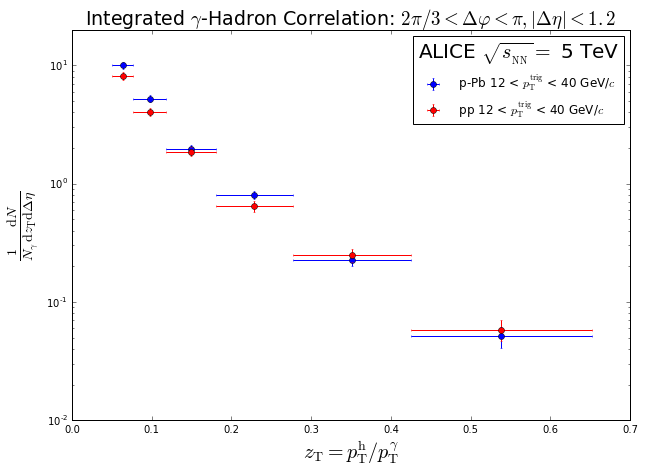

In [142]:
pp_Combined = np.zeros(len(pp_FF[0]))
pPb_Combined = np.zeros(len(pPb_FF[0]))

pp_Combined_Errors = np.zeros(len(pp_FF_Errors[0]))
pPb_Combined_Errors = np.zeros(len(pPb_FF_Errors[0]))

#calculate the average over pT in each zT bin
for izt in range (NzT):
    weight_sum_pp = 0
    weight_sum_pPb = 0
    
    for ipt in range(N_pT_Bins):
        
        if (ipt>2 and izt>4): continue #Tracking efficiency limit
        if(ipt<2 and izt<1): continue
        pp_Combined[izt]+= (1/pp_FF_Errors[ipt][izt])**2 * pp_FF[ipt][izt] #Weighting by stat. error**2 = sqrt(N)**2
        weight_sum_pp += (1/pp_FF_Errors[ipt][izt])**2
        
        pPb_Combined[izt]+= 1/pPb_FF_Errors[ipt][izt]**2 * pPb_FF[ipt][izt]
        weight_sum_pPb += 1/pPb_FF_Errors[ipt][izt]**2
        
    pp_Combined[izt] = pp_Combined[izt]/weight_sum_pp
    pPb_Combined[izt] = pPb_Combined[izt]/weight_sum_pPb
    
for ipt in range (N_pT_Bins):
    
    pp_Combined_Errors += pp_FF_Errors[ipt]**2
    pPb_Combined_Errors += pPb_FF_Errors[ipt]**2

pp_Combined_Errors = np.sqrt(pp_Combined_Errors)
pp_Combined_Errors = pp_Combined_Errors/N_pT_Bins

pPb_Combined_Errors = np.sqrt(pPb_Combined_Errors)
pPb_Combined_Errors = pPb_Combined_Errors/N_pT_Bins

#---------------- Plot ------------------------------#

plt.figure(figsize=(10,7))
plt.errorbar(zT_centers, pPb_Combined,xerr=zT_widths,yerr=pPb_Combined_Errors,linewidth=1, fmt='o',capsize=1,label=r' p-Pb %1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c$'%(pTbins[0],pTbins[N_pT_Bins]))
plt.errorbar(zT_centers, pp_Combined,xerr=zT_widths,yerr=pp_Combined_Errors,linewidth=1, fmt='ro',capsize=1,label=r' pp %1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c$'%(pTbins[0],pTbins[N_pT_Bins]))
    #pp_plot = plt.errorbar(zT_centers, pp_FF[ipt],xerr=zT_widths,yerr=pp_FF_Errors[ipt],linewidth=1,fmt='ro',capsize=1,label='pp')

plt.yscale('log')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
plt.ylabel(r"$\frac{1}{N_{\mathrm{\gamma}}}\frac{\mathrm{d}N}{\mathrm{d}z_{\mathrm{T}} \mathrm{d}\Delta\eta}$",fontsize=20)
plt.xlabel("${z_\mathrm{T}} = p_\mathrm{T}^\mathrm{h}/p_\mathrm{T}^\mathrm{\gamma}$",fontsize=20)
#plt.xlim(xmin = 0.1,xmax=0.7)
plt.ylim(ymin = 0.01,ymax=20)

leg = plt.legend(numpoints=1)
leg.set_title("ALICE $\sqrt{s_{\mathrm{_{NN}}}} = $ 5 TeV")
plt.setp(leg.get_title(),fontsize=20)

plt.title(r'Integrated $\mathrm{\gamma}$-Hadron Correlation: $2\pi/3 < \Delta\varphi < \pi, |\Delta\eta| < %1.1f$ '%(eta_max),fontdict = {'fontsize' : 19})
plt.gcf()
plt.savefig("pics/Averaged_pT_FFunction_%s.pdf"%(Shower), bbox_inches='tight')
plt.show()
    

## Averaged Fragmentation Function Ratios

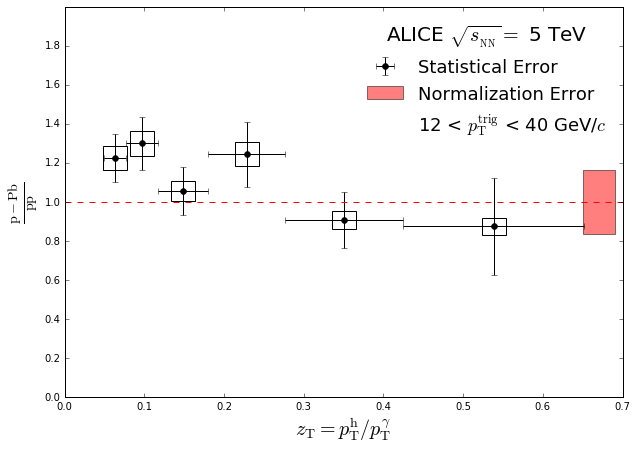



In [161]:

Ratio = pPb_Combined/pp_Combined

#Stat. Error in ratio
Ratio_Error = np.sqrt((pPb_Combined_Errors/pPb_Combined)**2 + (pp_Combined_Errors/pp_Combined)**2)*Ratio

if (CorrectedP):
    E_Shower_Ratio = np.array([0.05, 0.05, 0.05,0.04,0.055,0.115])
    #Ratio_Systematic = np.sqrt((pp_LE_Error[ipt]/pp_FF[ipt])**2 + (pPb_LE_Error[ipt]/pPb_FF[ipt])**2 + E_Shower_Ratio**2)*Ratio
    Ratio_Systematic = np.ones(len(pPb_Combined_Errors))*0.05*Ratio
    #Ratio_Systematic = np.sqrt( (0.05*pp_Combined)**2 + (0.05*pPb_Combined)**2)*Ratio

else:    
    Ratio_Systematic = np.sqrt((pp_sys/pp_FF)**2 + (pPb_sys/pPb_FF)**2)
    #FIXME: Constant 7.07%. Once purity systematic is finalized, add in quadrature to efficiency!

plt.figure(figsize=(10,7)) 

Sys_Plot = plt.bar(zT_centers, Ratio_Systematic+Ratio_Systematic, bottom=Ratio-Ratio_Systematic, width=zt_box, align='center',edgecolor="black",color='white',)

empt4, = ax.plot([], [],' ')

Sys_Box = [0.65,0.69]
xfill = [0.65,0.7]
Norm_Box = plt.fill_between(Sys_Box, 1-0.166, 1.166, where=xfill,interpolate=False, alpha=0.5,facecolor='red')

Ratio_Plot = plt.errorbar(zT_centers, Ratio, yerr=Ratio_Error,xerr=zT_widths, fmt='ko',capsize=3, ms=6,lw=1)
plt.xlabel("${z_\mathrm{T}} = p_\mathrm{T}^{\mathrm{h}}/p_\mathrm{T}^\gamma$",fontsize=20)
plt.ylabel(r"$\frac{\mathrm{p-Pb}}{\mathrm{pp}}$",fontsize=20)
plt.ylim((0, 2))
plt.yticks(np.arange(-0, 2, step=0.2))
plt.xlim(xmin = 0.0,xmax=0.7)
plt.axhline(y=1, color='r', linestyle='--')

#leg = plt.legend([Ratio_Plot,Sys_Plot,Norm_Box,empt4],["Statistical Error","Systematic Error","Normalization Error",r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c$'%(pTbins[0],pTbins[N_pT_Bins])],frameon=False,numpoints=1,loc="best",title=' ',prop={'size':18})
leg = plt.legend([Ratio_Plot,Norm_Box,empt4],["Statistical Error","Normalization Error",r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c$'%(pTbins[0],pTbins[N_pT_Bins])],frameon=False,numpoints=1,loc="best",title=' ',prop={'size':18})


#leg = plt.legend(numpoints=1)
leg.set_title("ALICE $\sqrt{s_{\mathrm{_{NN}}}} = $ 5 TeV")
plt.setp(leg.get_title(),fontsize=20)
#plt.figtext(0.39,0.85,"ALICE $\sqrt{s_{\mathrm{_{NN}}}} = $ 5 TeV",color='Black', fontsize=20)

plt.gcf()
plt.savefig("pics/Averaged_pT_FFunction_ratio_%s.pdf"%(Shower), bbox_inches='tight')
plt.show()

## Save Ratios to Files

In [ ]:
if (Use_Weights):
    np.save("npy_files/%s_Avg_Ratio.npy"%(Shower),Ratio)
    np.save("npy_files/%s_Avg_Ratio_Error.npy"%(Shower),Ratio_Error)
else:
    np.save("npy_files/%s_Avg_Ratio_UnWeight.npy"%(Shower),Ratio)
    np.save("npy_files/%s_Avg_Ratio_UnWeight_Error.npy"%(Shower),Ratio_Error)

## Compare DNN and $ \lambda_{0} $

In [ ]:
NN_Ratio = np.load("npy_files/NN_Avg_Ratio.npy")
NN_Ratio_Errors = np.load("npy_files/NN_Avg_Ratio_Error.npy")

LO_Ratio = np.load("npy_files/LO_Avg_Ratio.npy")
LO_Ratio_Errors = np.load("npy_files/LO_Avg_Ratio_Error.npy")

#Ratio = pPb_Combined/pp_Combined

#Stat. Error in ratio
Ratio_Error = np.sqrt((pPb_Combined_Errors/pPb_Combined)**2 + (pp_Combined_Errors/pp_Combined)**2)*Ratio

if (CorrectedP):
    E_Shower_Ratio = np.array([0.05, 0.05, 0.05,0.04,0.055,0.115])
    Ratio_Systematic = np.sqrt((pp_LE_Error[ipt]/pp_FF[ipt])**2 + (pPb_LE_Error[ipt]/pPb_FF[ipt])**2 + E_Shower_Ratio**2)*Ratio

else:    
    Ratio_Systematic = np.sqrt((pp_sys/pp_FF)**2 + (pPb_sys/pPb_FF)**2)
    #FIXME: Constant 7.07%. Once purity systematic is finalized, add in quadrature to efficiency!

plt.figure(figsize=(10,7)) 

#Sys_Plot = plt.bar(zT_centers, Ratio_Systematic+Ratio_Systematic, bottom=Ratio-Ratio_Systematic, width=zt_box, align='center',edgecolor="black",color='white',)

empt4, = ax.plot([], [],' ')

Sys_Box = [0.65,0.69]
xfill = [0.65,0.7]
#Norm_Box = plt.fill_between(Sys_Box, 1-0.166, 1.166, where=xfill,interpolate=False, alpha=0.5,facecolor='red')

NN_Plot = plt.errorbar(zT_centers, NN_Ratio, yerr=NN_Ratio_Errors,xerr=zT_widths, fmt='o',capsize=3, ms=6,lw=1)
LO_Plot = plt.errorbar(zT_centers, LO_Ratio, yerr=LO_Ratio_Errors,xerr=zT_widths, fmt='o',capsize=3, ms=6,lw=1)
plt.xlabel("${z_\mathrm{T}} = p_\mathrm{T}^{\mathrm{h}}/p_\mathrm{T}^\gamma$",fontsize=20)
plt.ylabel(r"$\frac{\mathrm{p-Pb}}{\mathrm{pp}}$",fontsize=20)
plt.ylim((0, 2))
plt.yticks(np.arange(-0, 2, step=0.2))
plt.xlim(xmin = 0.0,xmax=0.7)
plt.axhline(y=1, color='r', linestyle='--')

leg = plt.legend([NN_Plot,LO_Plot,empt4],["NN",r'$\lambda_{0}^{2}$',r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c$'%(pTbins[0],pTbins[N_pT_Bins])],frameon=False,numpoints=1,loc="best",title=' ',prop={'size':18})
#leg = plt.legend(numpoints=1)
leg.set_title("ALICE $\sqrt{s_{\mathrm{_{NN}}}} = $ 5 TeV")
plt.setp(leg.get_title(),fontsize=20)
#plt.figtext(0.39,0.85,"ALICE $\sqrt{s_{\mathrm{_{NN}}}} = $ 5 TeV",color='Black', fontsize=20)

plt.gcf()
plt.savefig("pics/Compare_FFunction_ratio_Showers.pdf", bbox_inches='tight')
plt.show()

print(NN_Ratio_Errors/NN_Ratio)
print(LO_Ratio_Errors/LO_Ratio)

In [ ]:
UW_LO_Ratio = np.load("npy_files/LO_Avg_Ratio_UnWeight.npy")
UW_LO_Ratio_Errors = np.load("npy_files/LO_Avg_Ratio_UnWeight_Error.npy")

LO_Ratio = np.load("npy_files/LO_Avg_Ratio.npy")
LO_Ratio_Errors = np.load("npy_files/LO_Avg_Ratio_Error.npy")

if (CorrectedP):
    E_Shower_Ratio = np.array([0.05, 0.05, 0.05,0.04,0.055,0.115])
    Ratio_Systematic = np.sqrt((pp_LE_Error[ipt]/pp_FF[ipt])**2 + (pPb_LE_Error[ipt]/pPb_FF[ipt])**2 + E_Shower_Ratio**2)*Ratio

else:    
    Ratio_Systematic = np.sqrt((pp_sys/pp_FF)**2 + (pPb_sys/pPb_FF)**2)
    #FIXME: Constant 7.07%. Once purity systematic is finalized, add in quadrature to efficiency!

plt.figure(figsize=(10,7)) 

#Sys_Plot = plt.bar(zT_centers, Ratio_Systematic+Ratio_Systematic, bottom=Ratio-Ratio_Systematic, width=zt_box, align='center',edgecolor="black",color='white',)

empt4, = ax.plot([], [],' ')

Sys_Box = [0.65,0.69]
xfill = [0.65,0.7]
#Norm_Box = plt.fill_between(Sys_Box, 1-0.166, 1.166, where=xfill,interpolate=False, alpha=0.5,facecolor='red')

UW_LO_Plot = plt.errorbar(zT_centers, UW_LO_Ratio, yerr=UW_LO_Ratio_Errors,xerr=zT_widths, fmt='o',capsize=3, ms=6,lw=1)
LO_Plot = plt.errorbar(zT_centers, LO_Ratio, yerr=LO_Ratio_Errors,xerr=zT_widths, fmt='o',capsize=3, ms=6,lw=1)
plt.xlabel("${z_\mathrm{T}} = p_\mathrm{T}^{\mathrm{h}}/p_\mathrm{T}^\gamma$",fontsize=20)
plt.ylabel(r"$\frac{\mathrm{p-Pb}}{\mathrm{pp}}$",fontsize=20)
plt.ylim((0, 2))
plt.yticks(np.arange(-0, 2, step=0.2))
plt.xlim(xmin = 0.0,xmax=0.7)
plt.axhline(y=1, color='r', linestyle='--')

leg = plt.legend([UW_LO_Plot,LO_Plot,empt4],["Unweighted $\lambda_{0}^{2}$",r'$\lambda_{0}^{2}$',r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c$'%(pTbins[0],pTbins[N_pT_Bins])],frameon=False,numpoints=1,loc="best",title=' ',prop={'size':18})
#leg = plt.legend(numpoints=1)
leg.set_title("ALICE $\sqrt{s_{\mathrm{_{NN}}}} = $ 5 TeV")
plt.setp(leg.get_title(),fontsize=20)
#plt.figtext(0.39,0.85,"ALICE $\sqrt{s_{\mathrm{_{NN}}}} = $ 5 TeV",color='Black', fontsize=20)

plt.gcf()
plt.savefig("pics/Compare_FFunction_ratio_L0_UW.pdf", bbox_inches='tight')
plt.show()

In [ ]:
UW_NN_Ratio = np.load("npy_files/NN_Avg_Ratio_UnWeight.npy")
UW_NN_Ratio_Errors = np.load("npy_files/NN_Avg_Ratio_UnWeight_Error.npy")

NN_Ratio = np.load("npy_files/NN_Avg_Ratio.npy")
NN_Ratio_Errors = np.load("npy_files/NN_Avg_Ratio_Error.npy")

plt.figure(figsize=(10,7)) 

#Sys_Plot = plt.bar(zT_centers, Ratio_Systematic+Ratio_Systematic, bottom=Ratio-Ratio_Systematic, width=zt_box, align='center',edgecolor="black",color='white',)

empt4, = ax.plot([], [],' ')

Sys_Box = [0.65,0.69]
xfill = [0.65,0.7]
#Norm_Box = plt.fill_between(Sys_Box, 1-0.166, 1.166, where=xfill,interpolate=False, alpha=0.5,facecolor='red')

UW_NN_Plot = plt.errorbar(zT_centers, UW_NN_Ratio, yerr=UW_NN_Ratio_Errors,xerr=zT_widths, fmt='o',capsize=3, ms=6,lw=1)
NN_Plot = plt.errorbar(zT_centers, NN_Ratio, yerr=NN_Ratio_Errors,xerr=zT_widths, fmt='o',capsize=3, ms=6,lw=1)
plt.xlabel("${z_\mathrm{T}} = p_\mathrm{T}^{\mathrm{h}}/p_\mathrm{T}^\gamma$",fontsize=20)
plt.ylabel(r"$\frac{\mathrm{p-Pb}}{\mathrm{pp}}$",fontsize=20)
plt.ylim((0, 2))
plt.yticks(np.arange(-0, 2, step=0.2))
plt.xlim(xmin = 0.0,xmax=0.7)
plt.axhline(y=1, color='r', linestyle='--')

leg = plt.legend([UW_LO_Plot,LO_Plot,empt4],["Unweighted NN",'NN',r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c$'%(pTbins[0],pTbins[N_pT_Bins])],frameon=False,numpoints=1,loc="best",title=' ',prop={'size':18})
#leg = plt.legend(numpoints=1)
leg.set_title("ALICE $\sqrt{s_{\mathrm{_{NN}}}} = $ 5 TeV")
plt.setp(leg.get_title(),fontsize=20)
#plt.figtext(0.39,0.85,"ALICE $\sqrt{s_{\mathrm{_{NN}}}} = $ 5 TeV",color='Black', fontsize=20)

plt.gcf()
plt.savefig("pics/Compare_FFunction_ratio_NN_UW.pdf", bbox_inches='tight')
plt.show()

## Linear Fit

In [ ]:
import ROOT
Ratio_Fit_Plot = ROOT.TGraphErrors()

latex = TLatex()
latex.SetNDC()
latex.SetTextSize(0.05)
for izt in range (len(Ratio)):
    Ratio_Fit_Plot.SetPoint(izt,zT_centers[izt],Ratio[izt])
    Ratio_Fit_Plot.SetPointError(izt,0,Ratio_Error[izt])
fit_ratio = Ratio_Fit_Plot.Fit("pol1")
print(type(fit_ratio))

pp_canv = ROOT.TCanvas("ppcan","ppcan",500,500)
#atio_Fit_Plot.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{dN}{dZ_{T}}")
Ratio_Fit_Plot.GetXaxis().SetTitle("z_{T}")
Ratio_Fit_Plot.GetXaxis().CenterTitle(1)
Ratio_Fit_Plot.GetYaxis().CenterTitle(1)
Ratio_Fit_Plot.Draw("AP")
latex.SetTextSize(0.04)
if (Shower == "NN"):
    latex.DrawLatex(0.81,0.85, "#color[4]{%s}"%(Shower))
    latex.DrawLatex(0.55,0.79, "#color[4]{Slope = -1.2 #pm 0.75}")
    latex.DrawLatex(0.73,0.73, "#color[4]{#chi^{2}_{dof} = %1.1f}"%(0.767193/4))
else:
    latex.DrawLatex(0.84,0.84, "#color[4]{#lambda_{0}^{2}}")
    latex.DrawLatex(0.54,0.79, "#color[4]{Slope = -0.87 #pm 0.43}")
    latex.DrawLatex(0.71,0.73, "#color[4]{#chi^{2}_{dof} = %1.2f}"%(1.59598/4))
    latex.DrawLatex(0.71,0.64, "#color[4]{p_{val} = 0.81}")

#ROOT.gPad.SetLogy()
pp_canv.Update()
pp_canv.Draw()
pp_canv.SaveAs("pics/Ratio_FF_Pol1_Fit_%s.pdf"%(Shower))
pp_Fit_Plot = ROOT.TGraphErrors()

### Constant Fit

In [ ]:
import ROOT
Ratio_Fit_Plot = ROOT.TGraphErrors()

latex = TLatex()
latex.SetNDC()
latex.SetTextSize(0.05)
for izt in range (len(Ratio)):
    Ratio_Fit_Plot.SetPoint(izt,zT_centers[izt],Ratio[izt])
    Ratio_Fit_Plot.SetPointError(izt,0,Ratio_Error[izt])
fit_ratio = Ratio_Fit_Plot.Fit("pol0")

pp_canv = ROOT.TCanvas("ppcan","ppcan",500,500)
#atio_Fit_Plot.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{dN}{dZ_{T}}")
Ratio_Fit_Plot.GetXaxis().SetTitle("z_{T}")
Ratio_Fit_Plot.GetXaxis().CenterTitle(1)
Ratio_Fit_Plot.GetYaxis().CenterTitle(1)
Ratio_Fit_Plot.Draw("AP")
latex.SetTextSize(0.04)
if (Shower == "NN"):
    latex.DrawLatex(0.83,0.85, "#color[4]{%s}"%(Shower))
    latex.DrawLatex(0.61,0.79, "#color[4]{p0 = 1.41 #pm 0.09}")   
    latex.DrawLatex(0.72,0.73, "#color[4]{#chi^{2}_{dof} = %1.1F}"%(3.322/5))
else:
    latex.DrawLatex(0.84,0.84, "#color[4]{#lambda_{0}^{2}}")
    latex.DrawLatex(0.60,0.79, "#color[4]{p0 = 1.13 #pm 0.06}")
    latex.DrawLatex(0.70,0.73, "#color[4]{#chi^{2}_{dof} = %1.2F}"%(5.77/5))
    latex.DrawLatex(0.71,0.64, "#color[4]{p_{val} = 0.33}")

#ROOT.gPad.SetLogy()
pp_canv.Update()
pp_canv.Draw()
pp_canv.SaveAs("pics/Ratio_FF_Pol0_Fit_%s.pdf"%(Shower))
pp_Fit_Plot = ROOT.TGraphErrors()

### Plot ratio of pT bins over Average for pp and p-Pb

In [ ]:
plt.figure(figsize=(10,7))

Ratio_pT = np.zeros((N_pT_Bins,NzT))
Ratio_Error_pT = np.zeros((N_pT_Bins,NzT))

for ipt in range(N_pT_Bins):
    Ratio_pT[ipt] = pPb_FF[ipt]/pPb_Combined

    #Stat. Error in ratio
    Ratio_Error_pT[ipt] = np.sqrt((pPb_Combined_Errors/pPb_Combined)**2 + (pPb_FF_Errors[ipt]/pPb_FF[ipt])**2)
    
    if(ipt>2):
        plt.errorbar(zT_centers[:5], Ratio_pT[ipt][:5],xerr=zT_widths[:5],yerr=Ratio_Error_pT[ipt][:5],linewidth=1, fmt='o',capsize=1,label=r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c \times 10^{%1.0f}$'%(pTbins[ipt],pTbins[ipt+1],ipt))
    elif(ipt<2):
        plt.errorbar(zT_centers[1:], Ratio_pT[ipt][1:],xerr=zT_widths[1:],yerr=Ratio_Error_pT[ipt][1:],linewidth=1, fmt='o',capsize=1,label=r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c \times 10^{%1.0f}$'%(pTbins[ipt],pTbins[ipt+1],ipt)) 
    else:
        plt.errorbar(zT_centers, Ratio_pT[ipt],xerr=zT_widths,yerr=Ratio_Error_pT[ipt],linewidth=1, fmt='o',capsize=1,label=r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c \times 10^{%1.0f}$'%(pTbins[ipt],pTbins[ipt+1],ipt))

    plt.xlabel("${z_\mathrm{T}} = p_\mathrm{T}^{\mathrm{h}}/p_\mathrm{T}^\gamma$",fontsize=20)
    plt.ylabel(r"$\frac{\mathrm{p-Pb_{i}}}{\mathrm{p-Pb_{Average}}}$",fontsize=20)
    plt.ylim((0, 2))
    plt.yticks(np.arange(-0, 2, step=0.2))
    plt.xlim(xmin = 0.0,xmax=0.7)
    plt.axhline(y=1, color='r', linestyle='--')


leg = plt.legend(numpoints=1)
leg.set_title("ALICE p-Pb $\sqrt{s_{\mathrm{_{NN}}}} = $ 5 TeV")
plt.setp(leg.get_title(),fontsize=20)

plt.title(r' Ratio of Integrated Yields in trigger $p_{\mathrm{T}}$ bins over average',fontdict = {'fontsize' : 17.5})
plt.gcf()
plt.savefig("pics/Ratio_pT_Bin_pT_Average_pPb_%s.pdf"%(Shower), bbox_inches='tight')
plt.show()


In [ ]:
plt.figure(figsize=(10,7))

Ratio_pT = np.zeros((N_pT_Bins,NzT))
Ratio_Error_pT = np.zeros((N_pT_Bins,NzT))

for ipt in range(N_pT_Bins):
    Ratio_pT[ipt] = pp_FF[ipt]/pp_Combined

    #Stat. Error in ratio
    Ratio_Error_pT[ipt] = np.sqrt((pp_Combined_Errors/pPb_Combined)**2 + (pp_FF_Errors[ipt]/pp_FF[ipt])**2)
    
    if(ipt>2):
        plt.errorbar(zT_centers[:5], Ratio_pT[ipt][:5],xerr=zT_widths[:5],yerr=Ratio_Error_pT[ipt][:5],linewidth=1, fmt='o',capsize=1,label=r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c \times 10^{%1.0f}$'%(pTbins[ipt],pTbins[ipt+1],ipt))
    elif(ipt<2):
        plt.errorbar(zT_centers[1:], Ratio_pT[ipt][1:],xerr=zT_widths[1:],yerr=Ratio_Error_pT[ipt][1:],linewidth=1, fmt='o',capsize=1,label=r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c \times 10^{%1.0f}$'%(pTbins[ipt],pTbins[ipt+1],ipt)) 
    else:
        plt.errorbar(zT_centers, Ratio_pT[ipt],xerr=zT_widths,yerr=Ratio_Error_pT[ipt],linewidth=1, fmt='o',capsize=1,label=r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c \times 10^{%1.0f}$'%(pTbins[ipt],pTbins[ipt+1],ipt))

    plt.xlabel("${z_\mathrm{T}} = p_\mathrm{T}^{\mathrm{h}}/p_\mathrm{T}^\gamma$",fontsize=20)
    plt.ylabel(r"$\frac{\mathrm{pp_{i}}}{\mathrm{pp_{Average}}}$",fontsize=20)
    plt.ylim((0, 2))
    plt.yticks(np.arange(-0, 2, step=0.2))
    plt.xlim(xmin = 0.0,xmax=0.7)
    plt.axhline(y=1, color='r', linestyle='--')


leg = plt.legend(numpoints=1)
leg.set_title("ALICE pp $\sqrt{s} = $ 5 TeV")
plt.setp(leg.get_title(),fontsize=20)

plt.title(r' Ratio of Integrated Yields in trigger $p_{\mathrm{T}}$ bins over average',fontdict = {'fontsize' : 17.5})
plt.gcf()
plt.savefig("pics/Ratio_pT_Bin_pT_Average_pp_%s.pdf"%(Shower), bbox_inches='tight')
plt.show()



## Compare to Alwina's pythia:

In [ ]:
AL_MC_FF = np.array([4.31955339009877, 4.221120762569847, 3.8513237598133423, 2.6958245155997327])
AL_MC_FF_Errors =  np.array([0.20744562679073691, 0.2152168981595775, 0.2379945692723888, 0.24741289559999502])
plt.figure(figsize=(10,7))

zt_box = np.ones(NzT) * 0.03

pp_bar = plt.bar(zT_centers, pp_sys+pp_sys, bottom=pp_FF-pp_sys, width=zt_box, align='center',edgecolor="red",color='white',)
pPb_bar = plt.bar(zT_centers, pPb_sys+pPb_sys, bottom=pPb_FF-pPb_sys, width=zt_box, align='center',edgecolor="blue",color='white',)

pp_plot = plt.errorbar(zT_centers, pp_FF,xerr=zT_widths,yerr=pp_FF_Errors,linewidth=1,fmt='ro',capsize=1,label='pp')
pPb_plot = plt.errorbar(zT_centers, pPb_FF,xerr=zT_widths,yerr=pPb_FF_Errors,linewidth=1, fmt='bo',capsize=1,label='p-Pb')

plt.errorbar(zT_centers, AL_MC_FF,xerr=zT_widths,yerr=AL_MC_FF_Errors,linewidth=1, fmt='go',capsize=1,label='MC')
MC_plot = plt.fill_between(zT_centers, AL_MC_FF-AL_MC_FF_Errors, AL_MC_FF+AL_MC_FF_Errors,color='green',alpha=0.6)

empt, = ax.plot([], [],' ')

plt.yscale('log')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
plt.ylabel(r"$\frac{1}{N_{\mathrm{\gamma}}}\frac{\mathrm{d}N}{\mathrm{d}z_{\mathrm{T}} \mathrm{d}\Delta\eta}$",fontsize=20)
plt.xlabel("${z_\mathrm{T}} = p_\mathrm{T}^\mathrm{h}/p_\mathrm{T}^\mathrm{\gamma}$",fontsize=20)
#plt.xlim(xmin = 0.1,xmax=0.7)
plt.ylim(ymin = 0.01,ymax=10)

if(Use_MC):
    leg = plt.legend([pp_plot,pPb_plot,MC_plot,pp_bar,pPb_bar,empt],["pp $\sqrt{s} = 5$ TeV","p-Pb $\sqrt{s_{\mathrm{_{NN}}}}=5$ TeV","Pythia GJ $\sqrt{s} = 5$ TeV",
        "pp Systematic","p-Pb Systematic","Normalization $\pm 25\%$"],frameon=False,numpoints=1,title=' ',loc="best",prop={'size':12})

leg.set_title("ALICE")
plt.setp(leg.get_title(),fontsize=20)

plt.title(r'Integrated $\mathrm{\gamma}$-Hadron Correlation: $2\pi/3 < \Delta\varphi < \pi, |\Delta\eta| < %1.1f$ '%(eta_max))
plt.gcf()
plt.savefig("pics/Alwina_FF.pdf", bbox_inches='tight')
plt.show()


# Pythia FF(zT)
$f(z) = (1/z) * (1-z)^a * exp(-b m_T^2 / z) $

In [ ]:
def Pythia_FF(z,a,b,mT):
    FF = (1/z)*(1-z)**a * np.exp(-b*(mT**2)/z)
    return FF

a = 0.68
b = 0.98

UseCombined_pT = True

mT = 0.13957 #GeV mass of pion
#mT = 0.77545
Functional_FF = Pythia_FF(zT_centers,a,b,mT)
scale1 = Functional_FF.sum(axis=0)
scale2 = pPb_FF.sum(axis=0)
scale = scale2/scale1
#Functional_FF = Functional_FF*scale

a = 2.0
b = 2.0
Functional_FF_2 = Pythia_FF(zT_centers,a,b,mT)
scale = pp_FF[2]/Functional_FF_2[2]
Functional_FF_2 = Functional_FF_2*scale

plt.figure(figsize=(10,7))

zt_box = np.ones(NzT) * 0.03
ey = np.asarray(pPb_sys)

if not(UseCombined_pT):
    pp_bar = plt.bar(zT_centers, pp_sys+pp_sys, bottom=pp_FF-pp_sys, width=zt_box, align='center',edgecolor="red",color='white',)
    pPb_bar = plt.bar(zT_centers, pPb_sys+pPb_sys, bottom=pPb_FF-pPb_sys, width=zt_box, align='center',edgecolor="blue",color='white',)

    pp_plot = plt.errorbar(zT_centers, pp_FF,xerr=zT_widths,yerr=pp_FF_Errors,linewidth=1,fmt='ro',capsize=1,label='pp')
    pPb_plot = plt.errorbar(zT_centers, pPb_FF,xerr=zT_widths,yerr=pPb_FF_Errors,linewidth=1, fmt='bo',capsize=1,label='p-Pb')

if(UseCombined_pT):
    pp_bar = plt.bar(zT_centers, pp_sys+pp_sys, bottom=(pp_Combined-pp_sys), width=zt_box, align='center',edgecolor="red",color='white',)
    pPb_bar = plt.bar(zT_centers, pPb_sys+pPb_sys, bottom=pPb_Combined-pPb_sys, width=zt_box, align='center',edgecolor="blue",color='white',)
    
    pp_plot = plt.errorbar(zT_centers, pp_Combined,xerr=zT_widths,yerr=pp_Combined_Error,linewidth=1,fmt='ro',capsize=1,label='pp')
    pPb_plot = plt.errorbar(zT_centers, pPb_Combined,xerr=zT_widths,yerr=pPb_Combined_Error,linewidth=1, fmt='o',color="blue",capsize=1,label='p-Pb')

if(Use_MC):
    plt.errorbar(zT_centers, MC_FF,xerr=zT_widths,yerr=MC_FF_Errors,linewidth=1, fmt='go',capsize=1,label='MC')
    MC_plot = plt.fill_between(zT_centers, MC_FF-MC_FF_Errors, MC_FF+MC_FF_Errors,color='green',alpha=0.6)

Function_FF, = plt.plot(zT_centers,Functional_FF,"--",label="Function_FF")
#Function_FF_2, = plt.plot(zT_centers,Functional_FF_2,"--",label="Function_FF")
    

plt.yscale('log')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
plt.ylabel(r"$\frac{1}{N_{\mathrm{\gamma}}}\frac{\mathrm{d}N}{\mathrm{d}z_{\mathrm{T}} \mathrm{d}\Delta\eta}$",fontsize=20)
plt.xlabel("${z_\mathrm{T}} = p_\mathrm{T}^\mathrm{h}/p_\mathrm{T}^\mathrm{\gamma}$",fontsize=20)
#plt.xlim(xmin = 0.1,xmax=0.7)
plt.ylim(ymin = 0.01,ymax=10)

if(Use_MC):
    leg = plt.legend([pp_plot,pPb_plot,MC_plot,Function_FF],["pp $\sqrt{s} = 5$ TeV","p-Pb $\sqrt{s_{\mathrm{_{NN}}}}=5$ TeV","Pythia GJ $\sqrt{s} = 5$ TeV",
        "Lund Defaults (Scaled)"],frameon=False,numpoints=1,title=' ',loc="best",prop={'size':12})
else:
    leg = plt.legend([pp_plot,pPb_plot,Function_FF],["pp $\sqrt{s} = 5$ TeV","p-Pb $\sqrt{s_{\mathrm{_{NN}}}}=5$ TeV",
        "Lund Symmetric FF"],frameon=False,numpoints=1,title=' ',loc="upper right",prop={'size':14})

leg.set_title("ALICE")
plt.setp(leg.get_title(),fontsize=20)

plt.title(r'Integrated $\mathrm{\gamma}$-Hadron Correlation: $2\pi/3 < \Delta\varphi < \pi, |\Delta\eta| < %1.1f$ '%(eta_max))
#plt.gcf()
#plt.savefig("pics/All_FFunction.pdf", bbox_inches='tight')
plt.show()





In [ ]:
scale = AL_MC_FF.sum(axis=0)
AL_MC_FF = AL_MC_FF/scale
AL_MC_FF_Errors = AL_MC_FF_Errors/scale
AL_plot = plt.fill_between(zT_centers, AL_MC_FF-AL_MC_FF_Errors, AL_MC_FF+AL_MC_FF_Errors,color='red',alpha=0.6,label = "A Pythia")
Functional_FF = Pythia_FF(zT_centers,a,b,mT)
scale =  Functional_FF.sum(axis=0)
Functional_FF = Functional_FF/scale
if(Use_MC):
    scale = MC_FF.sum(axis=0)
    MC_FF = MC_FF/scale
    #MC_FF_Errors = MC_FF_Errors/scale
    plt.errorbar(zT_centers, MC_FF,xerr=zT_widths,yerr=MC_FF_Errors,linewidth=1, fmt='go',capsize=1,label='ALICE GJ pp 5TeV')
    MC_plot = plt.fill_between(zT_centers, MC_FF-MC_FF_Errors, MC_FF+MC_FF_Errors,color='green',alpha=0.6)

    Function_FF, = plt.plot(zT_centers,Functional_FF,"--",label="String-Hadron FF")
plt.legend()
plt.savefig("pics/StringFF.pdf", bbox_inches='tight')

## Jet Fragmentation Comparison

In [ ]:
##### Digitized by Fernando from paper #####
jet_5_10_x = np.array([0.077,0.127,0.176,0.226,0.276,0.326,0.375,0.425,0.476,0.525,0.575,0.626,0.675,0.725,0.776,0.826,0.925])
jet_5_10_y = np.array([14.365,12.023,9.813,7.862,6.243,4.979,4.045,3.260,2.598,2.072,1.677,1.320,1.048,0.842,0.680,0.549,0.377])

jet_10_15_x = np.array([0.077,0.127,0.176,0.226,0.276,0.326,0.375,0.476,0.525,0.575,0.626,0.675,0.725,0.776,0.826,0.875,0.925])
jet_10_15_y = np.array([23.185,17.108,12.583,9.358,6.987,5.213,3.956,2.233,1.637,1.304,1.007,0.774,0.597,0.454,0.370,0.284,0.219])

jet_5_10_y = jet_5_10_y*(1.0/6)
jet_10_15_y = jet_10_15_y*(1.0/6)

jet_5_10_x = jet_5_10_x*(2.0/3.0)
jet_10_15_x = jet_10_15_x*(2.0/3.0)

In [ ]:
plt.figure(figsize=(9,7))

jet1 = plt.errorbar(jet_5_10_x,jet_5_10_y,yerr=0,xerr=0.025,fmt='s',color='green',alpha=0.6,label=r'$p_T^{ch\ jet}$ 5-10GeV/c')
jet2 = plt.errorbar(jet_10_15_x,jet_10_15_y,yerr=0,xerr=0.025,fmt='cs',alpha=0.6,label=r'$p_T^{ch\ jet}$ 10-15GeV/c')

pp_bar = plt.bar(zT_centers, pp_sys+pp_sys, bottom=pp_FF-pp_sys, width=zt_box, align='center',edgecolor="red",color='white',)
pPb_bar = plt.bar(zT_centers, pPb_sys+pPb_sys, bottom=pPb_FF-pPb_sys, width=zt_box, align='center',edgecolor="blue",color='white',)

pp_plot = plt.errorbar(zT_centers, pp_FF,xerr=zT_widths,yerr=pp_FF_Errors,linewidth=1,fmt='ro',capsize=1,label='pp')
pPb_plot = plt.errorbar(zT_centers, pPb_FF,xerr=zT_widths,yerr=pPb_FF_Errors,linewidth=1, fmt='bo',capsize=1,label='p-Pb')

empt, = ax.plot([], [],' ')

plt.yscale('log')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
plt.ylabel(r"$\frac{1}{N_{\mathrm{\gamma}}}\frac{\mathrm{d}N}{\mathrm{d}z_{\mathrm{T}} \mathrm{d}\Delta\eta}$",fontsize=20)
plt.xlabel("${z_\mathrm{T}} = p_\mathrm{T}^\mathrm{h}/p_\mathrm{T}^\mathrm{\gamma}$",fontsize=20)
#plt.xlim(xmin = 0.1,xmax=0.7)
#plt.ylim(ymin = 0.01,ymax=10)

leg = plt.legend([pp_plot,pPb_plot,jet1,jet2],["pp $\sqrt{s} = 5$ TeV","p-Pb $\sqrt{s_{\mathrm{_{NN}}}}=5$ TeV",
    r'$p_\mathrm{T}^{\mathrm{ch\ jet}}$ 5-10 $\mathrm{GeV}/c$',r'$p_\mathrm{T}^{\mathrm{ch\ jet}}$ 10-15 $\mathrm{GeV}/c$']
    ,frameon=False,numpoints=1,title=' ',loc="best",prop={'size':15})

#plt.legend([pp_plot,pPb_plot,jet1,jet2],["pp","p-Pb",r'$p_\mathrm{T}^{\mathrm{ch\ jet}}$ 5-10 $\mathrm{GeV}/c$',r'$p_\mathrm{T}^{\mathrm{ch\ jet}}$ 10-15 $\mathrm{GeV}/c$'],frameon=False,numpoints=1,title='',prop={'size':12})
leg.set_title("ALICE")
plt.setp(leg.get_title(),fontsize=20)

plt.title(r'Integrated $\mathrm{\gamma}$-Hadron Correlation: $2\pi/3 < \Delta\varphi < \pi, |\Delta\eta| < %1.1f$ '%(eta_max))
plt.gcf()
plt.savefig("pics/Jet_FF.pdf", bbox_inches='tight')
plt.show()

# Gustavo pp 7 TeV Comparison

In [ ]:
file = ROOT.TFile("InputData/pp7TeV.root")
#file.ls()
pp7 = file.Get("h_xEphotonTot")
pp7_sys = file.Get("Syst")

plot = False
if (plot):
    c = ROOT.TCanvas("c","c",2000,1000)
    pp7.Draw()
    pp7_sys.SetFillColor(0)
    ROOT.gPad.SetLogy()
    pp7_sys.SetLineColor(1)
    pp7_sys.Draw("sameE2")
    c.Draw()
    
nbins = pp7.GetSize()-2 
pp7_data = np.zeros(nbins)
pp7_x = np.zeros(nbins)
pp7_error = np.zeros(nbins)
pp7_width = np.zeros(nbins)
pp7_Sys = np.zeros(nbins)

for i in range (1,nbins+1):
    pp7_data[i-1] = pp7.GetBinContent(i)
    pp7_x[i-1] = pp7.GetBinCenter(i)
    pp7_error[i-1] = pp7.GetBinError(i)
    pp7_width[i-1] = pp7.GetXaxis().GetBinWidth(i)/2
    pp7_Sys[i-1] = pp7_sys.GetBinError(i)


In [ ]:
plt.figure(figsize=(10,7))

zt_box = np.ones(NzT) * 0.03
ey = np.asarray(pPb_sys)



pp7_bar = plt.bar(pp7_x,pp7_Sys+pp7_Sys, bottom = pp7_data-pp7_Sys, width = 0.03,align='center',edgecolor='green',color='white')
pp_bar = plt.bar(zT_centers, pp_sys+pp_sys, bottom=pp_FF-pp_sys, width=zt_box, align='center',edgecolor="red",color='white')
#pPb_bar = plt.bar(zT_centers, pPb_sys+pPb_sys, bottom=pPb_FF-pPb_sys, width=zt_box, align='center',edgecolor="blue",color='white')

pp7_plot = plt.errorbar(pp7_x,pp7_data,xerr = pp7_width,yerr= pp7_error,linewidth=1,fmt = 'go',capsize=1,label = 'pp7')
pp_plot = plt.errorbar(zT_centers, pp_FF,xerr=zT_widths,yerr=pp_FF_Errors,linewidth=1,fmt='ro',capsize=1,label='pp')
#pPb_plot = plt.errorbar(zT_centers, pPb_FF,xerr=zT_widths,yerr=pPb_FF_Errors,linewidth=1, fmt='bo',capsize=1,label='p-Pb')

empt, = ax.plot([], [],' ')

plt.yscale('log')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
plt.ylabel(r"$\frac{1}{N_{\mathrm{\gamma}}}\frac{\mathrm{d}N}{\mathrm{d}z_{\mathrm{T}} \mathrm{d}\Delta\eta}$",fontsize=20)
plt.xlabel("${z_\mathrm{T}} = p_\mathrm{T}^\mathrm{h}/p_\mathrm{T}^\mathrm{\gamma}$",fontsize=20)
plt.xlim(xmin = 0.1,xmax=0.7)

leg = plt.legend([pp_plot,pp7_plot],["pp $\sqrt{s} = 5$ TeV","pp $\sqrt{s} = 7$ TeV"]
    ,frameon=False,numpoints=1,title=' ',loc="upper right",prop={'size':15})
leg.set_title("ALICE")
plt.setp(leg.get_title(),fontsize=20)

plt.title(r'Integrated $\mathrm{\gamma}$-Hadron Correlation: $2\pi/3 < \Delta\varphi < \pi, |\Delta\eta| < 0.6$ ')
plt.gcf()
plt.savefig("pics/Compare_Gustavo.pdf", bbox_inches='tight')
plt.show()

# Review Triggers

In [ ]:
NTRig_pp_NN = Get_NTriggers('InputData/17q_SE_NN_Correlation_GMB_Ratio.root',2,True)
NTRig_pp_LO = Get_NTriggers('InputData/17q_SE_L0_Correlation_GMB_Ratio.root',2,True)
NTRig_pPb_NN = Get_NTriggers('InputData/13def_SE_GMB_new_Ratio.root',2,True)
NTRig_pPb_LO = Get_NTriggers('InputData/13def_SE_L0_Correlation_GMB_Ratio.root',2,True)

In [ ]:
from IPython.display import Markdown as md

In [ ]:
print("|       -        | pp NN   | pp $\lambda_{0}$ | pPb NN| pPb $\lambda_{0}$ |")
print("| ------------- |:-------:| ------:|:-----:|:-------:|")
print("| Triggers  |  %1.f  |  %1.f | %1.f |  %1.f  |"%(NTRig_pp_NN,NTRig_pp_LO,NTRig_pPb_NN,NTRig_pPb_LO))

|     Cluster $p_{\mathrm{T}}$ | pp NN  | pp $\lambda_{0}$ | pp Both| pPb NN| pPb $\lambda_{0}$ | pPb Both |
| ---------- |:-------:|:-----:|:-----:|:-----:|:-----:|:---:|
| 12-15 GeV  |  14128  | 14500 | 11707 | 24529 | 26284 |21170|
| 15-20 GeV  |  6668   | 7165  | 5380  | 11429 | 12940 |9443 |
| 20-40 GeV  |  2805   | 3513  | 2196  | 5237  | 6961  |4300|
| 15-40 GeV  |  9473   | 10678 | 7576  | 16666 | 19901 |13743|

# Fragmentation Function

## FIXME: Fit pPb

In [ ]:
z_error = [0,0,0,0,0,0]
pPb_Fit_Plot = ROOT.TGraphErrors()#(6,np.asarray(zT_point),np.asarray(pPb_int),np.asarray(z_error),np.asarray(pPb_error)))
latex = TLatex()
latex.SetNDC()
latex.SetTextSize(0.05)

for i in range (4):
    izt = i
    pPb_Fit_Plot.SetPoint(i,zT_point[izt],pPb_int[izt])
    pPb_Fit_Plot.SetPointError(i,0,pPb_error[izt])
pPb_Fit_Plot.Fit("expo")

pPb_canv = ROOT.TCanvas("pPbcan","pPbcan",500,500)
pPb_Fit_Plot.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{dN}{dZ_{T}}")
pPb_Fit_Plot.GetXaxis().SetTitle("z_{T}")
pPb_Fit_Plot.GetXaxis().CenterTitle(1)
pPb_Fit_Plot.GetYaxis().CenterTitle(1)
pPb_Fit_Plot.Draw("AP")
latex.DrawLatex(0.78,0.85, "#color[4]{pPb}")
latex.SetTextSize(0.04)
latex.DrawLatex(0.55,0.79, "#color[4]{Slope = -9.9 #pm 0.8}")
ROOT.gPad.SetLogy()
pPb_canv.Update()
pPb_canv.Draw()
pPb_canv.SaveAs("pics/pPb_FF_Fit.pdf")
#         for NBin in range(0,NBins+1):
#         ZYAM.SetPoint(NBin,(NBin*math.pi/NBins),zyam_value)
#         ZYAM.SetPointError(NBin,0,Z_Error)

## Fit pp

In [ ]:
pp_Fit_Plot = ROOT.TGraphErrors()#(

latex = TLatex()
latex.SetNDC()
latex.SetTextSize(0.05)
print zT_point
for i in range (4):
    izt = i
    pp_Fit_Plot.SetPoint(i,zT_point[izt],pp_int[izt])
    pp_Fit_Plot.SetPointError(i,0,pp_error[izt])
pp_Fit_Plot.Fit("expo")

pp_canv = ROOT.TCanvas("ppcan","ppcan",500,500)
pp_Fit_Plot.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{dN}{dZ_{T}}")
pp_Fit_Plot.GetXaxis().SetTitle("z_{T}")
pp_Fit_Plot.GetXaxis().CenterTitle(1)
pp_Fit_Plot.GetYaxis().CenterTitle(1)
pp_Fit_Plot.Draw("AP")
latex.DrawLatex(0.81,0.85, "#color[4]{pp}")
latex.SetTextSize(0.04)
latex.DrawLatex(0.55,0.79, "#color[4]{Slope = -8.3 #pm 0.8}")
ROOT.gPad.SetLogy()
pp_canv.Update()
pp_canv.Draw()
pp_canv.SaveAs("pics/pp_FF_Fit.pdf")
pp_Fit_Plot = ROOT.TGraphErrors()

# Fit Jets

In [ ]:
z_error = [0,0,0,0,0,0]
pPb_Fit_Plot = ROOT.TGraphErrors()
pPb_Fit_Plot2 = ROOT.TGraphErrors()
latex = TLatex()
latex.SetNDC()
latex.SetTextSize(0.05)

for i in range (17):
    izt = i
    pPb_Fit_Plot.SetPoint(i,jet_10_15_x[i],jet_10_15_y[i])
    pPb_Fit_Plot2.SetPoint(i,jet_5_10_x[i],jet_5_10_y[i])
    #pPb_Fit_Plot.SetPointError(i,0,pPb_error[izt])
pPb_Fit_Plot.Fit("expo")
pPb_Fit_Plot2.Fit("expo")

pPb_canv2 = ROOT.TCanvas("pPbcan2","pPbcan2",1000,500)
pPb_canv2.Divide(2,1)
pPb_canv2.cd(1)
ROOT.gPad.SetLogy()
pPb_Fit_Plot.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{dN}{dZ_{T}}")
pPb_Fit_Plot.GetXaxis().SetTitle("z_{T}")
pPb_Fit_Plot.GetXaxis().CenterTitle(1)
pPb_Fit_Plot.GetYaxis().CenterTitle(1)
pPb_Fit_Plot.Draw("AP")
#pPb_Fit_Plot.GetXaxis().SetRangeUser(0,1)
#pPb_Fit_Plot.GetYaxis().SetRangeUser(0.01,20)
latex.DrawLatex(0.5,0.85, "#color[4]{10-15 GeV Jets}")
latex.SetTextSize(0.04)
latex.DrawLatex(0.55,0.79, "#color[4]{Slope = -9 #pm 0.06}")



pPb_canv2.cd(2)
pPb_Fit_Plot2.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{dN}{dZ_{T}}")
pPb_Fit_Plot2.GetXaxis().SetTitle("z_{T}")
pPb_Fit_Plot2.GetXaxis().CenterTitle(1)
pPb_Fit_Plot2.GetYaxis().CenterTitle(1)
pPb_Fit_Plot2.Draw("AP")
latex.DrawLatex(0.6,0.85, "#color[4]{5-10 GeV Jets}")
latex.SetTextSize(0.04)
latex.DrawLatex(0.55,0.79, "#color[4]{Slope = -6.4 #pm 0.07}")



ROOT.gPad.SetLogy()
pPb_canv2.Update()
pPb_canv2.Draw()
pPb_canv2.SaveAs("pics/Jet_FF_Fit.pdf")
#         for NBin in range(0,NBins+1):
#         ZYAM.SetPoint(NBin,(NBin*math.pi/NBins),zyam_value)
#         ZYAM.SetPointError(NBin,0,Z_Error)

# Divide FF

# Fit Ratio

In [ ]:
Ratio_Plot = ROOT.TGraphErrors()

deg = 0

latex = TLatex()
latex.SetNDC()
latex.SetTextSize(0.05)
print zT_point
for i in range (4):
    izt = i
    Ratio_Plot.SetPoint(i,zT_point[izt],Ratio[izt])
    Ratio_Plot.SetPointError(i,0,Ratio_Error[izt])
Ratio_Plot.Fit("pol%i"%(deg))
Ratio_Plot.GetFunction("pol%i"%(deg)).SetLineColor(9);

Ratio_canv = ROOT.TCanvas("rcan","rcan",500,500)
Ratio_Plot.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{dN}{dZ_{T}}")
Ratio_Plot.GetXaxis().SetTitle("z_{T}")
Ratio_Plot.GetXaxis().CenterTitle(1)
Ratio_Plot.GetYaxis().CenterTitle(1)
Ratio_Plot.GetYaxis().SetRangeUser(0,2)
Ratio_Plot.Draw("AP")
latex.DrawLatex(0.15,0.85, "#color[4]{pPb/pp}")
latex.DrawLatex(0.15,0.80, "#color[9]{Pol%i Fit}"%(deg))
if (deg == 1):
    latex.DrawLatex(0.65,0.75, "#chi^{2}_{red} = 0.8")
    latex.DrawLatex(0.6,0.85,"p0 = 1.1 #pm 0.2")
    latex.DrawLatex(0.6,0.80,"p1 = -1.0 #pm 0.7")
elif (deg ==0):
    latex.DrawLatex(0.65,0.8, "#chi^{2}_{red} = 1.1")
    latex.DrawLatex(0.55,0.85,"p0 = 0.85 #pm 0.09")

zero_line = ROOT.TLine(0.122,1,0.575,1)
zero_line.SetLineColorAlpha(1, 0.9)
zero_line.SetLineWidth(1)
zero_line.SetLineStyle(2)
SetOwnership(zero_line, 0)
zero_line.Draw("same")

latex.SetTextSize(0.04)
#ROOT.gPad.SetLogy()
Ratio_canv.Update()
Ratio_canv.Draw()
Ratio_canv.SaveAs("pics/Ratio_Fit_%i.pdf"%(deg))
pp_Fit_Plot = ROOT.TGraphErrors()

### Hardcoded difference in showers shape Lambda and NN

In [ ]:
# NN_pp_FF = np.array([3.09208038, 4.06060791, 2.55636073, 0.754966, 0.40668246, 0.0860855])
# NN_pp_Error = np.array([1.00712306, 0.57571265, 0.30321927, 0.13821373, 0.06743482, 0.03615615])

# NN_pPb_FF = np.array([12.39342794, 7.37547956, 2.3925692, 0.91057808, 0.29133396, 0.0532953])
# NN_pPb_Error = np.array([1.19737744, 0.6651166, 0.31978294, 0.13846122, 0.05565065, 0.02261034])

# L0_pp_FF = np.array([3.57247865, 4.33031726, 2.9509478, 0.89608728, 0.48205601, 0.09990165])
# L0_pp_Error = np.array([1.18174165, 0.67436161, 0.35620501, 0.16348465, 0.08015733, 0.04290393])

# L0_pPb_FF = np.array([14.07293846, 7.08445849, 2.43431645, 0.97443936, 0.28721994, 0.04481062])
# L0_pPb_Error = np.array([1.36978768, 0.75748083, 0.36519239, 0.15894631, 0.06347339, 0.02589638])

# Avg_pp_FF = (NN_pp_FF+L0_pp_FF)/2
# Avg_pp_Error = np.sqrt(NN_pp_FF**2+L0_pp_FF**2)/2
# Delta_pp_FF = (NN_pp_FF-L0_pp_FF)/(NN_pp_FF+L0_pp_FF) #Taking half the diff as 1 sigma

# Avg_pPb_FF = (NN_pPb_FF + L0_pp_FF)/2
# Avg_pPb_Error = np.sqrt(NN_pPb_FF**2+L0_pPb_FF**2)/2
# Delta_pPb_FF = (NN_pPb_FF - L0_pPb_FF)/(NN_pPb_FF + L0_pp_FF)